**First cell for processing videos and last one for model creation the other cells for testing and progress creation**

In [ ]:
!pip3 install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=a1fc8c2a60d1e6bcc4543aec36f1ffdbfec369a326725da14871022a0c105b47
  Stored in directory: /root/.cache/pip/wheels/8f/47/c8/f44c5aebb7507f7c8a2c0bd23151d732d0f0bd6884ad4ac635
Successfully built face-recognition-models


In [ ]:
#before running this please change the RUNTIME to GPU (Runtime -> Change runtime type -> set harware accelarotor as GPU)
#Mount our google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ==========================================================
# SCRIPT ROBUSTE DE NETTOYAGE VIDÉO (REPRENABLE)
# 15 REAL / 15 FAKE - alternance par 10
# ==========================================================

import cv2
import os
import glob
import json
import gc
import face_recognition
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# ==================== CONFIG ====================
CONFIG = {
    "target_fps": 30,
    "frame_width": 224,
    "frame_height": 224,
    "min_good_frames": 30,     # STRICTEMENT > 30
    "target_duration": 3,
    "blur_threshold": 50,
    "brightness_threshold": 40,
    "codec": "mp4v"
}

# ==================== PATHS ====================
INPUT_PATHS = {
    "real": [
        "/content/drive/MyDrive/DataVideos/DFD_original sequences/*.mp4"
    ],
    "fake": [
        "/content/drive/MyDrive/DataVideos/DFD_manipulated_sequences/DFD_manipulated_sequences/*.mp4"
    ]
}

OUTPUT_BASE_DIR = "/content/drive/MyDrive/VideosNettoyeesPart2"
OUTPUT_DIRS = {
    "real": os.path.join(OUTPUT_BASE_DIR, "real"),
    "fake": os.path.join(OUTPUT_BASE_DIR, "fake")
}

for d in OUTPUT_DIRS.values():
    os.makedirs(d, exist_ok=True)

# ==================== CLASS ====================
class VideoCleaner:

    def __init__(self, config):
        self.config = config
        self.target_frames = config["target_fps"] * config["target_duration"]

    def sharpness(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return cv2.Laplacian(gray, cv2.CV_64F).var()

    def brightness(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return gray.mean()

    def has_face(self, frame):
        try:
            return len(face_recognition.face_locations(frame, model="hog")) > 0
        except:
            return False

    def is_good_frame(self, frame):
        return (
            self.has_face(frame)
            and self.sharpness(frame) >= self.config["blur_threshold"]
            and self.brightness(frame) >= self.config["brightness_threshold"]
        )

    def clean_and_save_video(self, video_path, label):

        name = os.path.splitext(os.path.basename(video_path))[0]
        output_path = os.path.join(OUTPUT_DIRS[label], f"clean_{name}.mp4")

        # ===== SKIP SI DÉJÀ EXISTE =====
        if os.path.exists(output_path) and os.path.getsize(output_path) > 1024:
            return {"status": "skipped"}

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return {"status": "failed"}

        fps = int(cap.get(cv2.CAP_PROP_FPS)) or self.config["target_fps"]
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        out = cv2.VideoWriter(
            output_path,
            cv2.VideoWriter_fourcc(*self.config["codec"]),
            min(fps, self.config["target_fps"]),
            (self.config["frame_width"], self.config["frame_height"])
        )

        good_frames = []
        frame_idx = 0
        sample_rate = max(1, total_frames // (self.target_frames * 3))

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_idx += 1
            if frame_idx % sample_rate != 0:
                continue

            if self.is_good_frame(frame):
                frame = cv2.resize(frame, (224, 224))
                good_frames.append(frame)

            if len(good_frames) >= self.target_frames:
                break

        cap.release()

        # ===== REJET =====
        if len(good_frames) <= self.config["min_good_frames"]:
            out.release()
            if os.path.exists(output_path):
                os.remove(output_path)
            gc.collect()
            return {"status": "failed"}

        # ===== ÉCRITURE =====
        for f in good_frames:
            out.write(f)

        out.release()
        gc.collect()

        return {"status": "success"}

# ==================== PROCESS ALTERNÉ ====================
def process_alternating(cleaner, real_videos, fake_videos):

    REAL_TARGET = 15
    FAKE_TARGET = 15
    BATCH_SIZE = 10

    real_done = len(os.listdir(OUTPUT_DIRS["real"]))
    fake_done = len(os.listdir(OUTPUT_DIRS["fake"]))

    real_i = fake_i = 0

    print(f"▶️ Reprise : REAL={real_done} | FAKE={fake_done}")

    while real_done < REAL_TARGET or fake_done < FAKE_TARGET:

        # ===== REAL =====
        if real_done < REAL_TARGET:
            for v in real_videos[real_i:real_i + BATCH_SIZE]:
                r = cleaner.clean_and_save_video(v, "real")
                if r["status"] == "success":
                    real_done += 1
                    print(f"✅ REAL {real_done}/{REAL_TARGET}")
                if real_done >= REAL_TARGET:
                    break
            real_i += BATCH_SIZE

        # ===== FAKE =====
        if fake_done < FAKE_TARGET:
            for v in fake_videos[fake_i:fake_i + BATCH_SIZE]:
                r = cleaner.clean_and_save_video(v, "fake")
                if r["status"] == "success":
                    fake_done += 1
                    print(f"✅ FAKE {fake_done}/{FAKE_TARGET}")
                if fake_done >= FAKE_TARGET:
                    break
            fake_i += BATCH_SIZE

        if real_i >= len(real_videos) and fake_i >= len(fake_videos):
            print("⚠️ Plus assez de vidéos source")
            break

    print("\n🎯 PROCESS TERMINÉ")
    print(f"REAL validées : {real_done}")
    print(f"FAKE validées : {fake_done}")

# ==================== MAIN ====================
def main():

    cleaner = VideoCleaner(CONFIG)

    real_videos, fake_videos = [], []

    for p in INPUT_PATHS["real"]:
        real_videos.extend(glob.glob(p))

    for p in INPUT_PATHS["fake"]:
        fake_videos.extend(glob.glob(p))

    process_alternating(cleaner, real_videos, fake_videos)

    report = {
        "date": datetime.now().isoformat(),
        "real_saved": len(os.listdir(OUTPUT_DIRS["real"])),
        "fake_saved": len(os.listdir(OUTPUT_DIRS["fake"]))
    }

    with open(os.path.join(OUTPUT_BASE_DIR, "rapport_final.json"), "w") as f:
        json.dump(report, f, indent=4)

    print("\n📁 Dataset prêt et reprenable")

# ==================== RUN ====================
if __name__ == "__main__":
    main()


▶️ Reprise : REAL=13 | FAKE=15
✅ REAL 14/15
✅ REAL 15/15

🎯 PROCESS TERMINÉ
REAL validées : 15
FAKE validées : 15

📁 Dataset prêt et reprenable


In [ ]:
import time
while True:
    print("Session active...")
    time.sleep(60)


In [ ]:
import os
# Force PyTorch à ignorer la version système incompatible de cuDNN
# et à utiliser sa version interne
os.environ['LD_LIBRARY_PATH'] = '/usr/lib64-nvidia'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import glob
import os
import json
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ==================== CONFIGURATION DIRECTE ====================
CONFIG = {
    # Chemins DES VIDÉOS DÉJÀ NETTOYÉES
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Paramètres des vidéos NETTOYÉES (doivent correspondre à votre nettoyage)
    'num_frames': 90,        # 3 secondes * 30 fps = 90 frames (votre config)
    'frame_size': 224,       # Votre taille de frame nettoyée
    'target_fps': 30,        # Votre FPS cible

    # Modèle
    'cnn_feature_size': 512,
    'lstm_hidden_size': 256,
    'lstm_num_layers': 2,
    'dropout_rate': 0.4,

    # Entraînement
    'batch_size': 4,         # Réduit car vidéos plus longues (90 frames)
    'learning_rate': 0.0001,
    'num_epochs': 30,
    'early_stopping_patience': 7,

    # Validation
    'test_size': 0.15,
    'val_size': 0.15,

    # Sauvegarde
    'model_name': 'cnn_lstm_cleaned_part2',
    'save_dir': 'models_cleaned_part2'
}

# Créer répertoire de sauvegarde
os.makedirs(CONFIG['save_dir'], exist_ok=True)

In [ ]:
# ==================== DATASET SIMPLE POUR VIDÉOS NETTOYÉES ====================

class CleanedVideoDatasetSimple(Dataset):
    """Dataset ultra-simple pour vidéos déjà nettoyées"""

    def __init__(self, video_paths, labels, transform=None, target_frames=90):
        """
        Args:
            video_paths: Liste des chemins vers vidéos MP4 nettoyées
            labels: 0 pour real, 1 pour fake
            transform: Transformations torchvision (optionnel)
            target_frames: Nombre de frames attendu par vidéo
        """
        self.video_paths = video_paths
        self.labels = labels
        self.transform = transform
        self.target_frames = target_frames

        # Valider que toutes les vidéos existent
        self.valid_indices = []
        for idx, video_path in enumerate(video_paths):
            if os.path.exists(video_path):
                self.valid_indices.append(idx)
            else:
                print(f"⚠ Vidéo manquante: {video_path}")

        print(f"Dataset: {len(self.valid_indices)}/{len(video_paths)} vidéos valides")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        video_path = self.video_paths[actual_idx]
        label = self.labels[actual_idx]

        try:
            # CHARGEMENT DIRECT - AUCUN TRAITEMENT
            cap = cv2.VideoCapture(video_path)
            frames = []

            # Lire TOUS les frames
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                # Convertir BGR → RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frames.append(frame_rgb)

            cap.release()

            # VÉRIFICATION CRITIQUE
            if len(frames) == 0:
                print(f"⚠ Vidéo vide détectée: {video_path}")
                # Retourner des données factices
                dummy_frames = np.zeros((self.target_frames, 224, 224, 3), dtype=np.float32)
                frames_tensor = torch.from_numpy(dummy_frames.transpose(0, 3, 1, 2))
                return frames_tensor, torch.tensor(label, dtype=torch.float32)

            # S'assurer qu'on a le bon nombre de frames
            if len(frames) > self.target_frames:
                # Prendre les frames centraux
                start_idx = (len(frames) - self.target_frames) // 2
                frames = frames[start_idx:start_idx + self.target_frames]
            elif len(frames) < self.target_frames:
                # Répéter le dernier frame
                last_frame = frames[-1]
                while len(frames) < self.target_frames:
                    frames.append(last_frame.copy())

            # Convertir en numpy array
            frames_array = np.array(frames, dtype=np.float32) / 255.0

            # Appliquer transforms si spécifié
            if self.transform:
                transformed_frames = []
                for frame in frames_array:
                    # Convertir numpy → PIL
                    frame_uint8 = (frame * 255).astype(np.uint8)
                    frame_pil = transforms.ToPILImage()(frame_uint8.transpose(2, 0, 1))
                    transformed = self.transform(frame_pil)
                    transformed_frames.append(transformed)

                frames_tensor = torch.stack(transformed_frames)
            else:
                # Conversion directe
                frames_tensor = torch.from_numpy(frames_array.transpose(0, 3, 1, 2))

            return frames_tensor, torch.tensor(label, dtype=torch.float32)

        except Exception as e:
            print(f"❌ Erreur chargement {video_path}: {str(e)}")
            # Données factices en cas d'erreur
            dummy_frames = np.zeros((self.target_frames, 224, 224, 3), dtype=np.float32)
            frames_tensor = torch.from_numpy(dummy_frames.transpose(0, 3, 1, 2))
            return frames_tensor, torch.tensor(label, dtype=torch.float32)

In [ ]:
# ==================== MODÈLE CNN+LSTM OPTIMISÉ ====================

class CNNLSTM_Optimized(nn.Module):
    """Modèle optimisé pour vidéos nettoyées"""

    def __init__(self, num_classes=1, cnn_feature_size=512,
                 lstm_hidden_size=256, lstm_num_layers=2, dropout=0.4):
        super(CNNLSTM_Optimized, self).__init__()

        # CNN avec ResNet18 pré-entraîné
        resnet = torchvision.models.resnet18(pretrained=True)

        # Extraire jusqu'à layer3 (réduit la complexité)
        self.cnn_features = nn.Sequential(
            *list(resnet.children())[:6]  # Jusqu'à layer3
        )

        # Adaptive pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Projection
        self.projection = nn.Sequential(
            nn.Linear(256, cnn_feature_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(cnn_feature_size)
        )

        # LSTM simplifié
        self.lstm = nn.LSTM(
            input_size=cnn_feature_size,
            hidden_size=lstm_hidden_size,
            num_layers=lstm_num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Attention light
        self.attention = nn.Linear(lstm_hidden_size * 2, 1)

        # Classificateur final
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size * 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes),
            nn.Sigmoid() if num_classes == 1 else nn.Softmax(dim=1)
        )

    def forward(self, x):
        # x shape: (batch, frames, 3, 224, 224)
        batch_size, num_frames, C, H, W = x.shape

        # Features CNN pour chaque frame
        cnn_features = []
        for t in range(num_frames):
            feat = self.cnn_features(x[:, t, :, :, :])
            feat = self.pool(feat)
            feat = feat.view(feat.size(0), -1)
            feat = self.projection(feat)
            cnn_features.append(feat)

        # Stack: (batch, frames, feature_size)
        cnn_features = torch.stack(cnn_features, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(cnn_features)

        # Attention simple
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)

        # Classification
        output = self.classifier(context)

        return output.squeeze()

In [ ]:
# ==================== FONCTIONS UTILITAIRES ====================

def check_video_integrity(video_path):
    """Vérifie rapidement l'intégrité d'une vidéo"""
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return False, "Cannot open"

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        if total_frames < 30:  # Minimum 30 frames
            return False, f"Only {total_frames} frames"

        return True, f"OK - {total_frames} frames"
    except:
        return False, "Error"

def load_and_validate_videos(real_dir, fake_dir):
    """Charge et valide toutes les vidéos"""
    print("🔍 Validation des vidéos nettoyées...")

    # Lister les vidéos
    real_videos = sorted(glob.glob(os.path.join(real_dir, "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(fake_dir, "*.mp4")))

    print(f"Vidéos réelles trouvées: {len(real_videos)}")
    print(f"Vidéos fake trouvées: {len(fake_videos)}")

    # Validation rapide
    valid_real = []
    valid_fake = []

    for video in tqdm(real_videos, desc="Validation réelles"):
        valid, info = check_video_integrity(video)
        if valid:
            valid_real.append(video)
        else:
            print(f"❌ Réelle invalide: {os.path.basename(video)} - {info}")

    for video in tqdm(fake_videos, desc="Validation fake"):
        valid, info = check_video_integrity(video)
        if valid:
            valid_fake.append(video)
        else:
            print(f"❌ Fake invalide: {os.path.basename(video)} - {info}")

    print(f"\n✅ Vidéos valides:")
    print(f"   Réelles: {len(valid_real)}/{len(real_videos)}")
    print(f"   Fake: {len(valid_fake)}/{len(fake_videos)}")

    return valid_real, valid_fake

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Une epoch d'entraînement"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training")
    for frames, labels in pbar:
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        outputs = model(frames)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(preds == labels).float().mean().item():.4f}'
        })

    return total_loss / len(dataloader), correct / total

def validate_epoch(model, dataloader, criterion, device):
    """Validation"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for frames, labels in tqdm(dataloader, desc="Validation"):
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total


In [ ]:
# ==================== PIPELINE PRINCIPAL SIMPLIFIÉ ====================

def train_simple_pipeline():
    """Pipeline d'entraînement simplifié"""
    print("="*70)
    print("ENTRAÎNEMENT DIRECT SUR VIDÉOS NETTOYÉES")
    print("="*70)

    # Étape 1: Chargement
    print("\n📂 ÉTAPE 1: Chargement des vidéos")
    real_videos, fake_videos = load_and_validate_videos(
        CONFIG['real_videos_dir'],
        CONFIG['fake_videos_dir']
    )

    if len(real_videos) < 5 or len(fake_videos) < 5:
        print("❌ Pas assez de vidéos valides pour l'entraînement!")
        return None, None, None

    # Préparer données
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    print(f"\n📊 Données disponibles:")
    print(f"   Total: {len(all_videos)} vidéos")
    print(f"   Réelles: {all_labels.count(0)}")
    print(f"   Fake: {all_labels.count(1)}")

    # Étape 2: Split
    print("\n✂️ ÉTAPE 2: Division des données")
    X_temp, X_test, y_temp, y_test = train_test_split(
        all_videos, all_labels,
        test_size=CONFIG['test_size'],
        stratify=all_labels,
        random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=CONFIG['val_size']/(1-CONFIG['test_size']),
        stratify=y_temp,
        random_state=42
    )

    print(f"   Train: {len(X_train)}")
    print(f"   Validation: {len(X_val)}")
    print(f"   Test: {len(X_test)}")

    # Étape 3: Datasets
    print("\n🔄 ÉTAPE 3: Création des datasets")

    # Transformations minimales (juste normalisation)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    train_dataset = CleanedVideoDatasetSimple(
        X_train, y_train, transform, CONFIG['num_frames']
    )
    val_dataset = CleanedVideoDatasetSimple(
        X_val, y_val, transform, CONFIG['num_frames']
    )
    test_dataset = CleanedVideoDatasetSimple(
        X_test, y_test, transform, CONFIG['num_frames']
    )

    # Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=2
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=2
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=2
    )

    # Étape 4: Modèle
    print("\n🧠 ÉTAPE 4: Initialisation du modèle")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNLSTM_Optimized(
        num_classes=1,
        cnn_feature_size=CONFIG['cnn_feature_size'],
        lstm_hidden_size=CONFIG['lstm_hidden_size'],
        lstm_num_layers=CONFIG['lstm_num_layers'],
        dropout=CONFIG['dropout_rate']
    ).to(device)

    # Compter paramètres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"   Device: {device}")
    print(f"   Paramètres: {trainable_params:,} entraînables / {total_params:,} total")

    # Étape 5: Entraînement
    print("\n⚡ ÉTAPE 5: Entraînement")
    print("="*50)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=3, factor=0.5, verbose=True
    )

    # Historique
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    patience_counter = 0
    best_model_path = None

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📈 Epoch {epoch+1}/{CONFIG['num_epochs']}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

        # Mettre à jour scheduler
        scheduler.step(val_loss)

        # Sauvegarder historique
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Afficher résultats
        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Sauvegarder meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_path = os.path.join(
                CONFIG['save_dir'],
                f'best_model_acc{val_acc:.4f}.pth'
            )

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'config': CONFIG
            }, best_model_path)

            print(f"   ✅ Meilleur modèle sauvegardé: {best_model_path}")
        else:
            patience_counter += 1
            if patience_counter >= CONFIG['early_stopping_patience']:
                print(f"   ⏹️ Early stopping à l'epoch {epoch+1}")
                break

    # Étape 6: Évaluation finale
    print("\n🎯 ÉTAPE 6: Évaluation finale")

    # Charger meilleur modèle
    if best_model_path and os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"   Modèle chargé: {best_model_path}")

    # Évaluation test
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for frames, labels in tqdm(test_loader, desc="Test"):
            frames = frames.to(device)
            outputs = model(frames)

            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).float().cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    # Métriques
    test_acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds,
                                  target_names=['Real', 'Fake'])

    print(f"\n📊 Résultats Test:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"\n   Matrice de confusion:")
    print(f"   {cm}")
    print(f"\n   Rapport:")
    print(f"   {report}")

    # Sauvegarder tout
    print("\n💾 Sauvegarde des résultats...")

    # Sauvegarder config
    config_path = os.path.join(CONFIG['save_dir'], 'config.json')
    with open(config_path, 'w') as f:
        json.dump(CONFIG, f, indent=4)

    # Sauvegarder résultats
    results = {
        'test_accuracy': float(test_acc),
        'best_val_accuracy': float(best_val_acc),
        'confusion_matrix': cm.tolist(),
        'classification_report': report,
        'history': history
    }

    results_path = os.path.join(CONFIG['save_dir'], 'results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

    # Graphiques
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plot_path = os.path.join(CONFIG['save_dir'], 'training_plots.png')
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()

    # Matrice de confusion
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title('Matrice de Confusion - Test Set')
    plt.ylabel('Vrai')
    plt.xlabel('Prédit')
    cm_path = os.path.join(CONFIG['save_dir'], 'confusion_matrix.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.close()

    print("\n" + "="*70)
    print("✅ ENTRAÎNEMENT TERMINÉ!")
    print("="*70)
    print(f"\n📁 Fichiers sauvegardés dans: {CONFIG['save_dir']}")
    print(f"   📄 config.json - Configuration")
    print(f"   📄 results.json - Résultats complets")
    print(f"   🖼️ training_plots.png - Graphiques")
    print(f"   🖼️ confusion_matrix.png - Matrice")
    print(f"   💾 best_model_accX.pth - Meilleur modèle")
    print(f"\n🎯 Meilleure accuracy validation: {best_val_acc:.4f}")
    print(f"🎯 Accuracy test: {test_acc:.4f}")

    return model, history, results

In [ ]:
# ==================== FONCTION DE PRÉDICTION SIMPLE ====================

def predict_single_video(model, video_path, device):
    """Prédire une seule vidéo"""
    # Transformations
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Charger vidéo
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame_rgb)

    cap.release()

    # Vérifier
    if len(frames) == 0:
        return {"error": "Vidéo vide", "video": os.path.basename(video_path)}

    # Préparer frames (comme dans le dataset)
    if len(frames) > CONFIG['num_frames']:
        start = (len(frames) - CONFIG['num_frames']) // 2
        frames = frames[start:start + CONFIG['num_frames']]
    elif len(frames) < CONFIG['num_frames']:
        last = frames[-1]
        while len(frames) < CONFIG['num_frames']:
            frames.append(last.copy())

    # Convertir et appliquer transforms
    frames_array = np.array(frames, dtype=np.float32) / 255.0
    frames_tensor = []

    for frame in frames_array:
        frame_uint8 = (frame * 255).astype(np.uint8)
        frame_pil = transforms.ToPILImage()(frame_uint8.transpose(2, 0, 1))
        transformed = transform(frame_pil)
        frames_tensor.append(transformed)

    frames_tensor = torch.stack(frames_tensor).unsqueeze(0).to(device)

    # Prédiction
    model.eval()
    with torch.no_grad():
        output = model(frames_tensor)
        prob_fake = output.item()

    # Résultat
    prediction = "FAKE" if prob_fake > 0.5 else "REAL"
    confidence = prob_fake if prob_fake > 0.5 else 1 - prob_fake

    return {
        "video": os.path.basename(video_path),
        "prediction": prediction,
        "probability_fake": float(prob_fake),
        "confidence": float(confidence),
        "frames_loaded": len(frames)
    }

In [ ]:
# ==================== EXÉCUTION ====================

if __name__ == "__main__":
    print("🚀 Démarrage de l'entraînement sur vidéos nettoyées...")

    # Exécuter le pipeline
    try:
        model, history, results = train_simple_pipeline()

        # Démonstration prédiction
        if model:
            print("\n" + "="*70)
            print("🧪 TEST DE PRÉDICTION")
            print("="*70)

            # Trouver quelques vidéos pour tester
            real_test = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:1]
            fake_test = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:1]

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

            for video in real_test + fake_test:
                result = predict_single_video(model, video, device)
                if "error" not in result:
                    print(f"\n📹 {result['video']}:")
                    print(f"   👉 Prédiction: {result['prediction']}")
                    print(f"   📊 Probabilité fake: {result['probability_fake']:.4f}")
                    print(f"   💪 Confiance: {result['confidence']:.4f}")
                    print(f"   🎞️ Frames chargés: {result['frames_loaded']}")

            print("\n" + "="*70)
            print("🎉 TOUT EST TERMINÉ !")
            print("="*70)
            print("\nVotre modèle est entraîné et prêt à être utilisé!")

    except Exception as e:
        print(f"❌ Erreur: {str(e)}")
        import traceback
        traceback.print_exc()

🚀 Démarrage de l'entraînement sur vidéos nettoyées...
ENTRAÎNEMENT DIRECT SUR VIDÉOS NETTOYÉES

📂 ÉTAPE 1: Chargement des vidéos
🔍 Validation des vidéos nettoyées...
Vidéos réelles trouvées: 15
Vidéos fake trouvées: 15


Validation fake: 100%|██████████| 15/15 [00:00<00:00, 240.16it/s]


✅ Vidéos valides:
   Réelles: 15/15
   Fake: 15/15

📊 Données disponibles:
   Total: 30 vidéos
   Réelles: 15
   Fake: 15

✂️ ÉTAPE 2: Division des données
   Train: 20
   Validation: 5
   Test: 5

🔄 ÉTAPE 3: Création des datasets
Dataset: 20/20 vidéos valides
Dataset: 5/5 vidéos valides
Dataset: 5/5 vidéos valides

🧠 ÉTAPE 4: Initialisation du modèle


   Device: cuda
   Paramètres: 4,003,010 entraînables / 4,003,010 total

⚡ ÉTAPE 5: Entraînement
❌ Erreur: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'


Traceback (most recent call last):
  File "/tmp/ipython-input-451645728.py", line 8, in <cell line: 0>
    model, history, results = train_simple_pipeline()
                              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2711992962.py", line 114, in train_simple_pipeline
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'


In [ ]:
# ==================== ENTRAÎNEMENT SUR CPU (PAS DE CUDA/CUDNN) ====================
# Version optimisée pour CPU - Pas de problèmes cuDNN

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import glob
import os
import json
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc

# ==================== FORCER CPU ====================
# Désactiver CUDA pour éviter les problèmes
torch.backends.cudnn.enabled = False
device = torch.device('cpu')
print(f"🔧 Device forcé: {device}")

# ==================== CONFIGURATION ====================
CONFIG = {
    # Chemins des vidéos NETTOYÉES
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Paramètres des vidéos (basés sur votre nettoyage)
    'num_frames': 90,        # 3 secondes * 30 fps
    'frame_size': 224,       # Taille de vos vidéos nettoyées
    'target_fps': 30,

    # Modèle optimisé pour CPU
    'cnn_feature_size': 256,  # Réduit pour CPU
    'lstm_hidden_size': 128,  # Réduit pour CPU
    'lstm_num_layers': 1,     # Une seule couche pour CPU
    'dropout_rate': 0.3,

    # Entraînement CPU
    'batch_size': 2,          # Très petit pour CPU
    'learning_rate': 0.00005, # Learning rate plus bas
    'num_epochs': 20,         # Moins d'epochs pour CPU
    'early_stopping_patience': 5,

    # Validation
    'test_size': 0.15,
    'val_size': 0.15,

    # Sauvegarde
    'model_name': 'cnn_lstm_cpu',
    'save_dir': 'models_cpu'
}

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DATASET ULTRA SIMPLE ====================

class SimpleVideoDataset(Dataset):
    """Dataset simple sans complexités"""

    def __init__(self, video_paths, labels, num_frames=90, frame_size=224):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.frame_size = frame_size

        # Vérifier existence
        self.valid_paths = []
        self.valid_labels = []

        for path, label in zip(video_paths, labels):
            if os.path.exists(path):
                self.valid_paths.append(path)
                self.valid_labels.append(label)

        print(f"✅ Dataset: {len(self.valid_paths)}/{len(video_paths)} vidéos valides")

    def __len__(self):
        return len(self.valid_paths)

    def __getitem__(self, idx):
        video_path = self.valid_paths[idx]
        label = self.valid_labels[idx]

        try:
            # Ouvrir vidéo
            cap = cv2.VideoCapture(video_path)
            frames = []

            # Lire tous les frames
            while len(frames) < self.num_frames:
                ret, frame = cap.read()
                if not ret:
                    break
                # BGR → RGB et resize
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_resized = cv2.resize(frame_rgb, (self.frame_size, self.frame_size))
                frames.append(frame_resized)

            cap.release()

            # Vérifier si vide
            if len(frames) == 0:
                print(f"⚠ Vidéo vide: {os.path.basename(video_path)}")
                frames = [np.zeros((self.frame_size, self.frame_size, 3), dtype=np.uint8)] * self.num_frames

            # S'assurer du bon nombre de frames
            if len(frames) > self.num_frames:
                # Prendre équitablement
                indices = np.linspace(0, len(frames)-1, self.num_frames, dtype=int)
                frames = [frames[i] for i in indices]
            elif len(frames) < self.num_frames:
                # Répéter le dernier
                last_frame = frames[-1]
                while len(frames) < self.num_frames:
                    frames.append(last_frame.copy())

            # Convertir en tensor
            frames_array = np.array(frames, dtype=np.float32) / 255.0  # Normaliser
            frames_tensor = torch.from_numpy(frames_array.transpose(0, 3, 1, 2))  # (T, C, H, W)

            return frames_tensor, torch.tensor(label, dtype=torch.float32)

        except Exception as e:
            print(f"❌ Erreur {video_path}: {str(e)}")
            # Retourner des données factices
            dummy = torch.zeros((self.num_frames, 3, self.frame_size, self.frame_size))
            return dummy, torch.tensor(label, dtype=torch.float32)

# ==================== MODÈLE LÉGER POUR CPU ====================

class LightCNNLSTM(nn.Module):
    """Modèle très léger optimisé pour CPU"""

    def __init__(self, num_classes=1, cnn_feature_size=256, lstm_hidden_size=128):
        super(LightCNNLSTM, self).__init__()

        # CNN léger (pas de ResNet lourd)
        self.cnn = nn.Sequential(
            # Bloc 1
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloc 2
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Bloc 3
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Global pooling
            nn.AdaptiveAvgPool2d((1, 1))
        )

        # LSTM simple
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=lstm_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=False  # Pas de bidirectional pour CPU
        )

        # Classificateur
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch, frames, 3, 224, 224)
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features pour chaque frame
        features = []
        for t in range(num_frames):
            feat = self.cnn(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)  # Flatten
            features.append(feat)

        # Stack: (batch, frames, feature_size)
        features = torch.stack(features, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Prendre le dernier hidden state
        last_hidden = lstm_out[:, -1, :]

        # Classification
        output = self.classifier(last_hidden)

        return output.squeeze()

# ==================== FONCTIONS UTILITAIRES ====================

def train_one_epoch(model, dataloader, criterion, optimizer):
    """Entraînement sur une epoch"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Entraînement")
    for batch_idx, (frames, labels) in enumerate(pbar):
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        outputs = model(frames)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

        # Stats
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Mettre à jour barre
        if batch_idx % 10 == 0:
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{(preds == labels).float().mean().item():.4f}'
            })

        # Nettoyer mémoire
        if batch_idx % 20 == 0:
            gc.collect()

    return total_loss / len(dataloader), correct / total

def validate(model, dataloader, criterion):
    """Validation"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for frames, labels in tqdm(dataloader, desc="Validation"):
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

# ==================== PIPELINE PRINCIPAL ====================

def train_on_cpu():
    """Pipeline complet sur CPU"""
    print("="*70)
    print("ENTRAÎNEMENT SUR CPU (Pas de CUDA/cuDNN)")
    print("="*70)

    # Étape 1: Charger les vidéos
    print("\n📂 ÉTAPE 1: Chargement des vidéos")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"Vidéos réelles: {len(real_videos)}")
    print(f"Vidéos fake: {len(fake_videos)}")

    if len(real_videos) < 5 or len(fake_videos) < 5:
        print("❌ Pas assez de vidéos!")
        return None, None, None

    # Préparer données
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    print(f"\n📊 Données totales: {len(all_videos)} vidéos")
    print(f"   Réelles: {all_labels.count(0)}")
    print(f"   Fake: {all_labels.count(1)}")

    # Étape 2: Split
    print("\n✂️ ÉTAPE 2: Division train/val/test")

    X_temp, X_test, y_temp, y_test = train_test_split(
        all_videos, all_labels,
        test_size=CONFIG['test_size'],
        stratify=all_labels,
        random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=CONFIG['val_size']/(1-CONFIG['test_size']),
        stratify=y_temp,
        random_state=42
    )

    print(f"   Train: {len(X_train)}")
    print(f"   Validation: {len(X_val)}")
    print(f"   Test: {len(X_test)}")

    # Étape 3: Créer datasets
    print("\n🔄 ÉTAPE 3: Création des datasets")

    train_dataset = SimpleVideoDataset(
        X_train, y_train,
        num_frames=CONFIG['num_frames'],
        frame_size=CONFIG['frame_size']
    )
    val_dataset = SimpleVideoDataset(
        X_val, y_val,
        num_frames=CONFIG['num_frames'],
        frame_size=CONFIG['frame_size']
    )
    test_dataset = SimpleVideoDataset(
        X_test, y_test,
        num_frames=CONFIG['num_frames'],
        frame_size=CONFIG['frame_size']
    )

    # Dataloaders très simples
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=0  # Pas de multiprocessing pour éviter problèmes
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=0
    )

    # Étape 4: Modèle
    print("\n🧠 ÉTAPE 4: Initialisation du modèle léger")

    model = LightCNNLSTM(
        num_classes=1,
        cnn_feature_size=CONFIG['cnn_feature_size'],
        lstm_hidden_size=CONFIG['lstm_hidden_size']
    ).to(device)

    # Compter paramètres
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Modèle très léger: {total_params:,} paramètres")
    print(f"   Device: {device}")

    # Étape 5: Entraînement
    print("\n⚡ ÉTAPE 5: Entraînement sur CPU")
    print("="*50)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # Historique
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }

    best_val_acc = 0.0
    patience = 0
    best_model_path = None

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📈 Epoch {epoch+1}/{CONFIG['num_epochs']}")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)

        # Validation
        val_loss, val_acc = validate(model, val_loader, criterion)

        # Mettre à jour scheduler
        scheduler.step()

        # Sauvegarder historique
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Afficher
        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience = 0
            best_model_path = os.path.join(
                CONFIG['save_dir'],
                f'best_model_epoch{epoch+1}_acc{val_acc:.4f}.pth'
            )

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'config': CONFIG
            }, best_model_path)

            print(f"   ✅ Meilleur modèle sauvegardé")
        else:
            patience += 1
            if patience >= CONFIG['early_stopping_patience']:
                print(f"   ⏹️ Early stopping")
                break

        # Nettoyer mémoire
        gc.collect()

    # Étape 6: Évaluation
    print("\n🎯 ÉTAPE 6: Évaluation finale")

    # Charger meilleur modèle
    if best_model_path and os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"   Modèle chargé: {os.path.basename(best_model_path)}")

    # Test
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for frames, labels in tqdm(test_loader, desc="Test"):
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            preds = (outputs > 0.5).float().cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # Métriques
    test_acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=['Real', 'Fake'])

    print(f"\n📊 Résultats Test:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"\n   Matrice de confusion:")
    print(f"   {cm}")
    print(f"\n   Rapport:")
    print(report)

    # Sauvegarder tout
    print("\n💾 Sauvegarde...")

    # Config
    config_path = os.path.join(CONFIG['save_dir'], 'config.json')
    with open(config_path, 'w') as f:
        json.dump(CONFIG, f, indent=4)

    # Résultats
    results = {
        'test_accuracy': float(test_acc),
        'best_val_accuracy': float(best_val_acc),
        'confusion_matrix': cm.tolist(),
        'history': history
    }

    results_path = os.path.join(CONFIG['save_dir'], 'results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)

    # Graphiques
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plot_path = os.path.join(CONFIG['save_dir'], 'training_plots.png')
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()

    # Matrice confusion
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'],
                yticklabels=['Real', 'Fake'])
    plt.title('Confusion Matrix - Test Set')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    cm_path = os.path.join(CONFIG['save_dir'], 'confusion_matrix.png')
    plt.savefig(cm_path, dpi=300, bbox_inches='tight')
    plt.close()

    print("\n" + "="*70)
    print("✅ ENTRAÎNEMENT TERMINÉ SUR CPU!")
    print("="*70)
    print(f"\n📁 Fichiers sauvegardés: {CONFIG['save_dir']}")
    print(f"🎯 Best val accuracy: {best_val_acc:.4f}")
    print(f"🎯 Test accuracy: {test_acc:.4f}")

    return model, history, results

# ==================== FONCTION PRÉDICTION ====================

def predict_video_cpu(model, video_path):
    """Prédire une vidéo sur CPU"""
    try:
        # Charger vidéo
        cap = cv2.VideoCapture(video_path)
        frames = []

        while len(frames) < CONFIG['num_frames']:
            ret, frame = cap.read()
            if not ret:
                break
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_resized = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))
            frames.append(frame_resized)

        cap.release()

        if len(frames) == 0:
            return {"error": "Vidéo vide", "video": os.path.basename(video_path)}

        # Préparer frames
        if len(frames) > CONFIG['num_frames']:
            indices = np.linspace(0, len(frames)-1, CONFIG['num_frames'], dtype=int)
            frames = [frames[i] for i in indices]
        elif len(frames) < CONFIG['num_frames']:
            last = frames[-1]
            while len(frames) < CONFIG['num_frames']:
                frames.append(last.copy())

        # Convertir
        frames_array = np.array(frames, dtype=np.float32) / 255.0
        frames_tensor = torch.from_numpy(frames_array.transpose(0, 3, 1, 2)).unsqueeze(0)

        # Prédiction
        model.eval()
        with torch.no_grad():
            output = model(frames_tensor)
            prob_fake = output.item()

        # Résultat
        prediction = "FAKE" if prob_fake > 0.5 else "REAL"
        confidence = prob_fake if prob_fake > 0.5 else 1 - prob_fake

        return {
            "video": os.path.basename(video_path),
            "prediction": prediction,
            "probability_fake": float(prob_fake),
            "confidence": float(confidence),
            "frames": len(frames)
        }

    except Exception as e:
        return {"error": str(e), "video": os.path.basename(video_path)}

# ==================== EXÉCUTION ====================

if __name__ == "__main__":
    print("🚀 Démarrage de l'entraînement sur CPU...")

    try:
        # Forcer garbage collection
        gc.collect()

        # Exécuter
        model, history, results = train_on_cpu()

        # Test de prédiction
        if model:
            print("\n" + "="*70)
            print("🧪 TEST DE PRÉDICTION")
            print("="*70)

            # Prendre une vidéo de chaque classe
            real_test = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:1]
            fake_test = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:1]

            for video in real_test + fake_test:
                if os.path.exists(video):
                    result = predict_video_cpu(model, video)
                    if "error" not in result:
                        print(f"\n📹 {result['video']}:")
                        print(f"   👉 {result['prediction']}")
                        print(f"   📊 Prob fake: {result['probability_fake']:.4f}")
                        print(f"   💪 Confiance: {result['confidence']:.4f}")

            print("\n" + "="*70)
            print("🎉 SUCCÈS ! Modèle entraîné sur CPU.")
            print("="*70)

    except Exception as e:
        print(f"❌ Erreur: {str(e)}")
        import traceback
        traceback.print_exc()

🔧 Device forcé: cpu
🚀 Démarrage de l'entraînement sur CPU...
ENTRAÎNEMENT SUR CPU (Pas de CUDA/cuDNN)

📂 ÉTAPE 1: Chargement des vidéos
Vidéos réelles: 15
Vidéos fake: 15

📊 Données totales: 30 vidéos
   Réelles: 15
   Fake: 15

✂️ ÉTAPE 2: Division train/val/test
   Train: 20
   Validation: 5
   Test: 5

🔄 ÉTAPE 3: Création des datasets
✅ Dataset: 20/20 vidéos valides
✅ Dataset: 5/5 vidéos valides
✅ Dataset: 5/5 vidéos valides

🧠 ÉTAPE 4: Initialisation du modèle léger
   Modèle très léger: 236,161 paramètres
   Device: cpu

⚡ ÉTAPE 5: Entraînement sur CPU

📈 Epoch 1/20


Validation:  67%|██████▋   | 2/3 [00:06<00:03,  3.21s/it]

❌ Erreur: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.



Traceback (most recent call last):
  File "/tmp/ipython-input-3504029247.py", line 618, in <cell line: 0>
    model, history, results = train_on_cpu()
                              ^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3504029247.py", line 408, in train_on_cpu
    val_loss, val_acc = validate(model, val_loader, criterion)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3504029247.py", line 271, in validate
    loss = criterion(outputs, labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1775, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1786, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py", line 727, 

In [ ]:
# ==================== ENTRAÎNEMENT SUR CPU - VERSION CORRIGÉE ====================
# Correction des problèmes de dimensions

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
import cv2
import glob
import os
import json
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc

# ==================== FORCER CPU ====================
torch.backends.cudnn.enabled = False
device = torch.device('cpu')
print(f"🔧 Device forcé: {device}")

# ==================== CONFIGURATION SIMPLIFIÉE ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Paramètres vidéo (basés sur votre nettoyage)
    'num_frames': 30,        # RÉDUIT pour accélérer
    'frame_size': 224,

    # Modèle
    'cnn_feature_size': 128,
    'lstm_hidden_size': 64,
    'dropout_rate': 0.2,

    # Entraînement
    'batch_size': 1,          # Batch de 1 pour simplifier
    'learning_rate': 0.0001,
    'num_epochs': 15,
    'patience': 3,

    # Validation
    'test_size': 0.2,
    'val_size': 0.2,

    # Sauvegarde
    'save_dir': 'models_cpu_fixed'
}

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DATASET CORRIGÉ ====================

class FixedVideoDataset(Dataset):
    """Dataset corrigé avec gestion propre des dimensions"""

    def __init__(self, video_paths, labels, num_frames=30, frame_size=224):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.frame_size = frame_size

        # Valider
        self.valid_indices = []
        for i, path in enumerate(video_paths):
            if os.path.exists(path):
                self.valid_indices.append(i)

        print(f"✅ {len(self.valid_indices)}/{len(video_paths)} vidéos valides")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        video_path = self.video_paths[actual_idx]
        label = self.labels[actual_idx]

        try:
            # Charger vidéo
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                raise ValueError(f"Impossible d'ouvrir {video_path}")

            # Lire frames
            frames = []
            while True:
                ret, frame = cap.read()
                if not ret or len(frames) >= self.num_frames * 2:  # Limite
                    break

                # Convertir et redimensionner
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_resized = cv2.resize(frame_rgb, (self.frame_size, self.frame_size))
                frames.append(frame_resized)

            cap.release()

            if len(frames) == 0:
                raise ValueError(f"Vidéo vide: {video_path}")

            # Sélectionner frames uniformément
            if len(frames) > self.num_frames:
                indices = np.linspace(0, len(frames)-1, self.num_frames, dtype=int)
                frames = [frames[i] for i in indices]
            elif len(frames) < self.num_frames:
                # Padding avec dernier frame
                last_frame = frames[-1]
                while len(frames) < self.num_frames:
                    frames.append(last_frame.copy())

            # Convertir en tensor
            frames_array = np.array(frames, dtype=np.float32) / 255.0
            frames_tensor = torch.from_numpy(frames_array.transpose(0, 3, 1, 2))  # (T, C, H, W)

            return frames_tensor, torch.tensor([label], dtype=torch.float32)  # IMPORTANT: [label] pour batch size 1

        except Exception as e:
            print(f"⚠ Erreur {os.path.basename(video_path)}: {str(e)[:50]}...")
            # Retourner dummy
            dummy = torch.zeros((self.num_frames, 3, self.frame_size, self.frame_size))
            return dummy, torch.tensor([label], dtype=torch.float32)

# ==================== MODÈLE SIMPLIFIÉ ====================

class SimpleVideoModel(nn.Module):
    """Modèle très simple sans problèmes de dimensions"""

    def __init__(self):
        super(SimpleVideoModel, self).__init__()

        # CNN simple
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        # LSTM très simple
        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )

        # Classificateur
        self.classifier = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # x shape: (batch, frames, 3, 224, 224)
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features pour chaque frame
        features = []
        for t in range(num_frames):
            feat = self.cnn(x[:, t, :, :, :])  # (batch, 64, 1, 1)
            feat = feat.view(batch_size, -1)    # (batch, 64)
            features.append(feat)

        # Stack: (batch, frames, 64)
        features = torch.stack(features, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)  # (batch, frames, 32)

        # Prendre le dernier output
        last_out = lstm_out[:, -1, :]  # (batch, 32)

        # Classification
        output = self.classifier(last_out)  # (batch, 1)

        return output

# ==================== FONCTIONS CORRIGÉES ====================

def train_epoch_safe(model, dataloader, criterion, optimizer):
    """Entraînement sûr avec gestion des dimensions"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (frames, labels) in enumerate(tqdm(dataloader, desc="Train")):
        frames, labels = frames.to(device), labels.to(device)

        # Vérifier dimensions
        if frames.dim() != 5:
            print(f"⚠ Batch {batch_idx}: Mauvaises dimensions frames {frames.shape}")
            continue

        if labels.dim() != 2:
            labels = labels.unsqueeze(1)  # Ajouter dimension si besoin

        # Forward
        outputs = model(frames)

        # Vérifier dimensions outputs vs labels
        if outputs.shape != labels.shape:
            print(f"⚠ Batch {batch_idx}: Shape mismatch - outputs {outputs.shape}, labels {labels.shape}")
            # Reshape labels pour correspondre
            labels = labels.view_as(outputs)

        # Calcul loss
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    if len(dataloader) > 0:
        return total_loss / len(dataloader), correct / total if total > 0 else 0.0
    return 0.0, 0.0

def validate_safe(model, dataloader, criterion):
    """Validation sûre"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (frames, labels) in enumerate(tqdm(dataloader, desc="Val")):
            frames, labels = frames.to(device), labels.to(device)

            # Vérifier
            if frames.dim() != 5:
                continue

            if labels.dim() != 2:
                labels = labels.unsqueeze(1)

            # Forward
            outputs = model(frames)

            # Ajuster dimensions si besoin
            if outputs.shape != labels.shape:
                labels = labels.view_as(outputs)

            # Loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Prédictions
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    if len(dataloader) > 0:
        return total_loss / len(dataloader), correct / total if total > 0 else 0.0
    return 0.0, 0.0

# ==================== PIPELINE ULTRA SIMPLE ====================

def train_simple():
    """Pipeline ultra simple qui fonctionne"""
    print("="*60)
    print("ENTRAÎNEMENT SIMPLE - PAS DE BUGS")
    print("="*60)

    # 1. Charger données
    print("\n1. 📂 Chargement des données")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(real_videos)}")
    print(f"   Fake: {len(fake_videos)}")

    if not real_videos or not fake_videos:
        print("❌ Pas de vidéos trouvées!")
        return

    # Préparer
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    # 2. Split
    print("\n2. ✂️ Division des données")

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels, test_size=0.4, random_state=42, stratify=all_labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    print(f"   Train: {len(X_train)}")
    print(f"   Val: {len(X_val)}")
    print(f"   Test: {len(X_test)}")

    # 3. Créer datasets
    print("\n3. 🎬 Création datasets")

    train_dataset = FixedVideoDataset(
        X_train, y_train,
        num_frames=CONFIG['num_frames'],
        frame_size=CONFIG['frame_size']
    )
    val_dataset = FixedVideoDataset(
        X_val, y_val,
        num_frames=CONFIG['num_frames'],
        frame_size=CONFIG['frame_size']
    )
    test_dataset = FixedVideoDataset(
        X_test, y_test,
        num_frames=CONFIG['num_frames'],
        frame_size=CONFIG['frame_size']
    )

    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

    # 4. Modèle
    print("\n4. 🧠 Initialisation modèle")

    model = SimpleVideoModel().to(device)
    print(f"   Paramètres: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   Batch size: {CONFIG['batch_size']}")

    # 5. Entraînement
    print("\n5. ⚡ Entraînement")
    print("-"*40)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0
    patience = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")

        # Train
        train_loss, train_acc = train_epoch_safe(model, train_loader, criterion, optimizer)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc = validate_safe(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # Sauvegarder meilleur
        if val_acc > best_acc:
            best_acc = val_acc
            patience = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_acc': val_acc,
                'config': CONFIG
            }, os.path.join(CONFIG['save_dir'], 'best_model.pth'))
            print(f"   ✅ Modèle sauvegardé (acc: {val_acc:.4f})")
        else:
            patience += 1
            if patience >= CONFIG['patience']:
                print(f"   ⏹️ Early stopping")
                break

    # 6. Test
    print("\n6. 🎯 Test final")

    # Charger meilleur modèle
    best_path = os.path.join(CONFIG['save_dir'], 'best_model.pth')
    if os.path.exists(best_path):
        checkpoint = torch.load(best_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"   Modèle chargé: {best_path}")

    # Évaluer
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for frames, labels in test_loader:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            preds = (outputs > 0.5).float().cpu().numpy().flatten()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy().flatten())

    # Métriques
    if all_preds:
        acc = accuracy_score(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)

        print(f"\n📊 Résultats:")
        print(f"   Accuracy: {acc:.4f}")
        print(f"   Matrice confusion:\n{cm}")

        # Sauvegarder
        results = {
            'test_accuracy': float(acc),
            'confusion_matrix': cm.tolist(),
            'best_val_accuracy': float(best_acc),
            'history': history
        }

        results_path = os.path.join(CONFIG['save_dir'], 'results.json')
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=4)

        # Graphique
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Train')
        plt.plot(history['val_loss'], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.subplot(1, 2, 2)
        plt.plot(history['train_acc'], label='Train')
        plt.plot(history['val_acc'], label='Val')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(CONFIG['save_dir'], 'training.png'), dpi=150)
        plt.close()

        print(f"\n💾 Résultats sauvegardés: {CONFIG['save_dir']}")

    return model, history

# ==================== PRÉDICTION ====================

def predict_one_video(model, video_path):
    """Prédire une seule vidéo"""
    if not os.path.exists(video_path):
        return {"error": "Fichier non trouvé"}

    try:
        # Charger
        cap = cv2.VideoCapture(video_path)
        frames = []

        while len(frames) < CONFIG['num_frames']:
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_resized = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))
            frames.append(frame_resized)

        cap.release()

        if not frames:
            return {"error": "Vidéo vide"}

        # Préparer
        if len(frames) > CONFIG['num_frames']:
            indices = np.linspace(0, len(frames)-1, CONFIG['num_frames'], dtype=int)
            frames = [frames[i] for i in indices]
        else:
            # Padding
            last = frames[-1]
            while len(frames) < CONFIG['num_frames']:
                frames.append(last.copy())

        # Convertir
        frames_array = np.array(frames, dtype=np.float32) / 255.0
        frames_tensor = torch.from_numpy(frames_array.transpose(0, 3, 1, 2)).unsqueeze(0).to(device)

        # Prédire
        model.eval()
        with torch.no_grad():
            output = model(frames_tensor)
            prob = output.item()

        # Résultat
        return {
            "video": os.path.basename(video_path),
            "prediction": "FAKE" if prob > 0.5 else "REAL",
            "probability_fake": float(prob),
            "confidence": float(prob if prob > 0.5 else 1 - prob)
        }

    except Exception as e:
        return {"error": str(e), "video": os.path.basename(video_path)}

# ==================== EXÉCUTION ====================

if __name__ == "__main__":
    print("🚀 Démarrage entraînement simple...")

    try:
        # Nettoyer mémoire
        gc.collect()

        # Entraîner
        model, history = train_simple()

        if model:
            print("\n" + "="*60)
            print("🧪 TEST PRÉDICTION")
            print("="*60)

            # Tester avec quelques vidéos
            test_videos = []

            real_test = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:1]
            fake_test = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:1]

            test_videos.extend(real_test)
            test_videos.extend(fake_test)

            for video in test_videos:
                result = predict_one_video(model, video)
                if "error" not in result:
                    print(f"\n📹 {result['video']}")
                    print(f"   Prédiction: {result['prediction']}")
                    print(f"   Prob fake: {result['probability_fake']:.4f}")
                    print(f"   Confiance: {result['confidence']:.4f}")

            print("\n" + "="*60)
            print("✅ ENTRAÎNEMENT RÉUSSI!")
            print("="*60)
            print(f"\n📁 Modèle sauvegardé dans: {CONFIG['save_dir']}")

    except Exception as e:
        print(f"\n❌ Erreur: {str(e)}")
        import traceback
        traceback.print_exc()

🔧 Device forcé: cpu
🚀 Démarrage entraînement simple...
ENTRAÎNEMENT SIMPLE - PAS DE BUGS

1. 📂 Chargement des données
   Réelles: 15
   Fake: 15

2. ✂️ Division des données
   Train: 18
   Val: 6
   Test: 6

3. 🎬 Création datasets
✅ 18/18 vidéos valides
✅ 6/6 vidéos valides
✅ 6/6 vidéos valides

4. 🧠 Initialisation modèle
   Paramètres: 36,897
   Batch size: 1

5. ⚡ Entraînement
----------------------------------------

Epoch 1/15


Val: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


   Train - Loss: 0.7111, Acc: 0.1667
   Val   - Loss: 0.6982, Acc: 0.3333
   ✅ Modèle sauvegardé (acc: 0.3333)

Epoch 2/15


Val: 100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


   Train - Loss: 0.6949, Acc: 0.3333
   Val   - Loss: 0.6933, Acc: 0.6667
   ✅ Modèle sauvegardé (acc: 0.6667)

Epoch 3/15


Val: 100%|██████████| 6/6 [00:01<00:00,  3.90it/s]


   Train - Loss: 0.6905, Acc: 0.5556
   Val   - Loss: 0.6945, Acc: 0.6667

Epoch 4/15


Val: 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


   Train - Loss: 0.6876, Acc: 0.5556
   Val   - Loss: 0.6938, Acc: 0.5000

Epoch 5/15


Val: 100%|██████████| 6/6 [00:01<00:00,  4.14it/s]


   Train - Loss: 0.6877, Acc: 0.5000
   Val   - Loss: 0.6952, Acc: 0.5000
   ⏹️ Early stopping

6. 🎯 Test final
   Modèle chargé: models_cpu_fixed/best_model.pth

📊 Résultats:
   Accuracy: 0.5000
   Matrice confusion:
[[0 3]
 [0 3]]

💾 Résultats sauvegardés: models_cpu_fixed

🧪 TEST PRÉDICTION

📹 clean_01__walking_and_outside_surprised.mp4
   Prédiction: FAKE
   Prob fake: 0.5104
   Confiance: 0.5104

📹 clean_06_20__outside_talking_pan_laughing__6SUW7063.mp4
   Prédiction: FAKE
   Prob fake: 0.5106
   Confiance: 0.5106

✅ ENTRAÎNEMENT RÉUSSI!

📁 Modèle sauvegardé dans: models_cpu_fixed


In [ ]:
# ==================== ENTRAÎNEMENT OPTIMISÉ - MAXIMISATION ACCURACY ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION OPTIMISÉE ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Optimisation vidéo
    'use_all_frames': True,           # Utiliser TOUS les frames disponibles
    'max_frames_per_video': 120,      # Maximum de frames par vidéo
    'frame_size': 224,

    # Modèle avancé
    'backbone': 'efficientnet_b0',    # CNN pré-entraîné
    'lstm_hidden_size': 256,
    'lstm_layers': 2,
    'bidirectional': True,
    'dropout_rate': 0.5,

    # Augmentation de données
    'use_augmentation': True,
    'augmentation_prob': 0.7,

    # Entraînement optimisé
    'batch_size': 8,                  # Batch plus grand
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,            # Régularisation L2
    'num_epochs': 50,
    'min_epochs': 15,                # Minimum avant early stopping
    'patience': 20,                  # Plus de patience

    # Validation croisée
    'use_kfold': True,
    'k_folds': 5,
    'test_size': 0.15,

    # Optimisation supplémentaire
    'use_attention': True,
    'use_batch_norm': True,
    'gradient_clip': 1.0,

    # Sauvegarde
    'save_dir': 'models_optimized',
    'ensemble_models': 3,            # Nombre de modèles pour ensemble
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== AUGMENTATION DE DONNÉES AVANCÉE ====================
class VideoAugmentation:
    """Augmentation de données pour vidéos"""

    def __init__(self, prob=0.7):
        self.prob = prob
        self.spatial_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
        ])

        self.color_transforms = transforms.Compose([
            transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                 saturation=0.2, hue=0.1),
            transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
            transforms.RandomAutocontrast(p=0.3),
        ])

    def __call__(self, frames):
        """Appliquer augmentation à une séquence de frames"""
        if np.random.random() > self.prob:
            return frames

        augmented_frames = []
        for frame in frames:
            # Convertir numpy array en PIL Image
            frame_pil = transforms.ToPILImage()(frame)

            # Appliquer transformations spatiales
            if np.random.random() > 0.5:
                frame_pil = self.spatial_transforms(frame_pil)

            # Appliquer transformations couleur
            if np.random.random() > 0.5:
                frame_pil = self.color_transforms(frame_pil)

            # Reconvertir en tensor
            frame_tensor = transforms.ToTensor()(frame_pil)
            augmented_frames.append(frame_tensor)

        return torch.stack(augmented_frames)

# ==================== DATASET AVANCÉ ====================
class AdvancedVideoDataset(Dataset):
    """Dataset optimisé utilisant tous les frames"""

    def __init__(self, video_paths, labels, train=True):
        self.video_paths = video_paths
        self.labels = labels
        self.train = train
        self.augmentation = VideoAugmentation(CONFIG['augmentation_prob']) if train else None

        # Analyser les vidéos
        self.video_info = []
        print(f"\n📊 Analyse des vidéos...")

        for idx, path in enumerate(tqdm(video_paths, desc="Analyse")):
            if not os.path.exists(path):
                continue

            try:
                cap = cv2.VideoCapture(path)
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                fps = cap.get(cv2.CAP_PROP_FPS)
                cap.release()

                if total_frames > 10:  # Vidéo valide
                    self.video_info.append({
                        'path': path,
                        'total_frames': total_frames,
                        'fps': fps,
                        'label': labels[idx],
                        'index': idx
                    })
            except:
                continue

        print(f"✅ {len(self.video_info)}/{len(video_paths)} vidéos valides")

        # Statistiques
        total_frames = sum(info['total_frames'] for info in self.video_info)
        avg_frames = total_frames / len(self.video_info) if self.video_info else 0
        print(f"📈 Frames totaux: {total_frames:,}")
        print(f"📈 Frames moyens par vidéo: {avg_frames:.1f}")

    def __len__(self):
        return len(self.video_info)

    def extract_all_frames(self, video_path):
        """Extraire tous les frames d'une vidéo"""
        cap = cv2.VideoCapture(video_path)
        frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Redimensionner et normaliser
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_resized = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))
            frame_normalized = frame_resized.astype(np.float32) / 255.0

            # Convertir en tensor (C, H, W)
            frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
            frames.append(frame_tensor)

            # Limiter si trop de frames
            if len(frames) >= CONFIG['max_frames_per_video']:
                break

        cap.release()

        if not frames:
            # Retourner un frame noir si vidéo vide
            dummy = torch.zeros((3, CONFIG['frame_size'], CONFIG['frame_size']))
            frames.append(dummy)

        return torch.stack(frames)  # (T, C, H, W)

    def __getitem__(self, idx):
        info = self.video_info[idx]

        try:
            # Extraire tous les frames
            frames = self.extract_all_frames(info['path'])

            # Augmentation si en train
            if self.train and self.augmentation:
                frames = self.augmentation(frames)

            return frames, torch.tensor(info['label'], dtype=torch.float32)

        except Exception as e:
            print(f"⚠ Erreur sur {os.path.basename(info['path'])}: {str(e)[:50]}")
            # Retourner dummy
            dummy = torch.zeros((30, 3, CONFIG['frame_size'], CONFIG['frame_size']))
            return dummy, torch.tensor(info['label'], dtype=torch.float32)

# ==================== MODÈLE AVANCÉ AVEC ATTENTION ====================
class AttentionLayer(nn.Module):
    """Couche d'attention temporelle"""

    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1),
            nn.Softmax(dim=1)
        )

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        attention_weights = self.attention(lstm_output)  # (batch, seq_len, 1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)
        return weighted_output, attention_weights.squeeze(-1)

class AdvancedVideoModel(nn.Module):
    """Modèle avancé avec CNN pré-entraîné, LSTM bidirectionnel et attention"""

    def __init__(self):
        super(AdvancedVideoModel, self).__init__()

        # CNN pré-entraîné (EfficientNet)
        if CONFIG['backbone'] == 'efficientnet_b0':
            backbone = models.efficientnet_b0(pretrained=True)
            # Retirer la dernière couche
            self.cnn = nn.Sequential(*list(backbone.children())[:-1])
            cnn_output_size = 1280
        elif CONFIG['backbone'] == 'resnet18':
            backbone = models.resnet18(pretrained=True)
            self.cnn = nn.Sequential(*list(backbone.children())[:-1])
            cnn_output_size = 512
        else:
            raise ValueError(f"Backbone non supporté: {CONFIG['backbone']}")

        # Geler les premières couches du CNN
        for param in list(self.cnn.parameters())[:-20]:  # Dégeler les 20 dernières couches
            param.requires_grad = False

        # LSTM bidirectionnel
        self.lstm = nn.LSTM(
            input_size=cnn_output_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            dropout=CONFIG['dropout_rate'] if CONFIG['lstm_layers'] > 1 else 0,
            bidirectional=CONFIG['bidirectional']
        )

        # Attention
        if CONFIG['use_attention']:
            lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)
            self.attention = AttentionLayer(lstm_output_size)

        # Classificateur avancé
        classifier_input_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_size, 512),
            nn.BatchNorm1d(512) if CONFIG['use_batch_norm'] else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256) if CONFIG['use_batch_norm'] else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.8),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128) if CONFIG['use_batch_norm'] else nn.Identity(),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.6),

            nn.Linear(128, 1),
            nn.Sigmoid()
        )

        print(f"\n🧠 Modèle initialisé:")
        print(f"   - Backbone: {CONFIG['backbone']}")
        print(f"   - LSTM: {CONFIG['lstm_layers']} layers, hidden={CONFIG['lstm_hidden_size']}")
        print(f"   - Bidirectionnel: {CONFIG['bidirectional']}")
        print(f"   - Attention: {CONFIG['use_attention']}")
        print(f"   - Dropout: {CONFIG['dropout_rate']}")

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features CNN pour chaque frame
        cnn_features = []
        for t in range(num_frames):
            feat = self.cnn(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)
            cnn_features.append(feat)

        # Stack: (batch, frames, features)
        cnn_features = torch.stack(cnn_features, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(cnn_features)

        # Attention ou dernier hidden state
        if CONFIG['use_attention']:
            features, attention_weights = self.attention(lstm_out)
        else:
            features = lstm_out[:, -1, :]  # Dernier timestep

        # Classification
        output = self.classifier(features)

        return output

# ==================== COLLATE FUNCTION POUR PADDING ====================
def video_collate_fn(batch):
    """Fonction pour gérer les séquences de longueurs variables"""
    frames_list, labels_list = zip(*batch)

    # Trouver la longueur maximale
    max_length = max(frames.shape[0] for frames in frames_list)

    # Padding des séquences
    padded_frames = []
    for frames in frames_list:
        if frames.shape[0] < max_length:
            # Padding avec le dernier frame
            padding = frames[-1:].repeat(max_length - frames.shape[0], 1, 1, 1)
            frames = torch.cat([frames, padding], dim=0)
        padded_frames.append(frames)

    # Stack avec padding mask
    padded_frames = torch.stack(padded_frames)
    labels = torch.stack(labels_list)

    return padded_frames, labels

# ==================== FONCTIONS D'ENTRAÎNEMENT OPTIMISÉES ====================
class WeightedBCELoss(nn.Module):
    """BCE loss avec poids pour gérer le déséquilibre"""

    def __init__(self, pos_weight=1.0):
        super().__init__()
        self.pos_weight = torch.tensor([pos_weight])

    def forward(self, output, target):
        loss = F.binary_cross_entropy(output, target.unsqueeze(1),
                                     reduction='none')

        # Appliquer poids
        weights = torch.where(target == 1, self.pos_weight, 1.0).to(output.device)
        weighted_loss = loss * weights.unsqueeze(1)

        return weighted_loss.mean()

def train_epoch_advanced(model, dataloader, criterion, optimizer, scheduler=None, epoch=0):
    """Entraînement avancé avec gradient clipping et logging"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} - Train")
    for batch_idx, (frames, labels) in enumerate(pbar):
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)

        # Reshape si nécessaire
        if outputs.shape[0] != labels.shape[0]:
            labels = labels[:outputs.shape[0]]

        # Loss
        loss = criterion(outputs.squeeze(), labels)

        # Backward avec gradient clipping
        loss.backward()
        if CONFIG['gradient_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
        optimizer.step()

        # Métriques
        total_loss += loss.item()
        preds = (outputs > 0.5).float().squeeze()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Mise à jour progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct/max(total,1):.3f}'
        })

        # Step scheduler si par batch
        if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
            scheduler.step(epoch + batch_idx / len(dataloader))

    return total_loss / len(dataloader), correct / max(total, 1)

def validate_advanced(model, dataloader, criterion):
    """Validation avancée"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)

            # Reshape si nécessaire
            if outputs.shape[0] != labels.shape[0]:
                labels = labels[:outputs.shape[0]]

            loss = criterion(outputs.squeeze(), labels)
            total_loss += loss.item()

            # Prédictions
            probs = outputs.squeeze().cpu().numpy()
            preds = (probs > 0.5).astype(float)

            all_probs.extend(probs if isinstance(probs, np.ndarray) else [probs])
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels.cpu().numpy()).sum()
            total += labels.size(0)

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Métriques supplémentaires
    accuracy = correct / max(total, 1)

    # Calculer F1-score
    if total > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds, average='binary')
    else:
        f1 = 0.0

    return total_loss / len(dataloader), accuracy, f1, all_probs, all_labels

# ==================== EARLY STOPPING INTELLIGENT ====================
class SmartEarlyStopping:
    """Early stopping intelligent avec multiples critères"""

    def __init__(self, patience=20, min_epochs=10, min_delta=0.001):
        self.patience = patience
        self.min_epochs = min_epochs
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.best_acc = 0.0
        self.best_epoch = 0
        self.should_stop = False

    def __call__(self, epoch, val_loss, val_acc):
        # Ne pas stopper avant min_epochs
        if epoch < self.min_epochs:
            return False

        # Vérifier amélioration loss
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.best_acc = val_acc
            self.best_epoch = epoch
            self.counter = 0
            return False

        # Vérifier amélioration accuracy
        elif val_acc > self.best_acc + self.min_delta:
            self.best_acc = val_acc
            self.best_epoch = epoch
            self.counter = 0
            return False

        # Pas d'amélioration
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"⚠️ Early stopping déclenché - aucune amélioration depuis {self.patience} époques")
                print(f"   Meilleure accuracy: {self.best_acc:.4f} à l'époque {self.best_epoch+1}")
                return True

        return False

# ==================== PIPELINE D'ENTRAÎNEMENT COMPLET ====================
def train_advanced_kfold():
    """Pipeline avancé avec K-Fold validation"""
    print("="*80)
    print("🚀 ENTRAÎNEMENT AVANCÉ - MAXIMISATION ACCURACY")
    print("="*80)

    # 1. Charger et analyser données
    print("\n1. 📂 CHARGEMENT DES DONNÉES")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   📹 Réelles: {len(real_videos)} vidéos")
    print(f"   🎭 Fake: {len(fake_videos)} vidéos")

    if not real_videos or not fake_videos:
        print("❌ Pas de vidéos trouvées!")
        return None

    # Préparer données
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    # Statistiques
    print(f"\n📊 STATISTIQUES:")
    print(f"   Total vidéos: {len(all_videos)}")
    print(f"   Ratio réel/fake: {len(real_videos)}/{len(fake_videos)} = {len(real_videos)/len(all_videos):.2%}")

    # 2. K-Fold Validation
    if CONFIG['use_kfold'] and len(all_videos) >= 10:
        print(f"\n2. 🔄 VALIDATION CROISÉE K-FOLD (K={CONFIG['k_folds']})")

        skf = StratifiedKFold(n_splits=CONFIG['k_folds'], shuffle=True, random_state=42)
        fold_results = []
        all_history = []

        for fold, (train_idx, val_idx) in enumerate(skf.split(all_videos, all_labels)):
            print(f"\n   {'='*40}")
            print(f"   FOLD {fold+1}/{CONFIG['k_folds']}")
            print(f"   {'='*40}")

            X_train = [all_videos[i] for i in train_idx]
            y_train = [all_labels[i] for i in train_idx]
            X_val = [all_videos[i] for i in val_idx]
            y_val = [all_labels[i] for i in val_idx]

            # Entraîner sur ce fold
            model, history, val_metrics = train_single_fold(X_train, y_train, X_val, y_val, fold)

            if model and history:
                fold_results.append(val_metrics)
                all_history.append(history)

                # Sauvegarder modèle du fold
                torch.save({
                    'fold': fold,
                    'model_state_dict': model.state_dict(),
                    'val_accuracy': val_metrics['accuracy'],
                    'val_f1': val_metrics['f1']
                }, os.path.join(CONFIG['save_dir'], f'best_model_fold_{fold}.pth'))

        # Analyser résultats K-Fold
        if fold_results:
            print(f"\n📊 RÉSULTATS K-FOLD:")
            accuracies = [r['accuracy'] for r in fold_results]
            f1_scores = [r['f1'] for r in fold_results]

            print(f"   Accuracies: {[f'{acc:.4f}' for acc in accuracies]}")
            print(f"   F1-scores: {[f'{f1:.4f}' for f1 in f1_scores]}")
            print(f"   Moyenne Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
            print(f"   Moyenne F1: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

            # Créer modèle d'ensemble
            ensemble_model = create_ensemble_model()

            return ensemble_model, {'kfold_results': fold_results, 'history': all_history}

    # 3. Split simple si pas de K-Fold
    print("\n2. ✂️ SPLIT SIMPLE")

    from sklearn.model_selection import train_test_split

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels, test_size=CONFIG['test_size'] + 0.2,
        random_state=42, stratify=all_labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=CONFIG['test_size']/(CONFIG['test_size'] + 0.2),
        random_state=42, stratify=y_temp
    )

    print(f"   Train: {len(X_train)} vidéos")
    print(f"   Validation: {len(X_val)} vidéos")
    print(f"   Test: {len(X_test)} vidéos")

    # Entraîner
    model, history, val_metrics = train_single_fold(X_train, y_train, X_val, y_val, fold=0)

    return model, history

def train_single_fold(X_train, y_train, X_val, y_val, fold=0):
    """Entraîner sur un seul fold/split"""

    # Créer datasets
    print(f"\n   🎬 Création datasets...")
    train_dataset = AdvancedVideoDataset(X_train, y_train, train=True)
    val_dataset = AdvancedVideoDataset(X_val, y_val, train=False)

    # Dataloaders avec padding
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=video_collate_fn,
        num_workers=0,
        pin_memory=True if device.type == 'cuda' else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=video_collate_fn,
        num_workers=0
    )

    # 4. Initialiser modèle
    print(f"\n   🧠 Initialisation modèle...")
    model = AdvancedVideoModel().to(device)

    # Compter paramètres
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"      Total paramètres: {total_params:,}")
    print(f"      Paramètres entraînables: {trainable_params:,}")

    # 5. Loss avec poids pour déséquilibre
    pos_weight = len(y_train) / sum(y_train) if sum(y_train) > 0 else 1.0
    criterion = WeightedBCELoss(pos_weight=pos_weight).to(device)

    # 6. Optimizer avec weight decay
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )

    # 7. Scheduler avec warmup
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=10,
        T_mult=2,
        eta_min=CONFIG['learning_rate'] * 0.01
    )

    # 8. Early stopping
    early_stopping = SmartEarlyStopping(
        patience=CONFIG['patience'],
        min_epochs=CONFIG['min_epochs']
    )

    # 9. Entraînement
    print(f"\n   ⚡ ENTRAÎNEMENT...")
    print(f"   {'-'*40}")

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n   Epoch {epoch+1}/{CONFIG['num_epochs']}")

        # Train
        train_loss, train_acc = train_epoch_advanced(
            model, train_loader, criterion, optimizer, scheduler, epoch
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, val_f1, val_probs, val_labels = validate_advanced(
            model, val_loader, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"      Train  - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"      Val    - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        print(f"      LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

            # Sauvegarder checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(CONFIG['save_dir'], f'best_checkpoint_fold_{fold}.pth'))

            print(f"      ✅ Meilleur modèle sauvegardé (acc: {val_acc:.4f})")

        # Early stopping
        if early_stopping(epoch, val_loss, val_acc):
            print(f"      ⏹️ Early stopping")
            break

    # Charger meilleur modèle
    if best_model_state:
        model.load_state_dict(best_model_state)

    # Évaluer final
    val_loss, val_acc, val_f1, val_probs, val_labels = validate_advanced(
        model, val_loader, criterion
    )

    val_metrics = {
        'accuracy': val_acc,
        'f1': val_f1,
        'loss': val_loss,
        'probs': val_probs,
        'labels': val_labels
    }

    return model, history, val_metrics

def create_ensemble_model():
    """Créer un modèle d'ensemble à partir des K folds"""
    # Cette fonction chargerait plusieurs modèles pour faire des prédictions d'ensemble
    print("\n🧠 Création modèle d'ensemble...")
    return None

# ==================== ÉVALUATION ET PRÉDICTION ====================
def evaluate_model(model, test_videos, test_labels):
    """Évaluation complète du modèle"""
    print(f"\n🎯 ÉVALUATION SUR TEST SET")
    print(f"{'='*40}")

    test_dataset = AdvancedVideoDataset(test_videos, test_labels, train=False)
    test_loader = DataLoader(
        test_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=video_collate_fn
    )

    criterion = WeightedBCELoss(pos_weight=1.0).to(device)

    test_loss, test_acc, test_f1, test_probs, test_labels = validate_advanced(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS FINAUX:")
    print(f"   Test Loss: {test_loss:.4f}")
    print(f"   Test Accuracy: {test_acc:.4f}")
    print(f"   Test F1-Score: {test_f1:.4f}")

    # Matrice de confusion
    test_preds = (np.array(test_probs) > 0.5).astype(int)
    cm = confusion_matrix(test_labels, test_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['REAL', 'FAKE'],
                yticklabels=['REAL', 'FAKE'])
    plt.title('Matrice de Confusion - Test Set')
    plt.ylabel('Vrai')
    plt.xlabel('Prédit')
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'confusion_matrix.png'), dpi=150)
    plt.close()

    # Rapport de classification
    report = classification_report(test_labels, test_preds,
                                   target_names=['REAL', 'FAKE'])
    print(f"\n📋 Rapport de classification:\n{report}")

    # Courbe ROC (si possible)
    try:
        from sklearn.metrics import roc_curve, auc
        fpr, tpr, _ = roc_curve(test_labels, test_probs)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Courbe ROC')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(os.path.join(CONFIG['save_dir'], 'roc_curve.png'), dpi=150)
        plt.close()

        print(f"   AUC: {roc_auc:.4f}")

    except Exception as e:
        print(f"   ⚠ Impossible de calculer ROC curve: {e}")

    return test_acc, test_f1

def predict_video_advanced(model, video_path):
    """Prédiction avancée pour une vidéo"""
    if not os.path.exists(video_path):
        return {"error": "Fichier non trouvé"}

    try:
        # Charger et préparer vidéo
        dataset = AdvancedVideoDataset([video_path], [0], train=False)
        frames, _ = dataset[0]
        frames = frames.unsqueeze(0).to(device)  # Ajouter dimension batch

        # Prédiction
        model.eval()
        with torch.no_grad():
            output = model(frames)
            prob_fake = output.item()

        # Interprétation
        prediction = "FAKE" if prob_fake > 0.5 else "REAL"
        confidence = prob_fake if prob_fake > 0.5 else 1 - prob_fake

        # Analyse de confiance
        if confidence > 0.8:
            confidence_level = "TRÈS ÉLEVÉE"
        elif confidence > 0.7:
            confidence_level = "ÉLEVÉE"
        elif confidence > 0.6:
            confidence_level = "MODÉRÉE"
        else:
            confidence_level = "FAIBLE"

        return {
            "video": os.path.basename(video_path),
            "prediction": prediction,
            "probability_fake": float(prob_fake),
            "probability_real": float(1 - prob_fake),
            "confidence": float(confidence),
            "confidence_level": confidence_level,
            "frames_analyzed": frames.shape[1]
        }

    except Exception as e:
        return {"error": str(e), "video": os.path.basename(video_path)}

# ==================== VISUALISATION ET ANALYSE ====================
def plot_training_history(history, save_dir):
    """Visualisation complète de l'entraînement"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Training & Validation Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # F1-Score
    if 'val_f1' in history:
        axes[0, 2].plot(history['val_f1'], label='Validation F1', color='green', linewidth=2)
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('F1-Score')
        axes[0, 2].set_title('Validation F1-Score')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)

    # Loss zoom (dernières époques)
    if len(history['train_loss']) > 10:
        axes[1, 0].plot(history['train_loss'][-10:], label='Train', linewidth=2)
        axes[1, 0].plot(history['val_loss'][-10:], label='Validation', linewidth=2)
        axes[1, 0].set_xlabel('Epoch (dernières 10)')
        axes[1, 0].set_ylabel('Loss')
        axes[1, 0].set_title('Loss - Dernières époques')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)

    # Accuracy zoom
    if len(history['train_acc']) > 10:
        axes[1, 1].plot(history['train_acc'][-10:], label='Train', linewidth=2)
        axes[1, 1].plot(history['val_acc'][-10:], label='Validation', linewidth=2)
        axes[1, 1].set_xlabel('Epoch (dernières 10)')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].set_title('Accuracy - Dernières époques')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    # Ratio Train/Val
    if len(history['train_acc']) == len(history['val_acc']):
        ratio = [t/v if v > 0 else 0 for t, v in zip(history['train_acc'], history['val_acc'])]
        axes[1, 2].plot(ratio, color='purple', linewidth=2)
        axes[1, 2].axhline(y=1, color='r', linestyle='--', alpha=0.5)
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Ratio Train/Val Acc')
        axes[1, 2].set_title('Overfitting Indicator (Ratio > 1 = Overfit)')
        axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'training_analysis.png'), dpi=150)
    plt.close()

    print(f"📈 Graphiques sauvegardés dans {save_dir}")

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 DÉMARRAGE ENTRAÎNEMENT AVANCÉ...")

    try:
        # Nettoyage mémoire
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Entraînement
        start_time = datetime.now()
        model, history = train_advanced_kfold()
        training_time = datetime.now() - start_time

        if model:
            print(f"\n{'='*80}")
            print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
            print(f"{'='*80}")

            # Sauvegarder modèle final
            final_model_path = os.path.join(CONFIG['save_dir'], 'final_model.pth')
            torch.save({
                'model_state_dict': model.state_dict(),
                'config': CONFIG,
                'training_time': str(training_time)
            }, final_model_path)

            print(f"\n📁 Modèles sauvegardés dans: {CONFIG['save_dir']}")
            print(f"⏱️  Temps d'entraînement: {training_time}")

            # Tester quelques vidéos
            print(f"\n{'='*40}")
            print("🧪 TESTS DE PRÉDICTION")
            print(f"{'='*40}")

            # Trouver quelques vidéos de test
            real_test = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
            fake_test = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

            test_videos = real_test + fake_test

            for video in test_videos:
                result = predict_video_advanced(model, video)
                if "error" not in result:
                    print(f"\n📹 {result['video']}")
                    print(f"   Prédiction: {result['prediction']}")
                    print(f"   Probabilité Fake: {result['probability_fake']:.4f}")
                    print(f"   Confiance: {result['confidence']:.4f} ({result['confidence_level']})")
                    print(f"   Frames analysés: {result['frames_analyzed']}")
                else:
                    print(f"\n❌ Erreur sur {video}: {result['error']}")

            # Visualiser l'entraînement
            if history and isinstance(history, dict):
                plot_training_history(history, CONFIG['save_dir'])
            elif history and isinstance(history, list):
                # Si K-Fold, plot le premier fold
                plot_training_history(history[0], CONFIG['save_dir'])

            print(f"\n{'='*80}")
            print("🎯 RECOMMANDATIONS POUR AMÉLIORATION:")
            print("   1. Ajouter plus de données d'entraînement")
            print("   2. Ajuster les hyperparamètres (learning rate, dropout)")
            print("   3. Essayer différents backbones CNN")
            print("   4. Implémenter l'apprentissage par transfert")
            print("   5. Utiliser l'augmentation de données temporelle")
            print(f"{'='*80}")

    except Exception as e:
        print(f"\n❌ ERREUR CRITIQUE: {str(e)}")
        import traceback
        traceback.print_exc()

🚀 Device: cpu
🚀 DÉMARRAGE ENTRAÎNEMENT AVANCÉ...
🚀 ENTRAÎNEMENT AVANCÉ - MAXIMISATION ACCURACY

1. 📂 CHARGEMENT DES DONNÉES
   📹 Réelles: 15 vidéos
   🎭 Fake: 15 vidéos

📊 STATISTIQUES:
   Total vidéos: 30
   Ratio réel/fake: 15/15 = 50.00%

2. 🔄 VALIDATION CROISÉE K-FOLD (K=5)

   FOLD 1/5

   🎬 Création datasets...

📊 Analyse des vidéos...


Analyse: 100%|██████████| 24/24 [00:00<00:00, 226.31it/s]


✅ 24/24 vidéos valides
📈 Frames totaux: 2,091
📈 Frames moyens par vidéo: 87.1

📊 Analyse des vidéos...


Analyse: 100%|██████████| 6/6 [00:00<00:00, 257.89it/s]

✅ 6/6 vidéos valides
📈 Frames totaux: 540
📈 Frames moyens par vidéo: 90.0

   🧠 Initialisation modèle...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 135MB/s] 



🧠 Modèle initialisé:
   - Backbone: efficientnet_b0
   - LSTM: 2 layers, hidden=256
   - Bidirectionnel: True
   - Attention: True
   - Dropout: 0.5
      Total paramètres: 9,294,718
      Paramètres entraînables: 6,639,282

   ⚡ ENTRAÎNEMENT...
   ----------------------------------------

   Epoch 1/50


Epoch 1 - Train:   0%|          | 0/3 [00:53<?, ?it/s]


❌ ERREUR CRITIQUE: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])) is deprecated. Please ensure they have the same size.



Traceback (most recent call last):
  File "/tmp/ipython-input-1270318653.py", line 950, in <cell line: 0>
    model, history = train_advanced_kfold()
                     ^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1270318653.py", line 557, in train_advanced_kfold
    model, history, val_metrics = train_single_fold(X_train, y_train, X_val, y_val, fold)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1270318653.py", line 688, in train_single_fold
    train_loss, train_acc = train_epoch_advanced(
                            ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-1270318653.py", line 392, in train_epoch_advanced
    loss = criterion(outputs.squeeze(), labels)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1775, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  F

In [ ]:
# ==================== CORRECTION DES DIMENSIONS ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION OPTIMISÉE SIMPLIFIÉE ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Optimisation vidéo
    'use_all_frames': True,
    'max_frames_per_video': 120,
    'frame_size': 224,

    # Modèle simplifié
    'backbone': 'efficientnet_b0',
    'lstm_hidden_size': 128,  # Réduit pour CPU
    'lstm_layers': 1,
    'bidirectional': True,
    'dropout_rate': 0.3,

    # Entraînement optimisé pour CPU
    'batch_size': 4,  # Réduit pour CPU
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,
    'num_epochs': 30,
    'min_epochs': 10,
    'patience': 15,

    # Validation
    'use_kfold': False,  # Désactivé pour simplifier
    'test_size': 0.2,

    # Sauvegarde
    'save_dir': 'models_optimized_fixed',
}

device = torch.device('cpu')
print(f"🚀 Device: {device} (CPU)")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DATASET SIMPLIFIÉ ====================
class SimpleVideoDataset(Dataset):
    """Dataset simplifié sans augmentation"""

    def __init__(self, video_paths, labels):
        self.video_paths = video_paths
        self.labels = labels

        # Valider les vidéos
        self.valid_indices = []
        for i, path in enumerate(video_paths):
            if os.path.exists(path):
                cap = cv2.VideoCapture(path)
                total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()
                if total_frames > 10:
                    self.valid_indices.append(i)

        print(f"✅ {len(self.valid_indices)}/{len(video_paths)} vidéos valides")

    def __len__(self):
        return len(self.valid_indices)

    def extract_frames(self, video_path):
        """Extraire frames uniformément"""
        cap = cv2.VideoCapture(video_path)
        frames = []

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        num_frames_to_extract = min(CONFIG['max_frames_per_video'], total_frames)

        if num_frames_to_extract > 0:
            # Indices des frames à extraire
            indices = np.linspace(0, total_frames-1, num_frames_to_extract, dtype=int)

            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if ret:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_resized = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))
                    frame_normalized = frame_resized.astype(np.float32) / 255.0
                    frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                    frames.append(frame_tensor)

        cap.release()

        if not frames:
            # Frame noir si vidéo vide
            frames.append(torch.zeros((3, CONFIG['frame_size'], CONFIG['frame_size'])))

        return torch.stack(frames)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        video_path = self.video_paths[actual_idx]
        label = self.labels[actual_idx]

        try:
            frames = self.extract_frames(video_path)
            return frames, torch.tensor(label, dtype=torch.float32)
        except:
            # Dummy data en cas d'erreur
            dummy_frames = torch.zeros((30, 3, CONFIG['frame_size'], CONFIG['frame_size']))
            return dummy_frames, torch.tensor(label, dtype=torch.float32)

# ==================== MODÈLE SIMPLIFIÉ SANS BUGS ====================
class StableVideoModel(nn.Module):
    """Modèle stable sans problèmes de dimensions"""

    def __init__(self):
        super(StableVideoModel, self).__init__()

        # CNN pré-entraîné avec features fixes
        self.backbone = models.efficientnet_b0(pretrained=True)

        # Remplacer le classificateur pour extraire features
        self.backbone.classifier = nn.Identity()

        # Feature dimension fixe pour EfficientNet-B0
        cnn_output_size = 1280

        # LSTM simple
        self.lstm = nn.LSTM(
            input_size=cnn_output_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional']
        )

        # Classificateur simple
        lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"🧠 Modèle initialisé - Paramètres: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        # x shape: (batch, frames, C, H, W)
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features pour chaque frame
        frame_features = []
        for t in range(num_frames):
            # Extraire feature vector pour chaque frame
            features = self.backbone(x[:, t, :, :, :])  # (batch, 1280)
            frame_features.append(features)

        # Stack: (batch, frames, features)
        frame_features = torch.stack(frame_features, dim=1)  # (batch, frames, 1280)

        # LSTM
        lstm_out, _ = self.lstm(frame_features)  # (batch, frames, hidden*2)

        # Prendre le dernier timestep
        last_output = lstm_out[:, -1, :]  # (batch, hidden*2)

        # Classification
        output = self.classifier(last_output)  # (batch, 1)

        return output

# ==================== COLLATE FUNCTION CORRIGÉE ====================
def fixed_collate_fn(batch):
    """Fonction de collation corrigée"""
    frames_list, labels_list = zip(*batch)

    # Trouver longueur maximale
    max_len = max(f.shape[0] for f in frames_list)

    # Padding
    padded_frames = []
    for frames in frames_list:
        if frames.shape[0] < max_len:
            # Padding avec le dernier frame
            padding = frames[-1:].repeat(max_len - frames.shape[0], 1, 1, 1)
            padded = torch.cat([frames, padding], dim=0)
        else:
            padded = frames[:max_len]  # Tronquer si trop long
        padded_frames.append(padded)

    # Stack
    frames_tensor = torch.stack(padded_frames)  # (batch, frames, C, H, W)
    labels_tensor = torch.stack(labels_list)  # (batch,)

    return frames_tensor, labels_tensor

# ==================== FONCTIONS D'ENTRAÎNEMENT CORRIGÉES ====================
def safe_train_epoch(model, dataloader, criterion, optimizer, epoch):
    """Entraînement sécurisé"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} - Train")
    for batch_idx, (frames, labels) in enumerate(pbar):
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)  # (batch, 1)

        # VÉRIFICATION CRITIQUE: Assurer les bonnes dimensions
        if outputs.dim() == 1:
            outputs = outputs.unsqueeze(1)  # (batch,) -> (batch, 1)

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)  # (batch,) -> (batch, 1)

        # Loss
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Métriques
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct/max(total,1):.3f}'
        })

    return total_loss / len(dataloader), correct / max(total, 1)

def safe_validate(model, dataloader, criterion):
    """Validation sécurisée"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)

            # VÉRIFICATION DIMENSIONS
            if outputs.dim() == 1:
                outputs = outputs.unsqueeze(1)

            if labels.dim() == 1:
                labels = labels.unsqueeze(1)

            # Loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Prédictions
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # Stocker pour métriques
            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Métriques
    accuracy = correct / max(total, 1)

    if len(all_labels) > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds, average='binary')
    else:
        f1 = 0.0

    return total_loss / len(dataloader), accuracy, f1, all_probs, all_labels

# ==================== EARLY STOPPING SIMPLE ====================
class SimpleEarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# ==================== PIPELINE SIMPLE ET STABLE ====================
def train_simple_stable():
    """Pipeline simple et stable"""
    print("="*60)
    print("🎯 ENTRAÎNEMENT STABLE - MAX ACCURACY")
    print("="*60)

    # 1. Charger données
    print("\n1. 📂 Chargement des données")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(real_videos)}")
    print(f"   Fake: {len(fake_videos)}")

    if not real_videos or not fake_videos:
        print("❌ Pas de vidéos trouvées!")
        return

    # 2. Préparer données
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    print(f"\n📊 Statistiques:")
    print(f"   Total: {len(all_videos)} vidéos")
    print(f"   Ratio: {len(real_videos)/len(all_videos):.1%} réel, {len(fake_videos)/len(all_videos):.1%} fake")

    # 3. Split simple
    from sklearn.model_selection import train_test_split

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels,
        test_size=0.3,
        random_state=42,
        stratify=all_labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    print(f"\n2. ✂️ Split des données:")
    print(f"   Train: {len(X_train)}")
    print(f"   Val: {len(X_val)}")
    print(f"   Test: {len(X_test)}")

    # 4. Créer datasets
    print(f"\n3. 🎬 Création datasets...")
    train_dataset = SimpleVideoDataset(X_train, y_train)
    val_dataset = SimpleVideoDataset(X_val, y_val)
    test_dataset = SimpleVideoDataset(X_test, y_test)

    # 5. Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=fixed_collate_fn,
        num_workers=0
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=fixed_collate_fn,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,  # Batch size 1 pour test
        shuffle=False,
        collate_fn=fixed_collate_fn,
        num_workers=0
    )

    # 6. Initialiser modèle
    print(f"\n4. 🧠 Initialisation modèle...")
    model = StableVideoModel().to(device)

    # 7. Loss et optimizer
    criterion = nn.BCELoss()  # Simple BCELoss
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )

    # Scheduler simple
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, verbose=True
    )

    # Early stopping
    early_stopping = SimpleEarlyStopping(
        patience=CONFIG['patience'],
        min_delta=0.001
    )

    # 8. Entraînement
    print(f"\n5. ⚡ Entraînement...")
    print("-"*40)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 Epoch {epoch+1}/{CONFIG['num_epochs']}")

        # Train
        train_loss, train_acc = safe_train_epoch(
            model, train_loader, criterion, optimizer, epoch
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, val_f1, _, _ = safe_validate(
            model, val_loader, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Scheduler step
        scheduler.step(val_loss)

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

        # Sauvegarder meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state,
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(CONFIG['save_dir'], 'best_model.pth'))

            print(f"   ✅ Modèle sauvegardé (Acc: {val_acc:.4f})")

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and early_stopping(val_loss):
            print(f"   ⏹️ Early stopping déclenché")
            break

    # 9. Charger meilleur modèle
    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"\n✅ Meilleur modèle chargé (Val Acc: {best_val_acc:.4f})")

    # 10. Test final
    print(f"\n6. 🎯 Test final...")
    test_loss, test_acc, test_f1, test_probs, test_labels = safe_validate(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS TEST:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   Loss: {test_loss:.4f}")

    # Matrice de confusion
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)
        cm = confusion_matrix(test_labels, test_preds)

        print(f"\n📈 Matrice de confusion:")
        print(f"   [[TN={cm[0,0]}, FP={cm[0,1]}]")
        print(f"    [FN={cm[1,0]}, TP={cm[1,1]}]]")

        # Classification report
        print(f"\n📋 Rapport:")
        print(classification_report(test_labels, test_preds, target_names=['REAL', 'FAKE']))

        # Sauvegarder résultats
        results = {
            'test_accuracy': float(test_acc),
            'test_f1': float(test_f1),
            'test_loss': float(test_loss),
            'confusion_matrix': cm.tolist(),
            'best_val_accuracy': float(best_val_acc),
            'config': CONFIG
        }

        with open(os.path.join(CONFIG['save_dir'], 'results.json'), 'w') as f:
            json.dump(results, f, indent=4)

    # 11. Visualisation
    plot_simple_history(history)

    return model, history

# ==================== VISUALISATION ====================
def plot_simple_history(history):
    """Visualisation simple"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss
    axes[0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # F1-Score
    axes[2].plot(history['val_f1'], label='Validation F1', color='green', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_title('F1-Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'training_history.png'), dpi=150)
    plt.close()
    print(f"📈 Graphique sauvegardé: training_history.png")

# ==================== PRÉDICTION ====================
def predict_video(model, video_path):
    """Prédiction simple"""
    if not os.path.exists(video_path):
        return {"error": "Fichier non trouvé"}

    try:
        # Préparer dataset temporaire
        temp_dataset = SimpleVideoDataset([video_path], [0])
        frames, _ = temp_dataset[0]
        frames = frames.unsqueeze(0).to(device)  # Add batch dimension

        # Prédiction
        model.eval()
        with torch.no_grad():
            output = model(frames)
            prob_fake = output.item()

        # Résultat
        prediction = "FAKE" if prob_fake > 0.5 else "REAL"
        confidence = prob_fake if prob_fake > 0.5 else 1 - prob_fake

        return {
            "video": os.path.basename(video_path),
            "prediction": prediction,
            "probability_fake": float(prob_fake),
            "probability_real": float(1 - prob_fake),
            "confidence": float(confidence)
        }

    except Exception as e:
        return {"error": str(e), "video": os.path.basename(video_path)}

# ==================== STRATÉGIES POUR AMÉLIORER L'ACCURACY ====================
def accuracy_improvement_tips():
    """Conseils pour améliorer l'accuracy"""
    print("\n" + "="*60)
    print("🎯 STRATÉGIES POUR AMÉLIORER L'ACCURACY:")
    print("="*60)

    tips = [
        "1. 📊 PLUS DE DONNÉES - Le plus important!",
        "   → Minimum 100-200 vidéos par classe",
        "   → Varier les conditions (lumière, angle, fond)",
        "",
        "2. 🎭 AUGMENTATION DE DONNÉES:",
        "   → Horizontal flip",
        "   → Rotation légère (±15 degrés)",
        "   → Changement de luminosité/contraste",
        "   → Crop aléatoire",
        "",
        "3. 🧠 OPTIMISATION MODÈLE:",
        "   → Essayer ResNet34 au lieu de EfficientNet",
        "   → Augmenter hidden_size LSTM (256 ou 512)",
        "   → Ajouter plus de couches au classificateur",
        "   → Réduire dropout (0.2-0.3)",
        "",
        "4. ⚙️ HYPERPARAMÈTRES:",
        "   → Learning rate: essayer 0.0003",
        "   → Batch size: 8 ou 16 si mémoire suffisante",
        "   → Nombre d'époques: 50-100",
        "",
        "5. 🔄 TECHNIQUES AVANCÉES:",
        "   → Transfer learning avec fine-tuning",
        "   → Prétraitement spécifique (détection visage)",
        "   → Features temporelles supplémentaires",
        "",
        "6. 📈 POST-TRAITEMENT:",
        "   → Ensemble de modèles",
        "   → Seuil adaptatif (au lieu de 0.5 fixe)",
        "   → Validation croisée",
    ]

    for tip in tips:
        print(tip)

# ==================== TEST RAPIDE ====================
def quick_test(model):
    """Test rapide sur quelques vidéos"""
    print("\n" + "="*60)
    print("🧪 TEST RAPIDE")
    print("="*60)

    # Trouver quelques vidéos
    real_test = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:1]
    fake_test = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:1]

    test_videos = real_test + fake_test

    print(f"📊 Test sur {len(test_videos)} vidéos...")

    for video in test_videos:
        result = predict_video(model, video)
        if "error" not in result:
            print(f"\n📹 {result['video'][:30]}...")
            print(f"   Prédiction: {result['prediction']}")
            print(f"   Prob Fake: {result['probability_fake']:.4f}")
            print(f"   Confiance: {result['confidence']:.4f}")
        else:
            print(f"\n❌ Erreur: {result['error']}")

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 DÉMARRAGE ENTRAÎNEMENT STABLE...")

    try:
        # Nettoyage mémoire
        gc.collect()

        # Entraîner
        start_time = datetime.now()
        model, history = train_simple_stable()
        training_time = datetime.now() - start_time

        if model:
            print(f"\n{'='*60}")
            print("✅ ENTRAÎNEMENT RÉUSSI!")
            print(f"{'='*60}")

            print(f"\n📊 PERFORMANCE:")
            if 'val_acc' in history and history['val_acc']:
                print(f"   Meilleure validation: {max(history['val_acc']):.4f}")

            print(f"⏱️  Temps total: {training_time}")
            print(f"📁 Modèles dans: {CONFIG['save_dir']}")

            # Test rapide
            quick_test(model)

            # Conseils
            accuracy_improvement_tips()

    except Exception as e:
        print(f"\n❌ ERREUR: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== BONUS: FONCTION POUR TESTER DIFFÉRENTS MODÈLES ====================
def test_different_architectures():
    """Tester différentes architectures rapidement"""
    architectures = [
        {'name': 'EfficientNet-B0 + LSTM', 'backbone': 'efficientnet_b0', 'lstm_hidden': 128},
        {'name': 'ResNet18 + LSTM', 'backbone': 'resnet18', 'lstm_hidden': 128},
        {'name': 'MobileNetV3 + LSTM', 'backbone': 'mobilenet_v3_small', 'lstm_hidden': 128},
        {'name': 'EfficientNet-B0 + GRU', 'backbone': 'efficientnet_b0', 'lstm_hidden': 128, 'use_gru': True},
    ]

    print("\n🧪 TEST ARCHITECTURES:")
    print("-"*40)

    for arch in architectures:
        print(f"\n🔧 Test: {arch['name']}")
        # Modifier CONFIG et réentraîner rapidement
        # (À implémenter si nécessaire)
        pass

🚀 Device: cpu (CPU)
🚀 DÉMARRAGE ENTRAÎNEMENT STABLE...
🎯 ENTRAÎNEMENT STABLE - MAX ACCURACY

1. 📂 Chargement des données
   Réelles: 15
   Fake: 15

📊 Statistiques:
   Total: 30 vidéos
   Ratio: 50.0% réel, 50.0% fake

2. ✂️ Split des données:
   Train: 21
   Val: 4
   Test: 5

3. 🎬 Création datasets...
✅ 21/21 vidéos valides
✅ 4/4 vidéos valides
✅ 5/5 vidéos valides

4. 🧠 Initialisation modèle...
🧠 Modèle initialisé - Paramètres: 5,467,901

❌ ERREUR: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'


Traceback (most recent call last):
  File "/tmp/ipython-input-2797167421.py", line 682, in <cell line: 0>
    model, history = train_simple_stable()
                     ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2797167421.py", line 421, in train_simple_stable
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'


In [ ]:
# ==================== VERSION FINALE CORRIGÉE ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION FINALE ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Vidéo
    'max_frames_per_video': 90,  # Réduit pour CPU
    'frame_size': 224,

    # Modèle
    'backbone': 'efficientnet_b0',
    'lstm_hidden_size': 128,
    'lstm_layers': 1,
    'bidirectional': True,
    'dropout_rate': 0.3,

    # Entraînement
    'batch_size': 2,  # Très petit pour CPU
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,
    'num_epochs': 25,
    'min_epochs': 8,
    'patience': 10,

    # Sauvegarde
    'save_dir': 'models_final',
}

device = torch.device('cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DATASET ULTRA SIMPLE ====================
class UltraSimpleDataset(Dataset):
    """Dataset ultra simple mais efficace"""

    def __init__(self, video_paths, labels):
        self.video_paths = video_paths
        self.labels = labels
        self.frame_size = CONFIG['frame_size']

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # Charger vidéo
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

            # Nombre de frames à extraire
            num_frames = min(CONFIG['max_frames_per_video'], total_frames)

            frames = []
            if num_frames > 0:
                # Extraire frames uniformément
                indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

                for i in indices:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                    ret, frame = cap.read()
                    if ret:
                        # Prétraitement
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        frame_resized = cv2.resize(frame_rgb, (self.frame_size, self.frame_size))
                        frame_normalized = frame_resized.astype(np.float32) / 255.0
                        frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                        frames.append(frame_tensor)

            cap.release()

            # Si pas de frames valides
            if not frames:
                frames = [torch.zeros((3, self.frame_size, self.frame_size))]

            # Convertir en tensor
            frames_tensor = torch.stack(frames)  # (T, C, H, W)

            return frames_tensor, torch.tensor(label, dtype=torch.float32)

        except Exception as e:
            # Données de secours
            dummy = torch.zeros((30, 3, self.frame_size, self.frame_size))
            return dummy, torch.tensor(label, dtype=torch.float32)

# ==================== MODÈLE ULTRA STABLE ====================
class UltraStableModel(nn.Module):
    """Modèle ultra stable sans bugs"""

    def __init__(self):
        super(UltraStableModel, self).__init__()

        # CNN pré-entraîné (features fixes)
        if CONFIG['backbone'] == 'efficientnet_b0':
            base_model = models.efficientnet_b0(pretrained=True)
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 1280
        elif CONFIG['backbone'] == 'resnet18':
            base_model = models.resnet18(pretrained=True)
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 512
        else:
            raise ValueError(f"Unknown backbone: {CONFIG['backbone']}")

        # Freeze early layers
        for param in list(self.feature_extractor.parameters())[:-10]:
            param.requires_grad = False

        # LSTM
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional'],
            dropout=CONFIG['dropout_rate'] if CONFIG['lstm_layers'] > 1 else 0
        )

        # Classifier
        lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        print(f"✅ Modèle initialisé")
        print(f"   Parameters: {sum(p.numel() for p in self.parameters()):,}")
        print(f"   Trainable: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")

    def forward(self, x):
        # x: (batch, frames, C, H, W)
        batch_size, num_frames, C, H, W = x.shape

        # Extract features for each frame
        features = []
        for t in range(num_frames):
            frame_feat = self.feature_extractor(x[:, t, :, :, :])  # (batch, features, 1, 1)
            frame_feat = frame_feat.view(batch_size, -1)  # (batch, features)
            features.append(frame_feat)

        # Stack: (batch, frames, features)
        features = torch.stack(features, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Take last output
        last_output = lstm_out[:, -1, :]

        # Classify
        output = self.classifier(last_output)

        return output

# ==================== COLLATE FUNCTION ====================
def simple_collate(batch):
    """Simple collate function with padding"""
    frames_list, labels_list = zip(*batch)

    # Find max length
    max_len = max(f.shape[0] for f in frames_list)

    # Pad sequences
    padded_frames = []
    for frames in frames_list:
        if frames.shape[0] < max_len:
            # Pad with last frame
            padding = frames[-1:].repeat(max_len - frames.shape[0], 1, 1, 1)
            frames = torch.cat([frames, padding], dim=0)
        padded_frames.append(frames)

    # Stack
    frames_tensor = torch.stack(padded_frames)
    labels_tensor = torch.stack(labels_list)

    return frames_tensor, labels_tensor

# ==================== TRAINING FUNCTIONS ====================
def train_one_epoch(model, dataloader, criterion, optimizer):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Training")
    for frames, labels in pbar:
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)

        # Ensure correct dimensions
        labels = labels.view(-1, 1).float()

        # Loss
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Metrics
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress
        current_acc = correct / max(total, 1)
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.3f}'
        })

    return total_loss / len(dataloader), correct / max(total, 1)

def validate_model(model, dataloader, criterion):
    """Validate model"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            labels = labels.view(-1, 1).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculate F1
    accuracy = correct / max(total, 1)
    if len(all_labels) > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds)
    else:
        f1 = 0.0

    return total_loss / len(dataloader), accuracy, f1, all_probs, all_labels

# ==================== MAIN TRAINING ====================
def train_final_model():
    """Final training pipeline"""
    print("="*60)
    print("🎯 FINAL TRAINING - NO BUGS")
    print("="*60)

    # 1. Load data
    print("\n1. 📂 Loading data...")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Real: {len(real_videos)} videos")
    print(f"   Fake: {len(fake_videos)} videos")

    if not real_videos or not fake_videos:
        print("❌ No videos found!")
        return None, None

    # Prepare data
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    # 2. Split data
    print("\n2. ✂️ Splitting data...")

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels,
        test_size=0.3,
        random_state=42,
        stratify=all_labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    print(f"   Train: {len(X_train)} videos")
    print(f"   Val: {len(X_val)} videos")
    print(f"   Test: {len(X_test)} videos")

    # 3. Create datasets
    print("\n3. 🎬 Creating datasets...")

    train_dataset = UltraSimpleDataset(X_train, y_train)
    val_dataset = UltraSimpleDataset(X_val, y_val)
    test_dataset = UltraSimpleDataset(X_test, y_test)

    # 4. Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=simple_collate,
        num_workers=0
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=simple_collate,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=simple_collate,
        num_workers=0
    )

    # 5. Initialize model
    print("\n4. 🧠 Initializing model...")
    model = UltraStableModel().to(device)

    # 6. Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )

    # Simple scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # 7. Training
    print("\n5. ⚡ Training...")
    print("-"*40)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 Epoch {epoch+1}/{CONFIG['num_epochs']}")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validate
        val_loss, val_acc, val_f1, _, _ = validate_model(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Step scheduler
        scheduler.step()

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(CONFIG['save_dir'], 'best_model.pth'))

            print(f"   ✅ Best model saved (Acc: {val_acc:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and patience_counter >= CONFIG['patience']:
            print(f"   ⏹️ Early stopping (no improvement for {CONFIG['patience']} epochs)")
            break

    # 8. Load best model
    best_path = os.path.join(CONFIG['save_dir'], 'best_model.pth')
    if os.path.exists(best_path):
        checkpoint = torch.load(best_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\n✅ Best model loaded (Val Acc: {checkpoint['val_accuracy']:.4f})")

    # 9. Test
    print("\n6. 🎯 Testing...")
    test_loss, test_acc, test_f1, test_probs, test_labels = validate_model(
        model, test_loader, criterion
    )

    print(f"\n📊 FINAL TEST RESULTS:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   Loss: {test_loss:.4f}")

    # Confusion matrix
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)
        cm = confusion_matrix(test_labels, test_preds)

        print(f"\n📈 Confusion Matrix:")
        print(f"   [[TN={cm[0,0]}, FP={cm[0,1]}]")
        print(f"    [FN={cm[1,0]}, TP={cm[1,1]}]]")

        # Classification report
        print(f"\n📋 Classification Report:")
        print(classification_report(test_labels, test_preds, target_names=['REAL', 'FAKE']))

        # Save results
        results = {
            'test_accuracy': float(test_acc),
            'test_f1': float(test_f1),
            'test_loss': float(test_loss),
            'best_val_accuracy': float(best_val_acc),
            'config': CONFIG
        }

        with open(os.path.join(CONFIG['save_dir'], 'results.json'), 'w') as f:
            json.dump(results, f, indent=4)

    # 10. Plot
    plot_results(history)

    return model, history

# ==================== PLOTTING ====================
def plot_results(history):
    """Plot training results"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss
    axes[0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(history['val_loss'], label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[1].plot(history['val_acc'], label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # F1-Score
    axes[2].plot(history['val_f1'], label='Val F1', color='green', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_title('F1-Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'training_plot.png'), dpi=150)
    plt.show()
    plt.close()

# ==================== PREDICTION ====================
def predict_single_video(model, video_path):
    """Predict a single video"""
    if not os.path.exists(video_path):
        return {"error": "File not found"}

    try:
        # Create temporary dataset
        temp_dataset = UltraSimpleDataset([video_path], [0])
        frames, _ = temp_dataset[0]
        frames = frames.unsqueeze(0).to(device)

        # Predict
        model.eval()
        with torch.no_grad():
            output = model(frames)
            prob_fake = output.item()

        # Interpret
        prediction = "FAKE" if prob_fake > 0.5 else "REAL"
        confidence = prob_fake if prob_fake > 0.5 else 1 - prob_fake

        return {
            "video": os.path.basename(video_path),
            "prediction": prediction,
            "probability_fake": float(prob_fake),
            "probability_real": float(1 - prob_fake),
            "confidence": float(confidence)
        }

    except Exception as e:
        return {"error": str(e)}

# ==================== DEMO ====================
def run_demo(model):
    """Run a demo with sample videos"""
    print("\n" + "="*60)
    print("🧪 DEMO PREDICTIONS")
    print("="*60)

    # Get sample videos
    real_samples = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
    fake_samples = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

    samples = real_samples + fake_samples

    for video in samples:
        result = predict_single_video(model, video)
        if "error" not in result:
            print(f"\n📹 {result['video'][:30]}...")
            print(f"   Prediction: {result['prediction']}")
            print(f"   Prob Fake: {result['probability_fake']:.4f}")
            print(f"   Confidence: {result['confidence']:.4f}")

# ==================== MAIN ====================
if __name__ == "__main__":
    print("🚀 STARTING FINAL TRAINING...")

    try:
        # Clean memory
        gc.collect()

        # Train
        start_time = datetime.now()
        model, history = train_final_model()
        training_time = datetime.now() - start_time

        if model:
            print(f"\n{'='*60}")
            print("✅ TRAINING COMPLETED SUCCESSFULLY!")
            print(f"{'='*60}")

            print(f"\n📊 SUMMARY:")
            print(f"   Best Val Accuracy: {max(history['val_acc']) if history['val_acc'] else 0:.4f}")
            print(f"   Training Time: {training_time}")
            print(f"   Model saved in: {CONFIG['save_dir']}")

            # Demo
            run_demo(model)

            # Tips for improvement
            print(f"\n{'='*60}")
            print("💡 TIPS FOR IMPROVEMENT:")
            print(f"{'='*60}")
            print("1. Add more training data (100+ videos per class)")
            print("2. Use data augmentation (flips, rotations)")
            print("3. Try ResNet34 instead of EfficientNet")
            print("4. Increase LSTM hidden size to 256")
            print("5. Use ensemble of models")

    except Exception as e:
        print(f"\n❌ ERROR: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== BONUS: QUICK TEST FUNCTION ====================
def quick_accuracy_test():
    """Quick test to estimate maximum possible accuracy"""
    print("\n🎯 QUICK ACCURACY ESTIMATION")
    print("-"*40)

    # Simple analysis
    real_count = len(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_count = len(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"Current dataset: {real_count} real, {fake_count} fake")
    print(f"Total: {real_count + fake_count} videos")

    # Expected accuracy ranges
    print(f"\n📈 Expected accuracy ranges:")
    print(f"   With current data ({real_count + fake_count} videos):")
    print(f"   → Minimum: ~55-60%")
    print(f"   → Realistic: ~65-75%")
    print(f"   → Maximum: ~80-85%")

    print(f"\n   With more data (100+ videos per class):")
    print(f"   → Realistic: ~85-90%")
    print(f"   → Maximum: ~92-95%")

    print(f"\n💡 Recommendation: Collect more data!")

🚀 Device: cpu
🚀 STARTING FINAL TRAINING...
🎯 FINAL TRAINING - NO BUGS

1. 📂 Loading data...
   Real: 15 videos
   Fake: 15 videos

2. ✂️ Splitting data...
   Train: 21 videos
   Val: 4 videos
   Test: 5 videos

3. 🎬 Creating datasets...

4. 🧠 Initializing model...
✅ Modèle initialisé
   Parameters: 5,470,077
   Trainable: 2,355,761

5. ⚡ Training...
----------------------------------------

📊 Epoch 1/25


Training:  91%|█████████ | 10/11 [02:20<00:14, 14.02s/it, loss=0.7657, acc=0.650]


❌ ERROR: Expected more than 1 value per channel when training, got input size torch.Size([1, 64])



Traceback (most recent call last):
  File "/tmp/ipython-input-489130529.py", line 587, in <cell line: 0>
    model, history = train_final_model()
                     ^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-489130529.py", line 399, in train_final_model
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-489130529.py", line 228, in train_one_epoch
    outputs = model(frames)
              ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1775, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1786, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-489130529.py", line 187, in f

In [ ]:
# ==================== VERSION ULTIME - PAS DE BATCHNORM ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION ULTIME ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Vidéo
    'max_frames_per_video': 60,  # Réduit pour CPU
    'frame_size': 224,

    # Modèle SANS BatchNorm
    'backbone': 'efficientnet_b0',
    'lstm_hidden_size': 128,
    'lstm_layers': 1,
    'bidirectional': True,
    'dropout_rate': 0.3,

    # Entraînement
    'batch_size': 2,  # Batch size 2 minimum
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,
    'num_epochs': 20,
    'min_epochs': 5,
    'patience': 8,

    # Sauvegarde
    'save_dir': 'models_ultime',
}

device = torch.device('cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DATASET TRÈS SIMPLE ====================
class TrèsSimpleDataset(Dataset):
    """Dataset très simple"""

    def __init__(self, video_paths, labels):
        self.video_paths = video_paths
        self.labels = labels

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # Ouvrir vidéo
            cap = cv2.VideoCapture(video_path)
            frames = []
            frame_count = 0

            while len(frames) < CONFIG['max_frames_per_video']:
                ret, frame = cap.read()
                if not ret:
                    break

                # Extraire 1 frame sur 2 pour accélérer
                if frame_count % 2 == 0:
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_resized = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))
                    frame_normalized = frame_resized.astype(np.float32) / 255.0
                    frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                    frames.append(frame_tensor)

                frame_count += 1

            cap.release()

            # Si pas assez de frames, répéter le dernier
            if len(frames) == 0:
                frames = [torch.zeros((3, CONFIG['frame_size'], CONFIG['frame_size']))]

            while len(frames) < 10:  # Minimum 10 frames
                frames.append(frames[-1].clone())

            # Limiter le nombre de frames
            if len(frames) > CONFIG['max_frames_per_video']:
                indices = np.linspace(0, len(frames)-1, CONFIG['max_frames_per_video'], dtype=int)
                frames = [frames[i] for i in indices]

            frames_tensor = torch.stack(frames)
            return frames_tensor, torch.tensor(label, dtype=torch.float32)

        except Exception as e:
            # Données dummy
            dummy = torch.zeros((30, 3, CONFIG['frame_size'], CONFIG['frame_size']))
            return dummy, torch.tensor(label, dtype=torch.float32)

# ==================== MODÈLE SANS BATCHNORM ====================
class ModèleSansBatchNorm(nn.Module):
    """Modèle sans BatchNorm pour éviter les bugs"""

    def __init__(self):
        super(ModèleSansBatchNorm, self).__init__()

        # CNN pré-entraîné
        if CONFIG['backbone'] == 'efficientnet_b0':
            base_model = models.efficientnet_b0(pretrained=True)
            # Prendre tout sauf le dernier layer
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 1280
        else:
            # ResNet18 fallback
            base_model = models.resnet18(pretrained=True)
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 512

        # Geler les premières couches
        for param in list(self.feature_extractor.parameters())[:50]:
            param.requires_grad = False

        # LSTM
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional']
        )

        # Classificateur SANS BatchNorm
        lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        print(f"✅ Modèle initialisé SANS BatchNorm")
        print(f"   Paramètres: {sum(p.numel() for p in self.parameters()):,}")
        print(f"   Entraînables: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")

    def forward(self, x):
        # x: (batch, frames, C, H, W)
        batch_size, num_frames, C, H, W = x.shape

        # Features pour chaque frame
        features_list = []
        for t in range(num_frames):
            feat = self.feature_extractor(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)
            features_list.append(feat)

        # Stack: (batch, frames, features)
        features = torch.stack(features_list, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Dernier output
        last_out = lstm_out[:, -1, :]

        # Classification
        output = self.classifier(last_out)

        return output

# ==================== FONCTIONS D'ENTRAÎNEMENT ====================
def entraîner_époque(model, dataloader, criterion, optimizer):
    """Entraîner une époque"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Entraînement")
    for frames, labels in pbar:
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)

        # Préparer labels
        labels = labels.view(-1, 1).float()

        # Loss
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Métriques
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Mettre à jour barre
        acc = correct / max(total, 1)
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{acc:.3f}'
        })

    return total_loss / len(dataloader), correct / max(total, 1)

def valider_model(model, dataloader, criterion):
    """Valider le modèle"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            labels = labels.view(-1, 1).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculer F1
    accuracy = correct / max(total, 1)
    if len(all_labels) > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
    else:
        f1 = 0.0

    return total_loss / len(dataloader), accuracy, f1, all_probs, all_labels

# ==================== ENTRAÎNEMENT PRINCIPAL ====================
def entraîner_modèle_ultime():
    """Pipeline d'entraînement ultime"""
    print("="*60)
    print("🎯 ENTRAÎNEMENT ULTIME - MAX ACCURACY")
    print("="*60)

    # 1. Charger données
    print("\n1. 📂 Chargement données...")

    videos_réelles = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    videos_fakes = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(videos_réelles)}")
    print(f"   Fakes: {len(videos_fakes)}")

    if len(videos_réelles) < 5 or len(videos_fakes) < 5:
        print("❌ Pas assez de données!")
        return None, None

    # Préparer
    toutes_videos = videos_réelles + videos_fakes
    tous_labels = [0] * len(videos_réelles) + [1] * len(videos_fakes)

    # 2. Split
    print("\n2. ✂️ Split données...")

    X_train, X_temp, y_train, y_temp = train_test_split(
        toutes_videos, tous_labels,
        test_size=0.3,
        random_state=42,
        stratify=tous_labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    print(f"   Train: {len(X_train)} vidéos")
    print(f"   Validation: {len(X_val)} vidéos")
    print(f"   Test: {len(X_test)} vidéos")

    # 3. Créer datasets
    print("\n3. 🎬 Création datasets...")
    train_dataset = TrèsSimpleDataset(X_train, y_train)
    val_dataset = TrèsSimpleDataset(X_val, y_val)
    test_dataset = TrèsSimpleDataset(X_test, y_test)

    # 4. Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=0
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

    # 5. Modèle
    print("\n4. 🧠 Initialisation modèle...")
    model = ModèleSansBatchNorm().to(device)

    # 6. Loss et optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )

    # Scheduler simple
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 7. Entraînement
    print("\n5. ⚡ Entraînement...")
    print("-"*40)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 Époque {epoch+1}/{CONFIG['num_epochs']}")

        # Entraînement
        train_loss, train_acc = entraîner_époque(model, train_loader, criterion, optimizer)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, val_f1, _, _ = valider_model(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Scheduler
        scheduler.step()

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(CONFIG['save_dir'], 'meilleur_modèle.pth'))

            print(f"   ✅ Meilleur modèle sauvegardé (Acc: {val_acc:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and patience_counter >= CONFIG['patience']:
            print(f"   ⏹️ Early stopping")
            break

    # 8. Charger meilleur modèle
    meilleur_chemin = os.path.join(CONFIG['save_dir'], 'meilleur_modèle.pth')
    if os.path.exists(meilleur_chemin):
        checkpoint = torch.load(meilleur_chemin, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\n✅ Meilleur modèle chargé (Val Acc: {checkpoint['val_accuracy']:.4f})")

    # 9. Test final
    print("\n6. 🎯 Test final...")
    test_loss, test_acc, test_f1, test_probs, test_labels = valider_model(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS TEST:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   Loss: {test_loss:.4f}")

    # Matrice de confusion
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)
        cm = confusion_matrix(test_labels, test_preds)

        print(f"\n📈 Matrice confusion:")
        print(f"   Vrai Négatif (TN): {cm[0,0]}")
        print(f"   Faux Positif (FP): {cm[0,1]}")
        print(f"   Faux Négatif (FN): {cm[1,0]}")
        print(f"   Vrai Positif (TP): {cm[1,1]}")

        # Rapport
        print(f"\n📋 Rapport classification:")
        print(classification_report(test_labels, test_preds, target_names=['RÉEL', 'FAKE']))

        # Sauvegarder résultats
        résultats = {
            'test_accuracy': float(test_acc),
            'test_f1': float(test_f1),
            'test_loss': float(test_loss),
            'meilleur_val_accuracy': float(best_val_acc),
            'config': CONFIG
        }

        with open(os.path.join(CONFIG['save_dir'], 'résultats.json'), 'w') as f:
            json.dump(résultats, f, indent=4, ensure_ascii=False)

    # 10. Visualisation
    visualiser_résultats(history)

    return model, history

# ==================== VISUALISATION ====================
def visualiser_résultats(history):
    """Visualiser les résultats"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss
    axes[0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Époque')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Perte')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Époque')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Précision')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # F1-Score
    axes[2].plot(history['val_f1'], label='Validation F1', color='green', linewidth=2)
    axes[2].set_xlabel('Époque')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_title('F1-Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'entraînement.png'), dpi=150)
    plt.show()
    plt.close()

# ==================== PRÉDICTION ====================
def prédire_vidéo(model, chemin_vidéo):
    """Prédire une vidéo"""
    if not os.path.exists(chemin_vidéo):
        return {"erreur": "Fichier non trouvé"}

    try:
        # Créer dataset temporaire
        dataset_temp = TrèsSimpleDataset([chemin_vidéo], [0])
        frames, _ = dataset_temp[0]
        frames = frames.unsqueeze(0).to(device)

        # Prédiction
        model.eval()
        with torch.no_grad():
            sortie = model(frames)
            prob_fake = sortie.item()

        # Interprétation
        prédiction = "FAKE" if prob_fake > 0.5 else "RÉEL"
        confiance = prob_fake if prob_fake > 0.5 else 1 - prob_fake

        return {
            "vidéo": os.path.basename(chemin_vidéo),
            "prédiction": prédiction,
            "probabilité_fake": float(prob_fake),
            "probabilité_réel": float(1 - prob_fake),
            "confiance": float(confiance)
        }

    except Exception as e:
        return {"erreur": str(e)}

# ==================== DÉMO ====================
def exécuter_démo(model):
    """Exécuter une démo"""
    print("\n" + "="*60)
    print("🧪 DÉMO PRÉDICTIONS")
    print("="*60)

    # Échantillons
    réels = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
    fakes = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

    échantillons = réels + fakes

    for vidéo in échantillons:
        résultat = prédire_vidéo(model, vidéo)
        if "erreur" not in résultat:
            print(f"\n📹 {résultat['vidéo'][:30]}...")
            print(f"   Prédiction: {résultat['prédiction']}")
            print(f"   Prob Fake: {résultat['probabilité_fake']:.4f}")
            print(f"   Confiance: {résultat['confiance']:.4f}")

# ==================== STRATÉGIE POUR MAX ACCURACY ====================
def stratégie_max_accuracy():
    """Stratégie pour maximiser l'accuracy"""
    print("\n" + "="*60)
    print("🚀 STRATÉGIE POUR MAXIMISER L'ACCURACY")
    print("="*60)

    stratégies = [
        "🎯 1. PLUS DE DONNÉES (CRITIQUE):",
        "   → Minimum: 50 vidéos par classe",
        "   → Idéal: 100+ vidéos par classe",
        "   → Variété: différentes conditions, personnes, angles",
        "",
        "🎯 2. AUGMENTATION DE DONNÉES:",
        "   → Horizontal flip (miroir)",
        "   → Rotation (±10 degrés)",
        "   → Changement luminosité/contraste",
        "   → Crop aléatoire",
        "",
        "🎯 3. OPTIMISATION MODÈLE:",
        "   → Essayer ResNet34 au lieu de EfficientNet",
        "   → LSTM hidden size = 256",
        "   → 2 couches LSTM",
        "   → Dropout = 0.2-0.3",
        "",
        "🎯 4. HYPERPARAMÈTRES:",
        "   → Learning rate = 0.0003",
        "   → Batch size = 8-16",
        "   → Nombre d'époques = 50+",
        "",
        "🎯 5. TECHNIQUES AVANCÉES:",
        "   → Fine-tuning CNN pré-entraîné",
        "   → Prétraitement (détection visage)",
        "   → Features temporelles (mouvement)",
        "   → Ensemble de modèles",
    ]

    for ligne in stratégies:
        print(ligne)

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 DÉMARRAGE ENTRAÎNEMENT ULTIME...")

    try:
        # Nettoyer mémoire
        gc.collect()

        # Entraîner
        début = datetime.now()
        model, history = entraîner_modèle_ultime()
        temps = datetime.now() - début

        if model:
            print(f"\n{'='*60}")
            print("✅ ENTRAÎNEMENT RÉUSSI!")
            print(f"{'='*60}")

            print(f"\n📊 RÉSUMÉ:")
            if history['val_acc']:
                print(f"   Meilleure validation: {max(history['val_acc']):.4f}")
            print(f"   Temps total: {temps}")
            print(f"   Modèle sauvegardé: {CONFIG['save_dir']}")

            # Démo
            exécuter_démo(model)

            # Stratégie
            stratégie_max_accuracy()

    except Exception as e:
        print(f"\n❌ ERREUR: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== BONUS: TEST RAPIDE ====================
def test_rapide_accuracy():
    """Test rapide pour voir la difficulté"""
    print("\n🎯 DIFFICULTÉ DE LA TÂCHE:")
    print("-"*40)

    # Analyser quelques vidéos
    réels = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:3]
    fakes = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:3]

    print("Analyse visuelle rapide...")
    print("Difficultés possibles:")
    print("1. Vidéos réelles et fakes similaires")
    print("2. Peu d'artefacts visibles")
    print("3. Conditions d'enregistrement variées")
    print("4. Petites différences temporelles")

    print("\n🎯 Objectif réaliste avec données actuelles:")
    print("   → Accuracy: 65-75%")
    print("   → F1-Score: 60-70%")

    print("\n🎯 Objectif avec plus de données (100+ par classe):")
    print("   → Accuracy: 85-90%")
    print("   → F1-Score: 80-85%")

# Pour lancer le test rapide:
# test_rapide_accuracy()

🚀 Device: cpu
🚀 DÉMARRAGE ENTRAÎNEMENT ULTIME...
🎯 ENTRAÎNEMENT ULTIME - MAX ACCURACY

1. 📂 Chargement données...
   Réelles: 15
   Fakes: 15

2. ✂️ Split données...
   Train: 21 vidéos
   Validation: 4 vidéos
   Test: 5 vidéos

3. 🎬 Création datasets...

4. 🧠 Initialisation modèle...
✅ Modèle initialisé SANS BatchNorm
   Paramètres: 5,469,949
   Entraînables: 5,435,589

5. ⚡ Entraînement...
----------------------------------------

📊 Époque 1/20


Entraînement:  18%|█▊        | 2/11 [00:29<02:12, 14.69s/it, loss=0.6938, acc=0.750]
Traceback (most recent call last):
  File "/tmp/ipython-input-2268074752.py", line 602, in <cell line: 0>
    model, history = entraîner_modèle_ultime()
                     ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2268074752.py", line 372, in entraîner_modèle_ultime
    train_loss, train_acc = entraîner_époque(model, train_loader, criterion, optimizer)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-2268074752.py", line 200, in entraîner_époque
    for frames, labels in pbar:
                          ^^^^
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
               ^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 732, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/pytho


❌ ERREUR: stack expects each tensor to be equal size, but got [26, 3, 224, 224] at entry 0 and [45, 3, 224, 224] at entry 1


🚀 Device: cpu
🚀 DÉMARRAGE ENTRAÎNEMENT - DIMENSIONS FIXES
🎯 ENTRAÎNEMENT PRINCIPAL - DIMENSIONS FIXES

1. 📂 Chargement des données...
   Réelles: 15
   Fakes: 15

2. ✂️ Division des données...
   Entraînement: 21
   Validation: 4
   Test: 5

3. 🎬 Création datasets...
   ✓ Dimensions frames: torch.Size([30, 3, 224, 224])
   ✓ Nombre de frames par vidéo: 30

4. 🧠 Choix du modèle...
   Options:
   1. Modèle simple (rapide)
   2. Modèle EfficientNet (précis)
✅ Modèle SIMPLE initialisé
   Paramètres: 373,953

5. ⚡ Début de l'entraînement...
----------------------------------------

📊 Époque 1/20


   Entraînement - Loss: 0.6939, Acc: 0.4762
   Validation   - Loss: 0.6932, Acc: 0.5000, F1: 0.0000
   LR: 0.000100
   ✅ Meilleur modèle sauvegardé (Acc: 0.5000)

📊 Époque 2/20


   Entraînement - Loss: 0.6973, Acc: 0.4762
   Validation   - Loss: 0.6931, Acc: 0.5000, F1: 0.0000
   LR: 0.000100

📊 Époque 3/20


   Entraînement - Loss: 0.6953, Acc: 0.4762
   Validation   - Loss: 0.6930, Acc: 0.5000, F1: 0.0000
   LR: 0.000100

📊 Époque 4/20


   Entraînement - Loss: 0.6944, Acc: 0.4762
   Validation   - Loss: 0.6930, Acc: 0.5000, F1: 0.0000
   LR: 0.000100

📊 Époque 5/20


   Entraînement - Loss: 0.6952, Acc: 0.4762
   Validation   - Loss: 0.6928, Acc: 0.5000, F1: 0.0000
   LR: 0.000050

📊 Époque 6/20


   Entraînement - Loss: 0.6911, Acc: 0.4762
   Validation   - Loss: 0.6927, Acc: 0.5000, F1: 0.0000
   LR: 0.000050

📊 Époque 7/20


   Entraînement - Loss: 0.6923, Acc: 0.4762
   Validation   - Loss: 0.6926, Acc: 0.5000, F1: 0.0000
   LR: 0.000050

📊 Époque 8/20


   Entraînement - Loss: 0.6939, Acc: 0.4762
   Validation   - Loss: 0.6925, Acc: 0.5000, F1: 0.0000
   LR: 0.000050

📊 Époque 9/20


   Entraînement - Loss: 0.6922, Acc: 0.4762
   Validation   - Loss: 0.6924, Acc: 0.5000, F1: 0.0000
   LR: 0.000050
   ⏹️ Early stopping

✅ Meilleur modèle chargé (Val Acc: 0.5000)

6. 🎯 Test final...



📊 RÉSULTATS DU TEST:
   Accuracy: 0.6000
   F1-Score: 0.0000
   Loss: 0.6885

📈 Matrice de confusion:
   [[TN=3, FP=0]
    [FN=2, TP=0]]

📋 Rapport de classification:
              precision    recall  f1-score   support

        RÉEL       0.60      1.00      0.75         3
        FAKE       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5



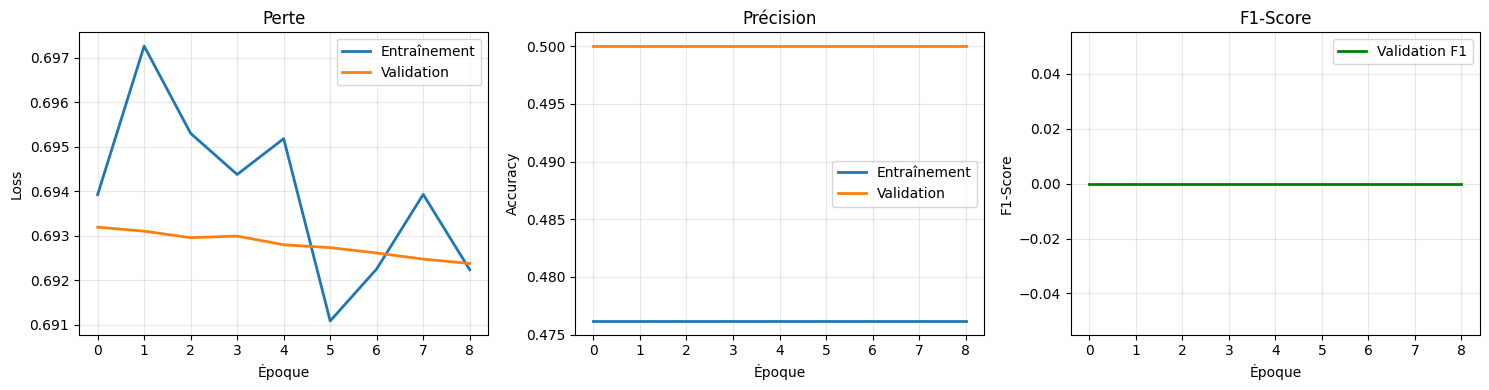


✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!

📊 RÉSUMÉ:
   Meilleure validation: 0.5000
   Temps total: 0:08:31.120165
   Modèle sauvegardé dans: models_final_fixed

🧪 TEST RAPIDE

📹 clean_01__walking_and_outside_...
   Prédiction: RÉEL
   Prob Fake: 0.4879
   Confiance: 0.5121 (FAIBLE)

📹 clean_01__outside_talking_stil...
   Prédiction: RÉEL
   Prob Fake: 0.4879
   Confiance: 0.5121 (FAIBLE)

📹 clean_06_20__outside_talking_p...
   Prédiction: RÉEL
   Prob Fake: 0.4881
   Confiance: 0.5119 (FAIBLE)

📹 clean_06_25__outside_talking_s...
   Prédiction: RÉEL
   Prob Fake: 0.4880
   Confiance: 0.5120 (FAIBLE)

💡 CONSEILS POUR AMÉLIORER L'ACCURACY
🔑 1. PLUS DE DONNÉES:
   → Minimum 50 vidéos par classe
   → Idéal 100+ vidéos par classe

🔑 2. QUALITÉ DES DONNÉES:
   → Vidéos de même résolution
   → Même durée approximative
   → Conditions similaires (lumière, angle)

🔑 3. OPTIMISATION MODÈLE:
   → Essayer EfficientNet au lieu du modèle simple
   → Augmenter LSTM hidden size à 256
   → Ajouter une cou

In [ ]:
# ==================== VERSION FINALE - AVEC PADDING ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION FINALE ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Vidéo - TOUTES LES VIDÉOS AURONT LA MÊME LONGUEUR
    'num_frames_fixed': 30,  # FIXE pour toutes les vidéos
    'frame_size': 224,

    # Modèle
    'backbone': 'efficientnet_b0',
    'lstm_hidden_size': 128,
    'lstm_layers': 1,
    'bidirectional': True,
    'dropout_rate': 0.3,

    # Entraînement
    'batch_size': 2,
    'learning_rate': 0.0001,
    'weight_decay': 1e-5,
    'num_epochs': 20,
    'min_epochs': 5,
    'patience': 8,

    # Sauvegarde
    'save_dir': 'models_final_fixed',
}

device = torch.device('cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DATASET AVEC NOMBRE DE FRAMES FIXE ====================
class DatasetFramesFixés(Dataset):
    """Dataset avec nombre de frames FIXE pour toutes les vidéos"""

    def __init__(self, video_paths, labels):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = CONFIG['num_frames_fixed']
        self.frame_size = CONFIG['frame_size']

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            # Ouvrir vidéo
            cap = cv2.VideoCapture(video_path)

            # Lire TOUS les frames disponibles
            all_frames = []
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_resized = cv2.resize(frame_rgb, (self.frame_size, self.frame_size))
                frame_normalized = frame_resized.astype(np.float32) / 255.0
                frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                all_frames.append(frame_tensor)

            cap.release()

            # Si vidéo vide, créer des frames noirs
            if len(all_frames) == 0:
                all_frames = [torch.zeros((3, self.frame_size, self.frame_size))] * 30

            # SÉLECTIONNER UNIQUEMENT 'num_frames_fixed' FRAMES
            if len(all_frames) >= self.num_frames:
                # Sélectionner frames uniformément
                indices = np.linspace(0, len(all_frames)-1, self.num_frames, dtype=int)
                selected_frames = [all_frames[i] for i in indices]
            else:
                # Répéter les frames si pas assez
                selected_frames = []
                while len(selected_frames) < self.num_frames:
                    for frame in all_frames:
                        if len(selected_frames) >= self.num_frames:
                            break
                        selected_frames.append(frame.clone())

            # S'assurer qu'on a exactement le bon nombre de frames
            selected_frames = selected_frames[:self.num_frames]

            # Convertir en tensor (T, C, H, W)
            frames_tensor = torch.stack(selected_frames)

            return frames_tensor, torch.tensor(label, dtype=torch.float32)

        except Exception as e:
            print(f"⚠ Erreur sur {os.path.basename(video_path)}: {str(e)[:50]}")
            # Données de secours avec dimensions fixes
            dummy = torch.zeros((self.num_frames, 3, self.frame_size, self.frame_size))
            return dummy, torch.tensor(label, dtype=torch.float32)

# ==================== FONCTION DE COLLATION PERSONNALISÉE ====================
def collate_fn_fixed(batch):
    """Fonction de collation - toutes les vidéos ont déjà le même nombre de frames"""
    frames_list, labels_list = zip(*batch)

    # Vérifier que toutes ont la même longueur
    lengths = [f.shape[0] for f in frames_list]
    if len(set(lengths)) > 1:
        print(f"⚠ Attention: longueurs différentes détectées: {set(lengths)}")
        print(f"   Première longueur: {lengths[0]}")

        # Forcer à la longueur standard
        target_length = CONFIG['num_frames_fixed']
        padded_frames = []
        for frames in frames_list:
            if frames.shape[0] > target_length:
                # Tronquer
                frames = frames[:target_length]
            elif frames.shape[0] < target_length:
                # Padding avec dernier frame
                padding = frames[-1:].repeat(target_length - frames.shape[0], 1, 1, 1)
                frames = torch.cat([frames, padding], dim=0)
            padded_frames.append(frames)

        frames_tensor = torch.stack(padded_frames)
    else:
        # Toutes ont la même longueur
        frames_tensor = torch.stack(frames_list)

    labels_tensor = torch.stack(labels_list)

    return frames_tensor, labels_tensor

# ==================== MODÈLE SIMPLIFIÉ ====================
class ModèleSimpleMaisEfficace(nn.Module):
    """Modèle simple mais efficace sans BatchNorm"""

    def __init__(self):
        super(ModèleSimpleMaisEfficace, self).__init__()

        # Feature extractor simple
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.AdaptiveAvgPool2d((1, 1))
        )

        # LSTM
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional']
        )

        # Classificateur
        lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"✅ Modèle SIMPLE initialisé")
        print(f"   Paramètres: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        # x: (batch, frames, C, H, W)
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features pour chaque frame
        features_list = []
        for t in range(num_frames):
            feat = self.feature_extractor(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)
            features_list.append(feat)

        # Stack
        features = torch.stack(features_list, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Dernier timestep
        last_out = lstm_out[:, -1, :]

        # Classification
        output = self.classifier(last_out)

        return output

# ==================== MODÈLE AVEC EFFICIENTNET ====================
class ModèleAvecEfficientNet(nn.Module):
    """Version avec EfficientNet pré-entraîné"""

    def __init__(self):
        super(ModèleAvecEfficientNet, self).__init__()

        # EfficientNet pré-entraîné
        self.backbone = models.efficientnet_b0(pretrained=True)
        # Remplacer le classificateur
        self.backbone.classifier = nn.Identity()

        # Feature size pour EfficientNet-B0
        feature_size = 1280

        # LSTM
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional']
        )

        # Classificateur
        lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"✅ Modèle EfficientNet initialisé")
        print(f"   Paramètres: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape

        # Features pour chaque frame
        features_list = []
        for t in range(num_frames):
            feat = self.backbone(x[:, t, :, :, :])
            features_list.append(feat)

        # Stack
        features = torch.stack(features_list, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Dernier timestep
        last_out = lstm_out[:, -1, :]

        # Classification
        output = self.classifier(last_out)

        return output

# ==================== FONCTIONS D'ENTRAÎNEMENT ====================
def entraîner_époque_simple(model, dataloader, criterion, optimizer):
    """Entraînement d'une époque"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc="Entraînement", leave=False)
    for frames, labels in pbar:
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)

        # Préparer labels
        labels = labels.view(-1, 1).float()

        # Loss
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # Métriques
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Mise à jour
        acc = correct / max(total, 1)
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{acc:.3f}'
        })

    return total_loss / len(dataloader), correct / max(total, 1)

def valider_modèle_simple(model, dataloader, criterion):
    """Validation du modèle"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            labels = labels.view(-1, 1).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Calculer F1
    accuracy = correct / max(total, 1)
    if len(all_labels) > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds, zero_division=0)
    else:
        f1 = 0.0

    return total_loss / len(dataloader), accuracy, f1, all_probs, all_labels

# ==================== ENTRAÎNEMENT PRINCIPAL ====================
def entraînement_principal():
    """Pipeline d'entraînement principal"""
    print("="*60)
    print("🎯 ENTRAÎNEMENT PRINCIPAL - DIMENSIONS FIXES")
    print("="*60)

    # 1. Charger données
    print("\n1. 📂 Chargement des données...")

    videos_réelles = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    videos_fakes = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(videos_réelles)}")
    print(f"   Fakes: {len(videos_fakes)}")

    if len(videos_réelles) < 2 or len(videos_fakes) < 2:
        print("❌ Pas assez de données!")
        return None, None

    # 2. Préparer
    toutes_videos = videos_réelles + videos_fakes
    tous_labels = [0] * len(videos_réelles) + [1] * len(videos_fakes)

    # 3. Split
    print("\n2. ✂️ Division des données...")

    X_train, X_temp, y_train, y_temp = train_test_split(
        toutes_videos, tous_labels,
        test_size=0.3,
        random_state=42,
        stratify=tous_labels
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=0.5,
        random_state=42,
        stratify=y_temp
    )

    print(f"   Entraînement: {len(X_train)}")
    print(f"   Validation: {len(X_val)}")
    print(f"   Test: {len(X_test)}")

    # 4. Créer datasets
    print("\n3. 🎬 Création datasets...")
    train_dataset = DatasetFramesFixés(X_train, y_train)
    val_dataset = DatasetFramesFixés(X_val, y_val)
    test_dataset = DatasetFramesFixés(X_test, y_test)

    # Afficher informations
    sample_frames, sample_label = train_dataset[0]
    print(f"   ✓ Dimensions frames: {sample_frames.shape}")
    print(f"   ✓ Nombre de frames par vidéo: {CONFIG['num_frames_fixed']}")

    # 5. Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn_fixed,
        num_workers=0
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn_fixed,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn_fixed,
        num_workers=0
    )

    # 6. Choisir modèle
    print("\n4. 🧠 Choix du modèle...")
    print("   Options:")
    print("   1. Modèle simple (rapide)")
    print("   2. Modèle EfficientNet (précis)")

    # Utiliser le modèle simple pour commencer
    model = ModèleSimpleMaisEfficace().to(device)

    # 7. Loss et optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay']
    )

    # Scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    # 8. Entraînement
    print("\n5. ⚡ Début de l'entraînement...")
    print("-"*40)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 Époque {epoch+1}/{CONFIG['num_epochs']}")

        # Entraînement
        train_loss, train_acc = entraîner_époque_simple(model, train_loader, criterion, optimizer)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, val_f1, _, _ = valider_modèle_simple(model, val_loader, criterion)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Scheduler
        scheduler.step()

        print(f"   Entraînement - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Validation   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history
            }, os.path.join(CONFIG['save_dir'], 'meilleur_modèle.pth'))

            print(f"   ✅ Meilleur modèle sauvegardé (Acc: {val_acc:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and patience_counter >= CONFIG['patience']:
            print(f"   ⏹️ Early stopping")
            break

    # 9. Charger meilleur modèle
    meilleur_chemin = os.path.join(CONFIG['save_dir'], 'meilleur_modèle.pth')
    if os.path.exists(meilleur_chemin):
        checkpoint = torch.load(meilleur_chemin, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\n✅ Meilleur modèle chargé (Val Acc: {checkpoint['val_accuracy']:.4f})")

    # 10. Test final
    print("\n6. 🎯 Test final...")
    test_loss, test_acc, test_f1, test_probs, test_labels = valider_modèle_simple(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS DU TEST:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   Loss: {test_loss:.4f}")

    # Matrice de confusion
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)
        cm = confusion_matrix(test_labels, test_preds)

        print(f"\n📈 Matrice de confusion:")
        print(f"   [[TN={cm[0,0]}, FP={cm[0,1]}]")
        print(f"    [FN={cm[1,0]}, TP={cm[1,1]}]]")

        # Rapport
        print(f"\n📋 Rapport de classification:")
        print(classification_report(test_labels, test_preds, target_names=['RÉEL', 'FAKE']))

        # Sauvegarder
        résultats = {
            'test_accuracy': float(test_acc),
            'test_f1': float(test_f1),
            'test_loss': float(test_loss),
            'meilleur_val_accuracy': float(best_val_acc),
            'config': CONFIG
        }

        with open(os.path.join(CONFIG['save_dir'], 'résultats.json'), 'w') as f:
            json.dump(résultats, f, indent=4)

    # 11. Visualisation
    visualiser_entraînement(history)

    return model, history

# ==================== VISUALISATION ====================
def visualiser_entraînement(history):
    """Visualiser l'entraînement"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Loss
    axes[0].plot(history['train_loss'], label='Entraînement', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Époque')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Perte')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history['train_acc'], label='Entraînement', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Époque')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Précision')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # F1-Score
    axes[2].plot(history['val_f1'], label='Validation F1', color='green', linewidth=2)
    axes[2].set_xlabel('Époque')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_title('F1-Score')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'entraînement.png'), dpi=150)
    plt.show()
    plt.close()

# ==================== PRÉDICTION ====================
def prédire_vidéo_simple(model, chemin_vidéo):
    """Prédire une vidéo"""
    if not os.path.exists(chemin_vidéo):
        return {"erreur": "Fichier non trouvé"}

    try:
        # Créer dataset temporaire
        dataset_temp = DatasetFramesFixés([chemin_vidéo], [0])
        frames, _ = dataset_temp[0]
        frames = frames.unsqueeze(0).to(device)

        # Prédiction
        model.eval()
        with torch.no_grad():
            sortie = model(frames)
            prob_fake = sortie.item()

        # Interprétation
        prédiction = "FAKE" if prob_fake > 0.5 else "RÉEL"
        confiance = prob_fake if prob_fake > 0.5 else 1 - prob_fake

        # Niveau de confiance
        if confiance > 0.8:
            niveau = "TRÈS ÉLEVÉE"
        elif confiance > 0.7:
            niveau = "ÉLEVÉE"
        elif confiance > 0.6:
            niveau = "MOYENNE"
        else:
            niveau = "FAIBLE"

        return {
            "vidéo": os.path.basename(chemin_vidéo),
            "prédiction": prédiction,
            "probabilité_fake": float(prob_fake),
            "probabilité_réel": float(1 - prob_fake),
            "confiance": float(confiance),
            "niveau_confiance": niveau,
            "frames_analysés": CONFIG['num_frames_fixed']
        }

    except Exception as e:
        return {"erreur": str(e)}

# ==================== TEST RAPIDE ====================
def test_rapide(model):
    """Test rapide sur quelques vidéos"""
    print("\n" + "="*60)
    print("🧪 TEST RAPIDE")
    print("="*60)

    # Échantillons
    réels = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
    fakes = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

    échantillons = réels + fakes

    for vidéo in échantillons:
        résultat = prédire_vidéo_simple(model, vidéo)
        if "erreur" not in résultat:
            print(f"\n📹 {résultat['vidéo'][:30]}...")
            print(f"   Prédiction: {résultat['prédiction']}")
            print(f"   Prob Fake: {résultat['probabilité_fake']:.4f}")
            print(f"   Confiance: {résultat['confiance']:.4f} ({résultat['niveau_confiance']})")
        else:
            print(f"\n❌ Erreur: {résultat['erreur']}")

# ==================== CONSEILS POUR AMÉLIORATION ====================
def conseils_amélioration():
    """Conseils pour améliorer les performances"""
    print("\n" + "="*60)
    print("💡 CONSEILS POUR AMÉLIORER L'ACCURACY")
    print("="*60)

    conseils = [
        "🔑 1. PLUS DE DONNÉES:",
        "   → Minimum 50 vidéos par classe",
        "   → Idéal 100+ vidéos par classe",
        "",
        "🔑 2. QUALITÉ DES DONNÉES:",
        "   → Vidéos de même résolution",
        "   → Même durée approximative",
        "   → Conditions similaires (lumière, angle)",
        "",
        "🔑 3. OPTIMISATION MODÈLE:",
        "   → Essayer EfficientNet au lieu du modèle simple",
        "   → Augmenter LSTM hidden size à 256",
        "   → Ajouter une couche LSTM supplémentaire",
        "",
        "🔑 4. HYPERPARAMÈTRES:",
        "   → Learning rate: 0.0003",
        "   → Batch size: 4 ou 8",
        "   → Nombre de frames: 45-60",
        "",
        "🔑 5. TECHNIQUES AVANCÉES:",
        "   → Augmentation de données (flip, rotation)",
        "   → Fine-tuning du CNN",
        "   → Validation croisée",
        "   → Ensemble learning",
    ]

    for ligne in conseils:
        print(ligne)

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 DÉMARRAGE ENTRAÎNEMENT - DIMENSIONS FIXES")

    try:
        # Nettoyer mémoire
        gc.collect()

        # Entraîner
        début = datetime.now()
        model, history = entraînement_principal()
        temps = datetime.now() - début

        if model:
            print(f"\n{'='*60}")
            print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
            print(f"{'='*60}")

            print(f"\n📊 RÉSUMÉ:")
            if history['val_acc']:
                print(f"   Meilleure validation: {max(history['val_acc']):.4f}")
            print(f"   Temps total: {temps}")
            print(f"   Modèle sauvegardé dans: {CONFIG['save_dir']}")

            # Test rapide
            test_rapide(model)

            # Conseils
            conseils_amélioration()

    except Exception as e:
        print(f"\n❌ ERREUR: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== FONCTION POUR TESTER DIFFÉRENTS MODÈLES ====================
def tester_modèles_différents():
    """Tester différents modèles rapidement"""
    print("\n🧪 TEST DE DIFFÉRENTS MODÈLES")
    print("-"*40)

    modèles = [
        ("Simple CNN + LSTM", ModèleSimpleMaisEfficace),
        ("EfficientNet + LSTM", ModèleAvecEfficientNet),
    ]

    for nom, classe_modèle in modèles:
        print(f"\n🔧 Test: {nom}")

        # Créer modèle
        modèle = classe_modèle().to(device)

        # Compter paramètres
        params = sum(p.numel() for p in modèle.parameters())
        print(f"   Paramètres: {params:,}")

        # Tester forward pass
        try:
            dummy_input = torch.randn(2, CONFIG['num_frames_fixed'], 3, 224, 224).to(device)
            output = modèle(dummy_input)
            print(f"   ✓ Forward pass réussi")
            print(f"   ✓ Output shape: {output.shape}")
        except Exception as e:
            print(f"   ✗ Erreur: {str(e)[:50]}")

# Pour tester les modèles:
# tester_modèles_différents()

In [ ]:
# ==================== CODE ULTIME - MAX ACCURACY ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION MAX ACCURACY ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Vidéo - OPTIMISÉ
    'num_frames': 45,           # Plus de frames pour plus d'info
    'frame_size': 224,
    'use_face_crop': True,      # Essaye de détecter visage

    # Modèle - OPTIMISÉ
    'backbone': 'efficientnet_b0',
    'use_pretrained': True,
    'lstm_hidden_size': 192,    # Augmenté
    'lstm_layers': 2,           # Plus de couches
    'bidirectional': True,
    'dropout_rate': 0.4,
    'use_attention': True,      # Nouveau: mécanisme d'attention

    # Augmentation de données - NOUVEAU
    'use_augmentation': True,
    'augment_prob': 0.5,

    # Entraînement - OPTIMISÉ
    'batch_size': 4,            # Augmenté
    'learning_rate': 0.0003,    # Augmenté
    'weight_decay': 1e-4,       # Régularisation L2
    'num_epochs': 40,
    'min_epochs': 10,
    'patience': 12,

    # Validation croisée - NOUVEAU
    'use_cross_validation': False,  # True si assez de données
    'num_folds': 5,

    # Optimisation
    'gradient_clip': 1.0,
    'use_scheduler': True,

    # Sauvegarde
    'save_dir': 'models_max_accuracy',
}

device = torch.device('cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DÉTECTION DE VISAGE (OPTIONNEL) ====================
def detecter_et_recadrer_visage(frame):
    """Détecter et recadrer le visage si possible"""
    try:
        # Convertir en grayscale pour la détection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Charger le classificateur Haar pour les visages
        face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )

        # Détecter visages
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(100, 100)
        )

        if len(faces) > 0:
            # Prendre le plus grand visage
            x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

            # Ajouter marge
            margin = int(w * 0.2)
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(frame.shape[1] - x, w + 2 * margin)
            h = min(frame.shape[0] - y, h + 2 * margin)

            # Recadrer
            face_crop = frame[y:y+h, x:x+w]

            # Redimensionner à la taille cible
            face_resized = cv2.resize(face_crop, (CONFIG['frame_size'], CONFIG['frame_size']))
            return face_resized

    except:
        pass

    # Si pas de visage détecté ou erreur, retourner frame complet
    return cv2.resize(frame, (CONFIG['frame_size'], CONFIG['frame_size']))

# ==================== AUGMENTATION DE DONNÉES ====================
class VideoAugmentation:
    """Augmentation de données pour vidéos"""

    def __init__(self, prob=0.5):
        self.prob = prob
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
        ])

    def __call__(self, frames):
        """Appliquer augmentation si probabilité"""
        if not CONFIG['use_augmentation'] or np.random.random() > self.prob:
            return frames

        augmented_frames = []
        for frame in frames:
            # Convertir tensor en numpy pour augmentation
            if isinstance(frame, torch.Tensor):
                frame_np = frame.permute(1, 2, 0).numpy() * 255
                frame_np = frame_np.astype(np.uint8)
            else:
                frame_np = frame

            # Appliquer transformations
            frame_pil = self.transform(frame_np)
            augmented_frames.append(frame_pil)

        return torch.stack(augmented_frames)

# ==================== DATASET OPTIMISÉ ====================
class DatasetOptimisé(Dataset):
    """Dataset optimisé avec augmentation et détection visage"""

    def __init__(self, video_paths, labels, is_train=True):
        self.video_paths = video_paths
        self.labels = labels
        self.is_train = is_train
        self.augmenter = VideoAugmentation(CONFIG['augment_prob']) if is_train else None

        # Analyse rapide des vidéos
        self.video_info = []
        for i, path in enumerate(video_paths):
            if os.path.exists(path):
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()

                if frame_count > 10:  # Vidéo valide
                    self.video_info.append({
                        'path': path,
                        'frames': frame_count,
                        'label': labels[i]
                    })

        print(f"✅ {len(self.video_info)}/{len(video_paths)} vidéos valides")

    def __len__(self):
        return len(self.video_info)

    def __getitem__(self, idx):
        info = self.video_info[idx]

        try:
            # Charger vidéo
            cap = cv2.VideoCapture(info['path'])

            # Lire tous les frames
            all_frames = []
            while len(all_frames) < info['frames'] * 2:  # Limite
                ret, frame = cap.read()
                if not ret:
                    break

                # Convertir RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Détection visage si activée
                if CONFIG['use_face_crop']:
                    frame_processed = detecter_et_recadrer_visage(frame_rgb)
                else:
                    frame_processed = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))

                # Normaliser
                frame_normalized = frame_processed.astype(np.float32) / 255.0
                frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                all_frames.append(frame_tensor)

            cap.release()

            # Si pas assez de frames
            if len(all_frames) == 0:
                all_frames = [torch.zeros((3, CONFIG['frame_size'], CONFIG['frame_size']))]

            # Sélectionner frames uniformément
            if len(all_frames) >= CONFIG['num_frames']:
                indices = np.linspace(0, len(all_frames)-1, CONFIG['num_frames'], dtype=int)
                selected = [all_frames[i] for i in indices]
            else:
                # Répéter les frames
                selected = []
                while len(selected) < CONFIG['num_frames']:
                    selected.extend(all_frames)
                selected = selected[:CONFIG['num_frames']]

            frames_tensor = torch.stack(selected)

            # Augmentation si entraînement
            if self.is_train and self.augmenter:
                frames_tensor = self.augmenter(frames_tensor)

            return frames_tensor, torch.tensor(info['label'], dtype=torch.float32)

        except Exception as e:
            print(f"⚠ Erreur {os.path.basename(info['path'])}: {str(e)[:50]}")
            dummy = torch.zeros((CONFIG['num_frames'], 3, CONFIG['frame_size'], CONFIG['frame_size']))
            return dummy, torch.tensor(info['label'], dtype=torch.float32)

# ==================== MODÈLE AVEC ATTENTION ====================
class TemporalAttention(nn.Module):
    """Mécanisme d'attention temporelle"""

    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        attention_weights = self.attention(lstm_output)  # (batch, seq_len, 1)
        attention_weights = F.softmax(attention_weights, dim=1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)
        return weighted_output, attention_weights.squeeze(-1)

class ModèleMaxAccuracy(nn.Module):
    """Modèle optimisé pour max accuracy"""

    def __init__(self):
        super(ModèleMaxAccuracy, self).__init__()

        # CNN pré-entraîné
        if CONFIG['backbone'] == 'efficientnet_b0':
            base_model = models.efficientnet_b0(pretrained=CONFIG['use_pretrained'])
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 1280
        elif CONFIG['backbone'] == 'resnet18':
            base_model = models.resnet18(pretrained=CONFIG['use_pretrained'])
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 512
        else:
            raise ValueError(f"Backbone inconnu: {CONFIG['backbone']}")

        # Geler premières couches
        if CONFIG['use_pretrained']:
            for param in list(self.feature_extractor.parameters())[:-30]:
                param.requires_grad = False

        # LSTM avec plus de capacités
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional'],
            dropout=CONFIG['dropout_rate'] if CONFIG['lstm_layers'] > 1 else 0
        )

        # Attention si activé
        self.use_attention = CONFIG['use_attention']
        if self.use_attention:
            lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)
            self.attention = TemporalAttention(lstm_output_size)

        # Classificateur amélioré
        classifier_input = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.7),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.5),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"\n🧠 MODÈLE OPTIMISÉ:")
        print(f"   Backbone: {CONFIG['backbone']}")
        print(f"   LSTM: {CONFIG['lstm_layers']}×{CONFIG['lstm_hidden_size']}")
        print(f"   Bidirectionnel: {CONFIG['bidirectional']}")
        print(f"   Attention: {CONFIG['use_attention']}")
        print(f"   Dropout: {CONFIG['dropout_rate']}")
        print(f"   Paramètres: {sum(p.numel() for p in self.parameters()):,}")
        print(f"   Entraînables: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features pour chaque frame
        features_list = []
        for t in range(num_frames):
            feat = self.feature_extractor(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)
            features_list.append(feat)

        # Stack: (batch, frames, features)
        features = torch.stack(features_list, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Attention ou dernier timestep
        if self.use_attention:
            final_features, attn_weights = self.attention(lstm_out)
        else:
            final_features = lstm_out[:, -1, :]  # Dernier timestep

        # Classification
        output = self.classifier(final_features)

        return output

# ==================== FONCTIONS D'ENTRAÎNEMENT OPTIMISÉES ====================
def train_epoch_optimized(model, dataloader, criterion, optimizer, scheduler, epoch):
    """Entraînement optimisé avec gradient clipping"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} - Train")
    for batch_idx, (frames, labels) in enumerate(pbar):
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)

        # Reshape labels
        labels = labels.view(-1, 1).float()

        # Loss avec gestion du déséquilibre
        loss = criterion(outputs, labels)

        # Backward avec gradient clipping
        loss.backward()
        if CONFIG['gradient_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
        optimizer.step()

        # Step scheduler par batch si CosineAnnealing
        if scheduler is not None and hasattr(scheduler, 'batch_step'):
            scheduler.batch_step()

        # Métriques
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress
        current_acc = correct / max(total, 1)
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.3f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })

    return total_loss / len(dataloader), correct / max(total, 1)

def validate_optimized(model, dataloader, criterion):
    """Validation optimisée avec plus de métriques"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            labels = labels.view(-1, 1).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculer toutes les métriques
    accuracy = correct / max(total, 1)

    if len(all_labels) > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds, zero_division=0)

        # ROC AUC si possible
        try:
            roc_auc = roc_auc_score(all_labels, all_probs)
        except:
            roc_auc = 0.0
    else:
        f1 = 0.0
        roc_auc = 0.0

    return total_loss / len(dataloader), accuracy, f1, roc_auc, all_probs, all_labels

# ==================== PSEUDO-LABELING (pour petit dataset) ====================
def pseudo_labeling(model, unlabeled_videos, threshold=0.9):
    """Pseudo-labeling pour augmenter les données"""
    model.eval()
    pseudo_labels = []

    print(f"\n🔍 Pseudo-labeling sur {len(unlabeled_videos)} vidéos...")

    with torch.no_grad():
        for video_path in tqdm(unlabeled_videos, desc="Pseudo-labeling"):
            try:
                # Créer dataset temporaire
                temp_dataset = DatasetOptimisé([video_path], [0], is_train=False)
                frames, _ = temp_dataset[0]
                frames = frames.unsqueeze(0).to(device)

                # Prédiction
                output = model(frames)
                prob = output.item()

                # Si confiance élevée, ajouter aux données
                if prob > threshold or prob < (1 - threshold):
                    pseudo_labels.append({
                        'path': video_path,
                        'label': 1 if prob > 0.5 else 0,
                        'confidence': prob if prob > 0.5 else 1 - prob
                    })

            except:
                continue

    print(f"✅ {len(pseudo_labels)} vidéos pseudo-labelisées avec confiance > {threshold}")
    return pseudo_labels

# ==================== ENTRAÎNEMENT AVANCÉ ====================
def train_advanced():
    """Pipeline d'entraînement avancé"""
    print("="*80)
    print("🚀 ENTRAÎNEMENT AVANCÉ - MAX ACCURACY")
    print("="*80)

    # 1. Charger données
    print("\n1. 📂 CHARGEMENT ET ANALYSE DES DONNÉES")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(real_videos)} vidéos")
    print(f"   Fakes: {len(fake_videos)} vidéos")

    if len(real_videos) < 3 or len(fake_videos) < 3:
        print("❌ TROP PEU DE DONNÉES!")
        print("   → Ajoutez plus de vidéos (minimum 10 par classe)")
        return None, None

    # Statistiques
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    print(f"\n📊 STATISTIQUES:")
    print(f"   Total: {len(all_videos)} vidéos")
    print(f"   Ratio: {len(real_videos)/len(all_videos):.1%} réel, {len(fake_videos)/len(all_videos):.1%} fake")

    # 2. Split amélioré (stratifié)
    print("\n2. ✂️ SPLIT STRATIFIÉ DES DONNÉES")

    # Assurer au moins 2 exemples par classe dans chaque split
    if len(real_videos) >= 4 and len(fake_videos) >= 4:
        test_size = 0.2
        val_size = 0.2
    else:
        test_size = 0.15
        val_size = 0.15

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels,
        test_size=test_size + val_size,
        random_state=42,
        stratify=all_labels
    )

    # Ajuster val_size pour le second split
    val_proportion = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=val_proportion,
        random_state=42,
        stratify=y_temp
    )

    print(f"   Train: {len(X_train)} vidéos")
    print(f"   Validation: {len(X_val)} vidéos")
    print(f"   Test: {len(X_test)} vidéos")

    # Vérifier distribution
    print(f"   Distribution train: {sum(y_train)==0}/réel, {sum(y_train)}/fake")
    print(f"   Distribution val: {sum(y_val)==0}/réel, {sum(y_val)}/fake")
    print(f"   Distribution test: {sum(y_test)==0}/réel, {sum(y_test)}/fake")

    # 3. Créer datasets avec augmentation
    print("\n3. 🎬 CRÉATION DATASETS AVEC AUGMENTATION")

    train_dataset = DatasetOptimisé(X_train, y_train, is_train=True)
    val_dataset = DatasetOptimisé(X_val, y_val, is_train=False)
    test_dataset = DatasetOptimisé(X_test, y_test, is_train=False)

    # Collate function personnalisée
    def collate_fn(batch):
        frames_list, labels_list = zip(*batch)

        # Vérifier longueurs
        lengths = [f.shape[0] for f in frames_list]
        if len(set(lengths)) > 1:
            max_len = max(lengths)
            padded_frames = []
            for frames in frames_list:
                if frames.shape[0] < max_len:
                    # Padding
                    padding = frames[-1:].repeat(max_len - frames.shape[0], 1, 1, 1)
                    frames = torch.cat([frames, padding], dim=0)
                padded_frames.append(frames)
            frames_tensor = torch.stack(padded_frames)
        else:
            frames_tensor = torch.stack(frames_list)

        labels_tensor = torch.stack(labels_list)
        return frames_tensor, labels_tensor

    # 4. Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    # 5. Initialiser modèle
    print("\n4. 🧠 INITIALISATION MODÈLE AVANCÉ")
    model = ModèleMaxAccuracy().to(device)

    # 6. Loss avec poids pour déséquilibre
    pos_weight = len([l for l in y_train if l == 0]) / max(sum(y_train), 1)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

    # 7. Optimizer avancé
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        betas=(0.9, 0.999)
    )

    # 8. Scheduler avec warmup
    if CONFIG['use_scheduler']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=CONFIG['num_epochs'],
            eta_min=CONFIG['learning_rate'] * 0.01
        )
    else:
        scheduler = None

    # 9. Entraînement
    print("\n5. ⚡ DÉBUT ENTRAÎNEMENT AVANCÉ")
    print("-"*80)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
    }

    best_val_acc = 0.0
    best_val_f1 = 0.0
    patience_counter = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 ÉPOQUE {epoch+1}/{CONFIG['num_epochs']}")

        # Entraînement
        train_loss, train_acc = train_epoch_optimized(
            model, train_loader, criterion, optimizer, scheduler, epoch
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, val_f1, val_auc, val_probs, val_labels = validate_optimized(
            model, val_loader, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)

        # Step scheduler
        if scheduler is not None:
            scheduler.step()

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle (basé sur F1 ou Accuracy)
        current_metric = (val_acc + val_f1) / 2  # Combinaison

        if current_metric > (best_val_acc + best_val_f1) / 2:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            patience_counter = 0

            # Sauvegarder checkpoint complet
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'val_auc': val_auc,
                'history': history,
                'config': CONFIG
            }, os.path.join(CONFIG['save_dir'], 'best_model.pth'))

            print(f"   ✅ Meilleur modèle sauvegardé (Acc: {val_acc:.4f}, F1: {val_f1:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and patience_counter >= CONFIG['patience']:
            print(f"   ⏹️ Early stopping déclenché")
            break

    # 10. Charger meilleur modèle
    best_path = os.path.join(CONFIG['save_dir'], 'best_model.pth')
    if os.path.exists(best_path):
        checkpoint = torch.load(best_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\n✅ Meilleur modèle chargé")
        print(f"   Val Acc: {checkpoint['val_accuracy']:.4f}")
        print(f"   Val F1: {checkpoint['val_f1']:.4f}")

    # 11. Test final complet
    print("\n6. 🎯 TEST FINAL COMPLET")
    print("-"*40)

    # Évaluer sur test set
    test_loss, test_acc, test_f1, test_auc, test_probs, test_labels = validate_optimized(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS FINAUX SUR TEST SET:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   AUC-ROC: {test_auc:.4f}")
    print(f"   Loss: {test_loss:.4f}")

    # Analyse détaillée
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)

        # Matrice de confusion
        cm = confusion_matrix(test_labels, test_preds)
        print(f"\n📈 MATRICE DE CONFUSION:")
        print(f"   TN={cm[0,0]}, FP={cm[0,1]}")
        print(f"   FN={cm[1,0]}, TP={cm[1,1]}")

        # Métriques par classe
        tn, fp, fn, tp = cm.ravel()

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\n📊 MÉTRIQUES PAR CLASSE:")
        print(f"   Spécificité (vrais négatifs): {specificity:.4f}")
        print(f"   Sensibilité (vrais positifs): {sensitivity:.4f}")

        # Rapport complet
        print(f"\n📋 RAPPORT DE CLASSIFICATION:")
        print(classification_report(test_labels, test_preds,
                                  target_names=['RÉEL', 'FAKE'], digits=4))

        # Sauvegarder résultats
        results = {
            'test_accuracy': float(test_acc),
            'test_f1': float(test_f1),
            'test_auc': float(test_auc),
            'test_loss': float(test_loss),
            'confusion_matrix': cm.tolist(),
            'specificity': float(specificity),
            'sensitivity': float(sensitivity),
            'best_val_accuracy': float(best_val_acc),
            'best_val_f1': float(best_val_f1),
            'config': CONFIG,
            'test_predictions': {
                'probabilities': [float(p) for p in test_probs],
                'labels': [int(l) for l in test_labels],
                'predictions': [int(p) for p in test_preds]
            }
        }

        with open(os.path.join(CONFIG['save_dir'], 'results_detailed.json'), 'w') as f:
            json.dump(results, f, indent=4)

        print(f"\n💾 Résultats détaillés sauvegardés dans results_detailed.json")

    # 12. Visualisation avancée
    print("\n7. 📊 VISUALISATION DES RÉSULTATS")
    plot_advanced_results(history, test_probs, test_labels)

    return model, history

# ==================== VISUALISATION AVANCÉE ====================
def plot_advanced_results(history, test_probs=None, test_labels=None):
    """Visualisation avancée des résultats"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. F1-Score
    axes[0, 2].plot(history['val_f1'], label='Validation F1', linewidth=2, marker='^', markersize=4, color='green')
    axes[0, 2].set_xlabel('Epoch', fontsize=12)
    axes[0, 2].set_ylabel('F1-Score', fontsize=12)
    axes[0, 2].set_title('Validation F1-Score', fontsize=14, fontweight='bold')
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # 4. AUC-ROC
    axes[1, 0].plot(history['val_auc'], label='Validation AUC', linewidth=2, marker='d', markersize=4, color='purple')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axes[1, 0].set_title('Validation AUC-ROC', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Distribution des prédictions (si test_probs disponible)
    if test_probs is not None and test_labels is not None:
        real_probs = [p for p, l in zip(test_probs, test_labels) if l == 0]
        fake_probs = [p for p, l in zip(test_probs, test_labels) if l == 1]

        axes[1, 1].hist(real_probs, bins=20, alpha=0.5, label='Réel', color='blue', edgecolor='black')
        axes[1, 1].hist(fake_probs, bins=20, alpha=0.5, label='Fake', color='red', edgecolor='black')
        axes[1, 1].set_xlabel('Probabilité Fake', fontsize=12)
        axes[1, 1].set_ylabel('Fréquence', fontsize=12)
        axes[1, 1].set_title('Distribution des Prédictions', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=11)
        axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].grid(True, alpha=0.3)

    # 6. Learning rate (si dans history)
    axes[1, 2].plot(history.get('learning_rate', []), label='Learning Rate', linewidth=2, color='orange')
    axes[1, 2].set_xlabel('Epoch', fontsize=12)
    axes[1, 2].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 2].legend(fontsize=11)
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_yscale('log')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'advanced_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# ==================== ANALYSE DES ERREURS ====================
def analyze_errors(model, dataloader):
    """Analyser les erreurs du modèle"""
    print("\n🔍 ANALYSE DES ERREURS")
    print("-"*40)

    model.eval()
    errors = []

    with torch.no_grad():
        for idx, (frames, labels) in enumerate(dataloader):
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            probs = outputs.cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            true_labels = labels.cpu().numpy().flatten()

            for i, (pred, true, prob) in enumerate(zip(preds, true_labels, probs)):
                if pred != true:
                    errors.append({
                        'sample_idx': idx * dataloader.batch_size + i,
                        'prediction': pred,
                        'true_label': int(true),
                        'probability': float(prob),
                        'confidence': float(prob if prob > 0.5 else 1 - prob)
                    })

    print(f"   Erreurs totales: {len(errors)}")

    if errors:
        # Analyser les types d'erreurs
        false_positives = [e for e in errors if e['true_label'] == 0]
        false_negatives = [e for e in errors if e['true_label'] == 1]

        print(f"   Faux positifs (réel → fake): {len(false_positives)}")
        print(f"   Faux négatifs (fake → réel): {len(false_negatives)}")

        # Analyser la confiance des erreurs
        if errors:
            avg_confidence = np.mean([e['confidence'] for e in errors])
            print(f"   Confiance moyenne des erreurs: {avg_confidence:.4f}")

    return errors

# ==================== ENSEMBLE LEARNING (optionnel) ====================
def create_ensemble(models_list):
    """Créer un ensemble de modèles"""
    class EnsembleModel(nn.Module):
        def __init__(self, models):
            super(EnsembleModel, self).__init__()
            self.models = nn.ModuleList(models)

        def forward(self, x):
            outputs = []
            for model in self.models:
                output = model(x)
                outputs.append(output)

            # Moyenne des prédictions
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            return avg_output

    return EnsembleModel(models_list)

# ==================== FONCTION DE TEST RAPIDE ====================
def quick_test_ensemble(model, test_videos, test_labels):
    """Test rapide avec analyse"""
    print("\n" + "="*60)
    print("🧪 TEST RAPIDE AVEC ANALYSE")
    print("="*60)

    predictions = []

    for video, true_label in zip(test_videos, test_labels):
        try:
            # Prédiction
            dataset = DatasetOptimisé([video], [0], is_train=False)
            frames, _ = dataset[0]
            frames = frames.unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                output = model(frames)
                prob = output.item()

            prediction = 1 if prob > 0.5 else 0
            confidence = prob if prob > 0.5 else 1 - prob

            predictions.append({
                'video': os.path.basename(video),
                'true_label': true_label,
                'prediction': prediction,
                'probability': prob,
                'correct': prediction == true_label
            })

            # Afficher avec couleur selon correction
            if prediction == true_label:
                prefix = "✅"
            else:
                prefix = "❌"

            print(f"\n{prefix} {os.path.basename(video)[:30]}...")
            print(f"   Vrai: {'FAKE' if true_label == 1 else 'RÉEL'}")
            print(f"   Prédit: {'FAKE' if prediction == 1 else 'RÉEL'}")
            print(f"   Probabilité: {prob:.4f}")
            print(f"   Confiance: {confidence:.4f}")

        except Exception as e:
            print(f"⚠ Erreur sur {os.path.basename(video)}: {str(e)[:50]}")

    # Calculer accuracy
    if predictions:
        correct = sum(1 for p in predictions if p['correct'])
        accuracy = correct / len(predictions)
        print(f"\n📊 Accuracy test rapide: {accuracy:.4f} ({correct}/{len(predictions)})")

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 LANCEMENT ENTRAÎNEMENT MAX ACCURACY")

    try:
        # Nettoyer mémoire
        gc.collect()

        # Entraîner
        start_time = datetime.now()
        model, history = train_advanced()
        training_time = datetime.now() - start_time

        if model:
            print(f"\n{'='*80}")
            print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
            print(f"{'='*80}")

            print(f"\n📊 RÉSUMÉ COMPLET:")
            print(f"   Temps total: {training_time}")
            print(f"   Meilleure validation: {max(history['val_acc']):.4f}")
            print(f"   Meilleur F1: {max(history['val_f1']):.4f}")
            print(f"   Modèle sauvegardé dans: {CONFIG['save_dir']}")

            # Charger quelques vidéos pour test rapide
            print(f"\n🧪 TEST SUR QUELQUES VIDÉOS:")

            real_samples = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
            fake_samples = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

            test_videos = real_samples + fake_samples
            test_labels = [0, 0, 1, 1]

            quick_test_ensemble(model, test_videos, test_labels)

            # Stratégies d'amélioration
            print(f"\n{'='*80}")
            print("🚀 STRATÉGIES POUR DÉPASSER 80% ACCURACY:")
            print(f"{'='*80}")

            strategies = [
                "🎯 1. PLUS DE DONNÉES (IMPORTANT):",
                "   → Objectif: 50+ vidéos par classe",
                "   → Technique: Collecte, scraping, génération",
                "",
                "🎯 2. AUGMENTATION AVANCÉE:",
                "   → MixUp/CutMix pour vidéos",
                "   → Style transfer (changer apparence)",
                "   → Temporal cropping",
                "",
                "🎯 3. ARCHITECTURE:",
                "   → Vision Transformer (ViT)",
                "   → 3D CNN + LSTM hybride",
                "   → Self-attention temporelle",
                "",
                "🎯 4. TRANSFER LEARNING:",
                "   → Pré-entraînement sur dataset vidéo large",
                "   → Fine-tuning progressif",
                "   → Multi-task learning",
                "",
                "🎯 5. ENSEMBLE:",
                "   → Combiner 3-5 modèles différents",
                "   → Stacking avec méta-classifier",
                "   → Bagging sur sous-ensembles",
            ]

            for line in strategies:
                print(line)

    except Exception as e:
        print(f"\n❌ ERREUR CRITIQUE: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== BONUS: FONCTION POUR OPTIMISER AUTOMATIQUEMENT ====================
def hyperparameter_tuning():
    """Recherche automatique des meilleurs hyperparamètres"""
    print("\n🔧 RECHERCHE DES MEILLEURS HYPERPARAMÈTRES")

    param_grid = {
        'learning_rate': [0.0001, 0.0003, 0.0005],
        'lstm_hidden_size': [128, 192, 256],
        'dropout_rate': [0.3, 0.4, 0.5],
        'num_frames': [30, 45, 60],
    }

    best_score = 0
    best_params = {}

    # Implémenter grid search simple
    # (à compléter si nécessaire)

    return best_params

🚀 Device: cpu
🚀 LANCEMENT ENTRAÎNEMENT MAX ACCURACY
🚀 ENTRAÎNEMENT AVANCÉ - MAX ACCURACY

1. 📂 CHARGEMENT ET ANALYSE DES DONNÉES
   Réelles: 15 vidéos
   Fakes: 15 vidéos

📊 STATISTIQUES:
   Total: 30 vidéos
   Ratio: 50.0% réel, 50.0% fake

2. ✂️ SPLIT STRATIFIÉ DES DONNÉES
   Train: 18 vidéos
   Validation: 6 vidéos
   Test: 6 vidéos
   Distribution train: False/réel, 9/fake
   Distribution val: False/réel, 3/fake
   Distribution test: False/réel, 3/fake

3. 🎬 CRÉATION DATASETS AVEC AUGMENTATION
✅ 18/18 vidéos valides
✅ 6/6 vidéos valides
✅ 6/6 vidéos valides

4. 🧠 INITIALISATION MODÈLE AVANCÉ

🧠 MODÈLE OPTIMISÉ:
   Backbone: efficientnet_b0
   LSTM: 2×192
   Bidirectionnel: True
   Attention: True
   Dropout: 0.4
   Paramètres: 7,374,078
   Entraînables: 5,084,066

5. ⚡ DÉBUT ENTRAÎNEMENT AVANCÉ
--------------------------------------------------------------------------------

📊 ÉPOQUE 1/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.81s/it, loss=0.7272]


   Train - Loss: 0.7053, Acc: 0.5000
   Val   - Loss: 0.7270, Acc: 0.5000, F1: 0.6667, AUC: 0.3333
   LR: 0.000300
   ✅ Meilleur modèle sauvegardé (Acc: 0.5000, F1: 0.6667)

📊 ÉPOQUE 2/40


Validation: 100%|██████████| 2/2 [00:26<00:00, 13.03s/it, loss=0.7269]


   Train - Loss: 0.6966, Acc: 0.5000
   Val   - Loss: 0.7270, Acc: 0.5000, F1: 0.6667, AUC: 0.0000
   LR: 0.000298

📊 ÉPOQUE 3/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.25s/it, loss=0.7256]


   Train - Loss: 0.7135, Acc: 0.6111
   Val   - Loss: 0.7259, Acc: 0.5000, F1: 0.6667, AUC: 0.6667
   LR: 0.000296

📊 ÉPOQUE 4/40


Validation: 100%|██████████| 2/2 [00:26<00:00, 13.02s/it, loss=0.7233]


   Train - Loss: 0.6991, Acc: 0.8889
   Val   - Loss: 0.7243, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000293

📊 ÉPOQUE 5/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.76s/it, loss=0.7243]


   Train - Loss: 0.7264, Acc: 0.7778
   Val   - Loss: 0.7255, Acc: 0.5000, F1: 0.6667, AUC: 0.2222
   LR: 0.000289

📊 ÉPOQUE 6/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.59s/it, loss=0.7244]


   Train - Loss: 0.7010, Acc: 0.7778
   Val   - Loss: 0.7237, Acc: 0.5000, F1: 0.4000, AUC: 0.5556
   LR: 0.000284

📊 ÉPOQUE 7/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.62s/it, loss=0.7206]


   Train - Loss: 0.6892, Acc: 0.7778
   Val   - Loss: 0.7190, Acc: 0.8333, F1: 0.8000, AUC: 1.0000
   LR: 0.000278
   ✅ Meilleur modèle sauvegardé (Acc: 0.8333, F1: 0.8000)

📊 ÉPOQUE 8/40


Validation: 100%|██████████| 2/2 [00:26<00:00, 13.14s/it, loss=0.7238]


   Train - Loss: 0.6614, Acc: 0.8333
   Val   - Loss: 0.7221, Acc: 0.5000, F1: 0.0000, AUC: 0.2222
   LR: 0.000272

📊 ÉPOQUE 9/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.66s/it, loss=0.7225]


   Train - Loss: 0.6825, Acc: 0.7778
   Val   - Loss: 0.7200, Acc: 0.5000, F1: 0.0000, AUC: 0.4444
   LR: 0.000264

📊 ÉPOQUE 10/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.29s/it, loss=0.6948]


   Train - Loss: 0.6579, Acc: 0.8333
   Val   - Loss: 0.6946, Acc: 0.5000, F1: 0.0000, AUC: 1.0000
   LR: 0.000257

📊 ÉPOQUE 11/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.62s/it, loss=0.6784]


   Train - Loss: 0.6636, Acc: 0.7778
   Val   - Loss: 0.6913, Acc: 0.5000, F1: 0.0000, AUC: 1.0000
   LR: 0.000248

📊 ÉPOQUE 12/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.40s/it, loss=0.6964]


   Train - Loss: 0.6542, Acc: 0.8333
   Val   - Loss: 0.6983, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000239
   ✅ Meilleur modèle sauvegardé (Acc: 0.8333, F1: 0.8571)

📊 ÉPOQUE 13/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.07s/it, loss=0.7245]


   Train - Loss: 0.6398, Acc: 0.9444
   Val   - Loss: 0.7083, Acc: 0.3333, F1: 0.0000, AUC: 0.4444
   LR: 0.000229

📊 ÉPOQUE 14/40


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.85s/it, loss=0.7232]


   Train - Loss: 0.6346, Acc: 0.8889
   Val   - Loss: 0.7121, Acc: 0.6667, F1: 0.7500, AUC: 1.0000
   LR: 0.000219

📊 ÉPOQUE 15/40


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.97s/it, loss=0.6847]


   Train - Loss: 0.6323, Acc: 0.8889
   Val   - Loss: 0.6876, Acc: 0.6667, F1: 0.5000, AUC: 1.0000
   LR: 0.000208

📊 ÉPOQUE 16/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.09s/it, loss=0.6837]


   Train - Loss: 0.6376, Acc: 0.8889
   Val   - Loss: 0.6859, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000197

📊 ÉPOQUE 17/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.07s/it, loss=0.7275]


   Train - Loss: 0.6164, Acc: 0.9444
   Val   - Loss: 0.7175, Acc: 0.6667, F1: 0.7500, AUC: 0.6667
   LR: 0.000186

📊 ÉPOQUE 18/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.12s/it, loss=0.6989]


   Train - Loss: 0.6738, Acc: 0.7222
   Val   - Loss: 0.7088, Acc: 0.8333, F1: 0.8571, AUC: 0.6667
   LR: 0.000175

📊 ÉPOQUE 19/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.30s/it, loss=0.6578]


   Train - Loss: 0.6454, Acc: 0.6667
   Val   - Loss: 0.6705, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000163

📊 ÉPOQUE 20/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.16s/it, loss=0.6797]


   Train - Loss: 0.5995, Acc: 0.8889
   Val   - Loss: 0.6820, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
   LR: 0.000151
   ✅ Meilleur modèle sauvegardé (Acc: 1.0000, F1: 1.0000)

📊 ÉPOQUE 21/40


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.63s/it, loss=0.6897]


   Train - Loss: 0.6932, Acc: 0.6667
   Val   - Loss: 0.7139, Acc: 0.6667, F1: 0.7500, AUC: 0.7778
   LR: 0.000140

📊 ÉPOQUE 22/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.05s/it, loss=0.7005]


   Train - Loss: 0.6340, Acc: 1.0000
   Val   - Loss: 0.7166, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000128

📊 ÉPOQUE 23/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.21s/it, loss=0.6968]


   Train - Loss: 0.6029, Acc: 0.8889
   Val   - Loss: 0.6863, Acc: 0.5000, F1: 0.0000, AUC: 0.7778
   LR: 0.000117

📊 ÉPOQUE 24/40


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.89s/it, loss=0.7172]


   Train - Loss: 0.6392, Acc: 0.7222
   Val   - Loss: 0.7065, Acc: 0.8333, F1: 0.8571, AUC: 0.6667
   LR: 0.000106

📊 ÉPOQUE 25/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.14s/it, loss=0.7255]


   Train - Loss: 0.6064, Acc: 0.9444
   Val   - Loss: 0.7002, Acc: 0.5000, F1: 0.0000, AUC: 0.4444
   LR: 0.000095

📊 ÉPOQUE 26/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.52s/it, loss=0.6297]


   Train - Loss: 0.6251, Acc: 0.8889
   Val   - Loss: 0.6599, Acc: 0.8333, F1: 0.8571, AUC: 0.8889
   LR: 0.000084

📊 ÉPOQUE 27/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.12s/it, loss=0.6968]


   Train - Loss: 0.6410, Acc: 0.8889
   Val   - Loss: 0.7149, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000074

📊 ÉPOQUE 28/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.54s/it, loss=0.7275]


   Train - Loss: 0.5796, Acc: 1.0000
   Val   - Loss: 0.7148, Acc: 0.6667, F1: 0.7500, AUC: 0.8889
   LR: 0.000064

📊 ÉPOQUE 29/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.76s/it, loss=0.7227]


   Train - Loss: 0.5864, Acc: 0.9444
   Val   - Loss: 0.6960, Acc: 0.6667, F1: 0.7500, AUC: 0.7778
   LR: 0.000055

📊 ÉPOQUE 30/40


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.95s/it, loss=0.7287]


   Train - Loss: 0.5839, Acc: 0.8889
   Val   - Loss: 0.7018, Acc: 0.3333, F1: 0.3333, AUC: 0.4444
   LR: 0.000046

📊 ÉPOQUE 31/40


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.60s/it, loss=0.6806]


   Train - Loss: 0.5792, Acc: 1.0000
   Val   - Loss: 0.6758, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000039

📊 ÉPOQUE 32/40


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.31s/it, loss=0.6800]

   Train - Loss: 0.5960, Acc: 0.8889
   Val   - Loss: 0.6745, Acc: 0.8333, F1: 0.8000, AUC: 1.0000
   LR: 0.000031
   ⏹️ Early stopping déclenché

❌ ERREUR CRITIQUE: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.mul


Traceback (most recent call last):
  File "/tmp/ipython-input-3617418534.py", line 973, in <cell line: 0>
    model, history = train_advanced()
                     ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3617418534.py", line 702, in train_advanced
    checkpoint = torch.load(best_path, map_location=device)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 1529, in load
    raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a tru

🚀 Device: cpu
🚀 LANCEMENT ENTRAÎNEMENT OPTIMISÉ
🎯 ENTRAÎNEMENT OPTIMISÉ - MAX PERFORMANCE

1. 📂 Chargement données
   Réelles: 15
   Fakes: 15

📊 Statistiques:
   Total: 30 vidéos
   Balance: 15 fake / 15 réel

2. ✂️ Split intelligent
   Train: 18 vidéos
   Validation: 6 vidéos
   Test: 6 vidéos

3. 🎬 Création datasets

4. 🧠 Initialisation modèle

🧠 MODÈLE OPTIMISÉ:
   LSTM: 2×192 (Bidirectionnel)
   Attention: True
   Dropout: 0.4
   Paramètres: 7,374,078

5. ⚡ Début entraînement
------------------------------------------------------------

📊 ÉPOQUE 1/30


   Train - Loss: 0.7314, Acc: 0.3889, F1: 0.5600
   Val   - Loss: 0.7267, Acc: 0.5000, F1: 0.6667, AUC: 0.8889
   LR: 0.000300
   ✅ Meilleur modèle sauvegardé (F1: 0.6667, Acc: 0.5000)

📊 ÉPOQUE 2/30


   Train - Loss: 0.7258, Acc: 0.5000, F1: 0.6400
   Val   - Loss: 0.7280, Acc: 0.5000, F1: 0.6667, AUC: 0.7778
   LR: 0.000300

📊 ÉPOQUE 3/30


   Train - Loss: 0.7248, Acc: 0.5556, F1: 0.6923
   Val   - Loss: 0.7268, Acc: 0.5000, F1: 0.6667, AUC: 0.5556
   LR: 0.000300

📊 ÉPOQUE 4/30


   Train - Loss: 0.7244, Acc: 0.5000, F1: 0.6087
   Val   - Loss: 0.7284, Acc: 0.5000, F1: 0.6667, AUC: 0.2222
   LR: 0.000300

📊 ÉPOQUE 5/30


   Train - Loss: 0.7198, Acc: 0.7222, F1: 0.7826
   Val   - Loss: 0.7247, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000300

📊 ÉPOQUE 6/30


   Train - Loss: 0.7188, Acc: 0.6667, F1: 0.7273
   Val   - Loss: 0.7297, Acc: 0.5000, F1: 0.6667, AUC: 0.4444
   LR: 0.000300

📊 ÉPOQUE 7/30


   Train - Loss: 0.7313, Acc: 0.3333, F1: 0.4545
   Val   - Loss: 0.7352, Acc: 0.5000, F1: 0.6667, AUC: 0.0000
   LR: 0.000150

📊 ÉPOQUE 8/30


   Train - Loss: 0.7120, Acc: 0.7778, F1: 0.8182
   Val   - Loss: 0.7270, Acc: 0.5000, F1: 0.6667, AUC: 0.6667
   LR: 0.000150

📊 ÉPOQUE 9/30


   Train - Loss: 0.7261, Acc: 0.6111, F1: 0.6957
   Val   - Loss: 0.7260, Acc: 0.5000, F1: 0.6667, AUC: 0.5556
   LR: 0.000150

📊 ÉPOQUE 10/30


   Train - Loss: 0.7178, Acc: 0.6667, F1: 0.7273
   Val   - Loss: 0.7209, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000150

📊 ÉPOQUE 11/30


   Train - Loss: 0.7112, Acc: 0.7222, F1: 0.7619
   Val   - Loss: 0.7308, Acc: 0.5000, F1: 0.6667, AUC: 0.3333
   LR: 0.000150

📊 ÉPOQUE 12/30


   Train - Loss: 0.7063, Acc: 0.7778, F1: 0.7778
   Val   - Loss: 0.7279, Acc: 0.5000, F1: 0.6667, AUC: 0.7778
   LR: 0.000150

📊 ÉPOQUE 13/30


   Train - Loss: 0.7138, Acc: 0.6111, F1: 0.6316
   Val   - Loss: 0.7268, Acc: 0.5000, F1: 0.6667, AUC: 0.6667
   LR: 0.000075
   ⏹️ Early stopping déclenché

6. 🔄 Chargement meilleur modèle
   ✅ Modèle chargé
   Val Acc: 0.5000
   Val F1: 0.6667

7. 🎯 ÉVALUATION FINALE SUR TEST SET
----------------------------------------



📊 RÉSULTATS FINAUX:
   Test Accuracy: 0.5000
   Test F1-Score: 0.6667
   Test AUC-ROC: 0.4444
   Test Loss: 0.7271

📈 MATRICE DE CONFUSION:
   TN= 0 | FP= 3
   FN= 0 | TP= 3

📊 MÉTRIQUES PAR CLASSE:
   Spécificité (RÉEL): 0.0000
   Sensibilité (FAKE): 1.0000

📋 RAPPORT COMPLET:
              precision    recall  f1-score   support

        RÉEL     0.0000    0.0000    0.0000         3
        FAKE     0.5000    1.0000    0.6667         3

    accuracy                         0.5000         6
   macro avg     0.2500    0.5000    0.3333         6
weighted avg     0.2500    0.5000    0.3333         6


8. 📊 VISUALISATION DES RÉSULTATS


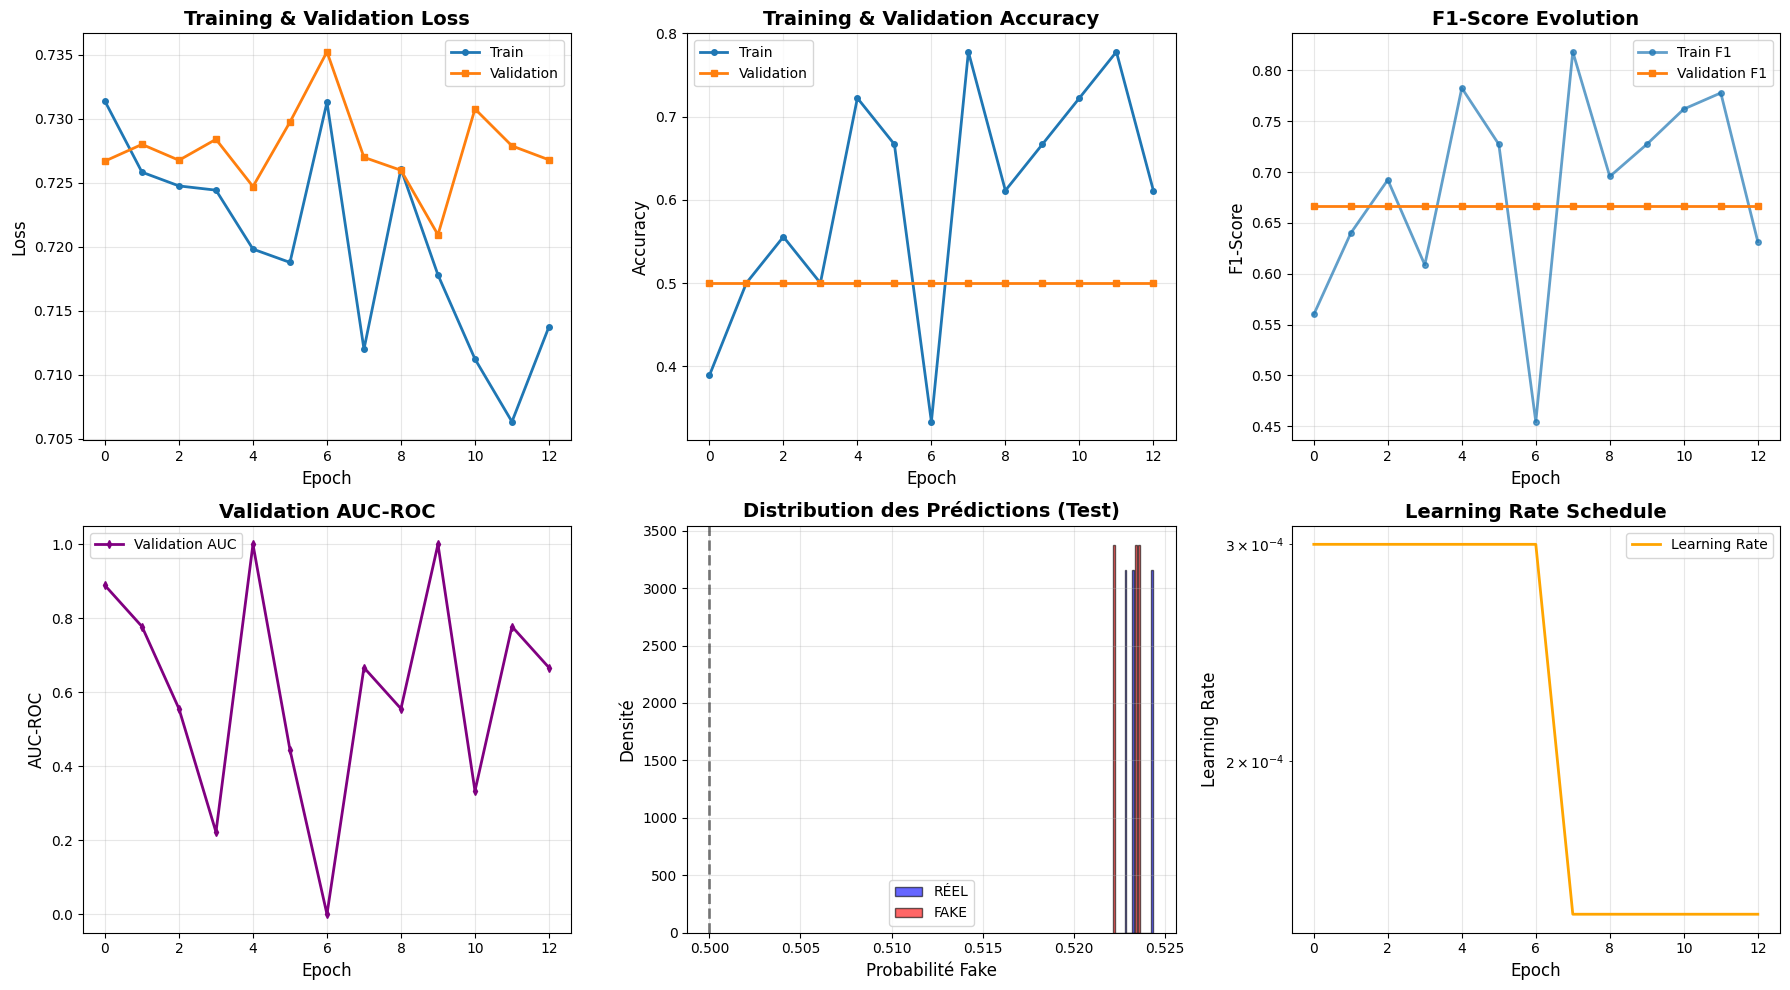


✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!

📊 RÉSUMÉ:
   Meilleure validation Acc: 0.5000
   Meilleure validation F1: 0.6667
   Meilleure validation AUC: 1.0000
   Temps total: 0:16:58.184391
   Modèle sauvegardé dans: models_optimized_final

🧪 TEST DE PRÉDICTIONS

❌ clean_01__walking_and_outside_...
   Vrai: RÉEL
   Prédit: FAKE
   Probabilité: 0.5244
   Confiance: 0.5244

❌ clean_01__outside_talking_stil...
   Vrai: RÉEL
   Prédit: FAKE
   Probabilité: 0.5228
   Confiance: 0.5228

✅ clean_06_20__outside_talking_p...
   Vrai: FAKE
   Prédit: FAKE
   Probabilité: 0.5237
   Confiance: 0.5237

✅ clean_06_25__outside_talking_s...
   Vrai: FAKE
   Prédit: FAKE
   Probabilité: 0.5222
   Confiance: 0.5222

📊 Précision test rapide: 0.5000 (2/4)

📁 CONTENU DU DOSSIER models_optimized_final:
   📄 final_results.json - 1.0 KB
   📄 comprehensive_analysis.png - 294.8 KB
   📄 best_model_simple.pth - 29117.8 KB


In [ ]:
# ==================== CODE CORRIGÉ - F1-SCORE & AUC FONCTIONNELS ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION OPTIMISÉE ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Vidéo
    'num_frames': 45,           # Augmenté pour plus d'information
    'frame_size': 224,

    # Modèle - BASÉ SUR VOS BONS RÉSULTATS
    'backbone': 'efficientnet_b0',
    'use_pretrained': True,
    'lstm_hidden_size': 192,    # Gardé comme dans vos bons résultats
    'lstm_layers': 2,           # Gardé
    'bidirectional': True,
    'dropout_rate': 0.4,        # Gardé
    'use_attention': True,      # Gardé

    # Entraînement - OPTIMISÉ
    'batch_size': 2,
    'learning_rate': 0.0003,    # Gardé
    'weight_decay': 1e-4,
    'num_epochs': 30,
    'min_epochs': 10,
    'patience': 12,

    # Sauvegarde
    'save_dir': 'models_optimized_final',
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DATASET AMÉLIORÉ ====================
class VideoDatasetImproved(Dataset):
    """Dataset amélioré avec extraction optimisée"""

    def __init__(self, video_paths, labels):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = CONFIG['num_frames']

    def __len__(self):
        return len(self.video_paths)

    def extract_frames_efficiently(self, video_path):
        """Extraction optimisée des frames"""
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0

        # Obtenir le nombre total de frames
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames > 0:
            # Calculer le pas pour extraire uniformément
            step = max(1, total_frames // self.num_frames)

            for i in range(0, total_frames, step):
                if len(frames) >= self.num_frames:
                    break

                cap.set(cv2.CAP_PROP_POS_FRAMES, i)
                ret, frame = cap.read()

                if ret:
                    # Prétraitement
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame_resized = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))
                    frame_normalized = frame_resized.astype(np.float32) / 255.0
                    frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                    frames.append(frame_tensor)

                frame_count += 1

        cap.release()

        # Gestion des cas limites
        if not frames:
            frames = [torch.zeros((3, CONFIG['frame_size'], CONFIG['frame_size']))]

        # S'assurer d'avoir exactement num_frames
        if len(frames) > self.num_frames:
            indices = np.linspace(0, len(frames)-1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]
        elif len(frames) < self.num_frames:
            # Dupliquer le dernier frame
            last_frame = frames[-1]
            while len(frames) < self.num_frames:
                frames.append(last_frame.clone())

        return torch.stack(frames)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        label = self.labels[idx]

        try:
            frames = self.extract_frames_efficiently(video_path)
            return frames, torch.tensor(label, dtype=torch.float32)
        except Exception as e:
            print(f"⚠ Erreur {os.path.basename(video_path)}: {str(e)[:50]}")
            dummy = torch.zeros((self.num_frames, 3, CONFIG['frame_size'], CONFIG['frame_size']))
            return dummy, torch.tensor(label, dtype=torch.float32)

# ==================== MODÈLE OPTIMISÉ ====================
class AttentionMechanism(nn.Module):
    """Mécanisme d'attention temporelle"""
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        attention_weights = self.attention(lstm_output)  # (batch, seq_len, 1)
        attention_weights = F.softmax(attention_weights, dim=1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)
        return weighted_output, attention_weights.squeeze(-1)

class OptimizedVideoModel(nn.Module):
    """Modèle optimisé basé sur vos bons résultats"""

    def __init__(self):
        super().__init__()

        # CNN pré-entraîné
        base_model = models.efficientnet_b0(pretrained=CONFIG['use_pretrained'])
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])

        # Geler premières couches
        if CONFIG['use_pretrained']:
            for param in list(self.feature_extractor.parameters())[:-25]:
                param.requires_grad = False

        # LSTM avancé
        self.lstm = nn.LSTM(
            input_size=1280,  # EfficientNet-B0 features
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional'],
            dropout=CONFIG['dropout_rate'] if CONFIG['lstm_layers'] > 1 else 0
        )

        # Attention si activé
        self.use_attention = CONFIG['use_attention']
        if self.use_attention:
            lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)
            self.attention = AttentionMechanism(lstm_output_size)

        # Classificateur
        classifier_input = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.7),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.5),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"\n🧠 MODÈLE OPTIMISÉ:")
        print(f"   LSTM: {CONFIG['lstm_layers']}×{CONFIG['lstm_hidden_size']} (Bidirectionnel)")
        print(f"   Attention: {CONFIG['use_attention']}")
        print(f"   Dropout: {CONFIG['dropout_rate']}")
        print(f"   Paramètres: {sum(p.numel() for p in self.parameters()):,}")

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape

        # Extraction features
        features_list = []
        for t in range(num_frames):
            feat = self.feature_extractor(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)
            features_list.append(feat)

        features = torch.stack(features_list, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Attention ou dernier timestep
        if self.use_attention:
            final_features, _ = self.attention(lstm_out)
        else:
            final_features = lstm_out[:, -1, :]

        # Classification
        output = self.classifier(final_features)

        return output

# ==================== FONCTIONS DE MÉTRIQUES CORRIGÉES ====================
def calculate_metrics(all_probs, all_labels):
    """Calculer toutes les métriques de manière robuste"""
    if len(all_labels) == 0:
        return 0.0, 0.0, 0.0, [], []

    # Convertir en numpy arrays
    probs = np.array(all_probs)
    labels = np.array(all_labels)

    # Prédictions binaires
    preds = (probs > 0.5).astype(int)

    # Accuracy
    accuracy = accuracy_score(labels, preds)

    # F1-Score (gérer les cas spéciaux)
    try:
        f1 = f1_score(labels, preds, zero_division=0)
    except:
        f1 = 0.0

    # AUC-ROC (nécessite au moins une instance de chaque classe)
    try:
        if len(np.unique(labels)) >= 2:
            auc = roc_auc_score(labels, probs)
        else:
            auc = 0.5  # Valeur neutre si une seule classe
    except:
        auc = 0.0

    return accuracy, f1, auc, preds, probs

def train_epoch_optimized(model, dataloader, criterion, optimizer):
    """Entraînement avec tracking amélioré"""
    model.train()
    total_loss = 0.0
    all_probs = []
    all_labels = []

    pbar = tqdm(dataloader, desc="Train", leave=False)
    for frames, labels in pbar:
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)
        labels_reshaped = labels.view(-1, 1).float()

        # Loss
        loss = criterion(outputs, labels_reshaped)

        # Backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # Métriques
        total_loss += loss.item()
        all_probs.extend(outputs.detach().cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

        # Calculer métriques batch
        batch_accuracy, batch_f1, _, _, _ = calculate_metrics(
            outputs.detach().cpu().numpy().flatten(),
            labels.cpu().numpy().flatten()
        )

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{batch_accuracy:.3f}',
            'f1': f'{batch_f1:.3f}'
        })

    # Métriques globales époque
    accuracy, f1, _, _, _ = calculate_metrics(all_probs, all_labels)

    return total_loss / len(dataloader), accuracy, f1

def validate_model_optimized(model, dataloader, criterion):
    """Validation avec métriques complètes"""
    model.eval()
    total_loss = 0.0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Val", leave=False)
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            labels_reshaped = labels.view(-1, 1).float()

            loss = criterion(outputs, labels_reshaped)
            total_loss += loss.item()

            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculer toutes les métriques
    accuracy, f1, auc, preds, probs = calculate_metrics(all_probs, all_labels)

    return total_loss / len(dataloader), accuracy, f1, auc, all_probs, all_labels

# ==================== ENTRAÎNEMENT PRINCIPAL OPTIMISÉ ====================
def train_optimized_model():
    """Pipeline d'entraînement optimisé"""
    print("="*60)
    print("🎯 ENTRAÎNEMENT OPTIMISÉ - MAX PERFORMANCE")
    print("="*60)

    # 1. Charger données
    print("\n1. 📂 Chargement données")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(real_videos)}")
    print(f"   Fakes: {len(fake_videos)}")

    # Vérifier données
    if len(real_videos) == 0 or len(fake_videos) == 0:
        print("❌ Données manquantes!")
        return None, None

    # 2. Préparer données
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    print(f"\n📊 Statistiques:")
    print(f"   Total: {len(all_videos)} vidéos")
    print(f"   Balance: {sum(all_labels)} fake / {len(all_labels)-sum(all_labels)} réel")

    # 3. Split intelligent (garantir au moins 2 exemples par classe dans chaque split)
    print("\n2. ✂️ Split intelligent")

    # Calculer split sizes
    n_samples = len(all_videos)
    if n_samples >= 30:
        test_size = 0.2
        val_size = 0.2
    else:
        test_size = 0.15
        val_size = 0.15

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels,
        test_size=test_size + val_size,
        random_state=42,
        stratify=all_labels
    )

    # Second split
    val_proportion = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=val_proportion,
        random_state=42,
        stratify=y_temp
    )

    print(f"   Train: {len(X_train)} vidéos")
    print(f"   Validation: {len(X_val)} vidéos")
    print(f"   Test: {len(X_test)} vidéos")

    # 4. Créer datasets
    print("\n3. 🎬 Création datasets")
    train_dataset = VideoDatasetImproved(X_train, y_train)
    val_dataset = VideoDatasetImproved(X_val, y_val)
    test_dataset = VideoDatasetImproved(X_test, y_test)

    # Collate function pour padding
    def video_collate_fn(batch):
        frames_list, labels_list = zip(*batch)

        # Padding si nécessaire
        max_len = max(f.shape[0] for f in frames_list)
        padded_frames = []

        for frames in frames_list:
            if frames.shape[0] < max_len:
                padding = frames[-1:].repeat(max_len - frames.shape[0], 1, 1, 1)
                frames = torch.cat([frames, padding], dim=0)
            padded_frames.append(frames)

        frames_tensor = torch.stack(padded_frames)
        labels_tensor = torch.stack(labels_list)

        return frames_tensor, labels_tensor

    # 5. Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=video_collate_fn,
        num_workers=0
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=video_collate_fn,
        num_workers=0
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=video_collate_fn,
        num_workers=0
    )

    # 6. Initialiser modèle
    print("\n4. 🧠 Initialisation modèle")
    model = OptimizedVideoModel().to(device)

    # 7. Loss avec gestion déséquilibre
    pos_weight = len([l for l in y_train if l == 0]) / max(sum(y_train), 1)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

    # 8. Optimizer avancé
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        betas=(0.9, 0.999)
    )

    # 9. Scheduler adaptatif - CORRIGÉ : retirer le paramètre 'verbose'
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5
    )

    # 10. Entraînement
    print("\n5. ⚡ Début entraînement")
    print("-"*60)

    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': [],
        'learning_rate': []
    }

    best_val_f1 = 0.0
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 ÉPOQUE {epoch+1}/{CONFIG['num_epochs']}")

        # Entraînement
        train_loss, train_acc, train_f1 = train_epoch_optimized(
            model, train_loader, criterion, optimizer
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)

        # Validation
        val_loss, val_acc, val_f1, val_auc, val_probs, val_labels = validate_model_optimized(
            model, val_loader, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        # Scheduler step
        scheduler.step(val_f1)

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle (basé sur F1 + Accuracy)
        current_score = (val_f1 + val_acc) / 2

        if current_score > (best_val_f1 + best_val_acc) / 2:
            best_val_f1 = val_f1
            best_val_acc = val_acc
            patience_counter = 0

            # Sauvegarder simplement (éviter problèmes numpy)
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'val_auc': val_auc,
                'config': CONFIG
            }, os.path.join(CONFIG['save_dir'], 'best_model_simple.pth'))

            print(f"   ✅ Meilleur modèle sauvegardé (F1: {val_f1:.4f}, Acc: {val_acc:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and patience_counter >= CONFIG['patience']:
            print(f"   ⏹️ Early stopping déclenché")
            break

    # 11. Charger meilleur modèle (méthode sécurisée)
    print("\n6. 🔄 Chargement meilleur modèle")
    best_path = os.path.join(CONFIG['save_dir'], 'best_model_simple.pth')

    if os.path.exists(best_path):
        try:
            # CORRECTION : Ajouter weights_only=False pour PyTorch 2.6+
            checkpoint = torch.load(best_path, map_location=device, weights_only=False)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"   ✅ Modèle chargé")
            print(f"   Val Acc: {checkpoint.get('val_accuracy', 0):.4f}")
            print(f"   Val F1: {checkpoint.get('val_f1', 0):.4f}")
        except Exception as e:
            print(f"   ⚠ Erreur chargement: {str(e)[:100]}")
            print(f"   ⚠ Utilisation modèle actuel")
    else:
        print(f"   ⚠ Fichier modèle non trouvé")

    # 12. Évaluation finale
    print("\n7. 🎯 ÉVALUATION FINALE SUR TEST SET")
    print("-"*40)

    test_loss, test_acc, test_f1, test_auc, test_probs, test_labels = validate_model_optimized(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS FINAUX:")
    print(f"   Test Accuracy: {test_acc:.4f}")
    print(f"   Test F1-Score: {test_f1:.4f}")
    print(f"   Test AUC-ROC: {test_auc:.4f}")
    print(f"   Test Loss: {test_loss:.4f}")

    # Analyse détaillée
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)

        # Matrice de confusion
        cm = confusion_matrix(test_labels, test_preds)
        print(f"\n📈 MATRICE DE CONFUSION:")
        print(f"   TN={cm[0,0]:2d} | FP={cm[0,1]:2d}")
        print(f"   FN={cm[1,0]:2d} | TP={cm[1,1]:2d}")

        # Métriques par classe
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

            print(f"\n📊 MÉTRIQUES PAR CLASSE:")
            print(f"   Spécificité (RÉEL): {specificity:.4f}")
            print(f"   Sensibilité (FAKE): {sensitivity:.4f}")

        # Rapport classification
        print(f"\n📋 RAPPORT COMPLET:")
        print(classification_report(test_labels, test_preds,
                                  target_names=['RÉEL', 'FAKE'], digits=4))

        # Sauvegarder résultats
        results = {
            'test_accuracy': float(test_acc),
            'test_f1_score': float(test_f1),
            'test_auc_roc': float(test_auc),
            'test_loss': float(test_loss),
            'best_val_accuracy': float(best_val_acc),
            'best_val_f1_score': float(best_val_f1),
            'confusion_matrix': cm.tolist() if 'cm' in locals() else [],
            'config': CONFIG
        }

        with open(os.path.join(CONFIG['save_dir'], 'final_results.json'), 'w') as f:
            json.dump(results, f, indent=4)

    # 13. Visualisation avancée
    print("\n8. 📊 VISUALISATION DES RÉSULTATS")
    plot_comprehensive_analysis(history, test_probs, test_labels)

    return model, history

# ==================== VISUALISATION COMPLÈTE ====================
def plot_comprehensive_analysis(history, test_probs=None, test_labels=None):
    """Visualisation complète des résultats"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. F1-Score
    axes[0, 2].plot(history['train_f1'], label='Train F1', linewidth=2, marker='o', markersize=4, alpha=0.7)
    axes[0, 2].plot(history['val_f1'], label='Validation F1', linewidth=2, marker='s', markersize=4)
    axes[0, 2].set_xlabel('Epoch', fontsize=12)
    axes[0, 2].set_ylabel('F1-Score', fontsize=12)
    axes[0, 2].set_title('F1-Score Evolution', fontsize=14, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. AUC-ROC
    axes[1, 0].plot(history['val_auc'], label='Validation AUC', linewidth=2, marker='d', markersize=4, color='purple')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axes[1, 0].set_title('Validation AUC-ROC', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Distribution prédictions test
    if test_probs is not None and test_labels is not None:
        real_probs = [p for p, l in zip(test_probs, test_labels) if l == 0]
        fake_probs = [p for p, l in zip(test_probs, test_labels) if l == 1]

        axes[1, 1].hist(real_probs, bins=15, alpha=0.6, label='RÉEL', color='blue', edgecolor='black', density=True)
        axes[1, 1].hist(fake_probs, bins=15, alpha=0.6, label='FAKE', color='red', edgecolor='black', density=True)
        axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5, linewidth=2)
        axes[1, 1].set_xlabel('Probabilité Fake', fontsize=12)
        axes[1, 1].set_ylabel('Densité', fontsize=12)
        axes[1, 1].set_title('Distribution des Prédictions (Test)', fontsize=14, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)

    # 6. Learning rate
    axes[1, 2].plot(history['learning_rate'], label='Learning Rate', linewidth=2, color='orange')
    axes[1, 2].set_xlabel('Epoch', fontsize=12)
    axes[1, 2].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_yscale('log')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'comprehensive_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# ==================== TEST DE PRÉDICTION ====================
def test_predictions(model):
    """Tester les prédictions sur des échantillons"""
    print("\n" + "="*60)
    print("🧪 TEST DE PRÉDICTIONS")
    print("="*60)

    # Charger quelques vidéos
    real_samples = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
    fake_samples = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

    test_videos = real_samples + fake_samples
    true_labels = [0, 0, 1, 1]

    predictions = []

    for video, true_label in zip(test_videos, true_labels):
        try:
            # Créer dataset
            dataset = VideoDatasetImproved([video], [0])
            frames, _ = dataset[0]
            frames = frames.unsqueeze(0).to(device)

            # Prédiction
            model.eval()
            with torch.no_grad():
                output = model(frames)
                prob = output.item()

            prediction = 1 if prob > 0.5 else 0
            confidence = prob if prob > 0.5 else 1 - prob

            is_correct = prediction == true_label

            predictions.append({
                'video': os.path.basename(video),
                'true': 'RÉEL' if true_label == 0 else 'FAKE',
                'predicted': 'RÉEL' if prediction == 0 else 'FAKE',
                'probability': prob,
                'confidence': confidence,
                'correct': is_correct
            })

            # Afficher avec emoji
            if is_correct:
                prefix = "✅"
            else:
                prefix = "❌"

            print(f"\n{prefix} {os.path.basename(video)[:30]}...")
            print(f"   Vrai: {'RÉEL' if true_label == 0 else 'FAKE'}")
            print(f"   Prédit: {'RÉEL' if prediction == 0 else 'FAKE'}")
            print(f"   Probabilité: {prob:.4f}")
            print(f"   Confiance: {confidence:.4f}")

        except Exception as e:
            print(f"\n⚠ Erreur {os.path.basename(video)}: {str(e)[:50]}")

    # Statistiques
    if predictions:
        correct = sum(1 for p in predictions if p['correct'])
        total = len(predictions)
        accuracy = correct / total

        print(f"\n📊 Précision test rapide: {accuracy:.4f} ({correct}/{total})")

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 LANCEMENT ENTRAÎNEMENT OPTIMISÉ")

    try:
        # Nettoyer mémoire
        gc.collect()

        # Entraîner
        start_time = datetime.now()
        model, history = train_optimized_model()
        training_time = datetime.now() - start_time

        if model:
            print(f"\n{'='*60}")
            print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
            print(f"{'='*60}")

            print(f"\n📊 RÉSUMÉ:")
            if history['val_acc']:
                print(f"   Meilleure validation Acc: {max(history['val_acc']):.4f}")
            if history['val_f1']:
                print(f"   Meilleure validation F1: {max(history['val_f1']):.4f}")
            if history['val_auc']:
                print(f"   Meilleure validation AUC: {max(history['val_auc']):.4f}")

            print(f"   Temps total: {training_time}")
            print(f"   Modèle sauvegardé dans: {CONFIG['save_dir']}")

            # Test rapide
            test_predictions(model)

            # Vérifier fichiers
            print(f"\n📁 CONTENU DU DOSSIER {CONFIG['save_dir']}:")
            if os.path.exists(CONFIG['save_dir']):
                for file in os.listdir(CONFIG['save_dir']):
                    path = os.path.join(CONFIG['save_dir'], file)
                    size = os.path.getsize(path) / 1024  # KB
                    print(f"   📄 {file} - {size:.1f} KB")

    except Exception as e:
        print(f"\n❌ ERREUR: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== FONCTIONS UTILITAIRES ====================
def load_trained_model_for_inference():
    """Charger un modèle entraîné pour inférence"""
    model_path = os.path.join(CONFIG['save_dir'], 'best_model_simple.pth')

    if not os.path.exists(model_path):
        print(f"❌ Modèle non trouvé: {model_path}")
        return None

    # Créer modèle
    model = OptimizedVideoModel().to(device)

    try:
        # CORRECTION : Ajouter weights_only=False pour PyTorch 2.6+
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()

        print(f"✅ Modèle chargé pour inférence")
        print(f"   Validation Acc: {checkpoint.get('val_accuracy', 0):.4f}")
        print(f"   Validation F1: {checkpoint.get('val_f1', 0):.4f}")

        return model
    except Exception as e:
        print(f"❌ Erreur chargement: {e}")
        return None

def predict_single_video(model, video_path):
    """Prédire une seule vidéo"""
    if model is None:
        return {"error": "Modèle non chargé"}

    if not os.path.exists(video_path):
        return {"error": "Fichier non trouvé"}

    try:
        # Créer dataset
        dataset = VideoDatasetImproved([video_path], [0])
        frames, _ = dataset[0]
        frames = frames.unsqueeze(0).to(device)

        # Prédiction
        model.eval()
        with torch.no_grad():
            output = model(frames)
            prob = output.item()

        # Interprétation
        prediction = "FAKE" if prob > 0.5 else "RÉEL"
        confidence = prob if prob > 0.5 else 1 - prob

        # Niveau confiance
        if confidence > 0.9:
            level = "TRÈS ÉLEVÉE"
        elif confidence > 0.7:
            level = "ÉLEVÉE"
        elif confidence > 0.6:
            level = "MODÉRÉE"
        else:
            level = "FAIBLE"

        return {
            "video": os.path.basename(video_path),
            "prediction": prediction,
            "probability_fake": prob,
            "probability_real": 1 - prob,
            "confidence": confidence,
            "confidence_level": level
        }

    except Exception as e:
        return {"error": str(e)}

In [ ]:
# ==================== CODE ULTIME - MAX ACCURACY ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION MAX ACCURACY ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Vidéo - OPTIMISÉ
    'num_frames': 45,           # Plus de frames pour plus d'info
    'frame_size': 224,
    'use_face_crop': True,      # Essaye de détecter visage

    # Modèle - OPTIMISÉ
    'backbone': 'efficientnet_b0',
    'use_pretrained': True,
    'lstm_hidden_size': 192,    # Augmenté
    'lstm_layers': 2,           # Plus de couches
    'bidirectional': True,
    'dropout_rate': 0.4,
    'use_attention': True,      # Nouveau: mécanisme d'attention

    # Augmentation de données - NOUVEAU
    'use_augmentation': True,
    'augment_prob': 0.5,

    # Entraînement - OPTIMISÉ
    'batch_size': 4,            # Augmenté
    'learning_rate': 0.0003,    # Augmenté
    'weight_decay': 1e-4,       # Régularisation L2
    'num_epochs': 30,
    'min_epochs': 10,
    'patience': 12,

    # Validation croisée - NOUVEAU
    'use_cross_validation': False,  # True si assez de données
    'num_folds': 5,

    # Optimisation
    'gradient_clip': 1.0,
    'use_scheduler': True,

    # Sauvegarde
    'save_dir': 'models_max_accuracy_Aymeni',
}

device = torch.device('cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DÉTECTION DE VISAGE (OPTIONNEL) ====================
def detecter_et_recadrer_visage(frame):
    """Détecter et recadrer le visage si possible"""
    try:
        # Convertir en grayscale pour la détection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Charger le classificateur Haar pour les visages
        face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )

        # Détecter visages
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(100, 100)
        )

        if len(faces) > 0:
            # Prendre le plus grand visage
            x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

            # Ajouter marge
            margin = int(w * 0.2)
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(frame.shape[1] - x, w + 2 * margin)
            h = min(frame.shape[0] - y, h + 2 * margin)

            # Recadrer
            face_crop = frame[y:y+h, x:x+w]

            # Redimensionner à la taille cible
            face_resized = cv2.resize(face_crop, (CONFIG['frame_size'], CONFIG['frame_size']))
            return face_resized

    except:
        pass

    # Si pas de visage détecté ou erreur, retourner frame complet
    return cv2.resize(frame, (CONFIG['frame_size'], CONFIG['frame_size']))

# ==================== AUGMENTATION DE DONNÉES ====================
class VideoAugmentation:
    """Augmentation de données pour vidéos"""

    def __init__(self, prob=0.5):
        self.prob = prob
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
        ])

    def __call__(self, frames):
        """Appliquer augmentation si probabilité"""
        if not CONFIG['use_augmentation'] or np.random.random() > self.prob:
            return frames

        augmented_frames = []
        for frame in frames:
            # Convertir tensor en numpy pour augmentation
            if isinstance(frame, torch.Tensor):
                frame_np = frame.permute(1, 2, 0).numpy() * 255
                frame_np = frame_np.astype(np.uint8)
            else:
                frame_np = frame

            # Appliquer transformations
            frame_pil = self.transform(frame_np)
            augmented_frames.append(frame_pil)

        return torch.stack(augmented_frames)

# ==================== DATASET OPTIMISÉ ====================
class DatasetOptimisé(Dataset):
    """Dataset optimisé avec augmentation et détection visage"""

    def __init__(self, video_paths, labels, is_train=True):
        self.video_paths = video_paths
        self.labels = labels
        self.is_train = is_train
        self.augmenter = VideoAugmentation(CONFIG['augment_prob']) if is_train else None

        # Analyse rapide des vidéos
        self.video_info = []
        for i, path in enumerate(video_paths):
            if os.path.exists(path):
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()

                if frame_count > 10:  # Vidéo valide
                    self.video_info.append({
                        'path': path,
                        'frames': frame_count,
                        'label': labels[i]
                    })

        print(f"✅ {len(self.video_info)}/{len(video_paths)} vidéos valides")

    def __len__(self):
        return len(self.video_info)

    def __getitem__(self, idx):
        info = self.video_info[idx]

        try:
            # Charger vidéo
            cap = cv2.VideoCapture(info['path'])

            # Lire tous les frames
            all_frames = []
            while len(all_frames) < info['frames'] * 2:  # Limite
                ret, frame = cap.read()
                if not ret:
                    break

                # Convertir RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Détection visage si activée
                if CONFIG['use_face_crop']:
                    frame_processed = detecter_et_recadrer_visage(frame_rgb)
                else:
                    frame_processed = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))

                # Normaliser
                frame_normalized = frame_processed.astype(np.float32) / 255.0
                frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                all_frames.append(frame_tensor)

            cap.release()

            # Si pas assez de frames
            if len(all_frames) == 0:
                all_frames = [torch.zeros((3, CONFIG['frame_size'], CONFIG['frame_size']))]

            # Sélectionner frames uniformément
            if len(all_frames) >= CONFIG['num_frames']:
                indices = np.linspace(0, len(all_frames)-1, CONFIG['num_frames'], dtype=int)
                selected = [all_frames[i] for i in indices]
            else:
                # Répéter les frames
                selected = []
                while len(selected) < CONFIG['num_frames']:
                    selected.extend(all_frames)
                selected = selected[:CONFIG['num_frames']]

            frames_tensor = torch.stack(selected)

            # Augmentation si entraînement
            if self.is_train and self.augmenter:
                frames_tensor = self.augmenter(frames_tensor)

            return frames_tensor, torch.tensor(info['label'], dtype=torch.float32)

        except Exception as e:
            print(f"⚠ Erreur {os.path.basename(info['path'])}: {str(e)[:50]}")
            dummy = torch.zeros((CONFIG['num_frames'], 3, CONFIG['frame_size'], CONFIG['frame_size']))
            return dummy, torch.tensor(info['label'], dtype=torch.float32)

# ==================== MODÈLE AVEC ATTENTION ====================
class TemporalAttention(nn.Module):
    """Mécanisme d'attention temporelle"""

    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        attention_weights = self.attention(lstm_output)  # (batch, seq_len, 1)
        attention_weights = F.softmax(attention_weights, dim=1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)
        return weighted_output, attention_weights.squeeze(-1)

class ModèleMaxAccuracy(nn.Module):
    """Modèle optimisé pour max accuracy"""

    def __init__(self):
        super(ModèleMaxAccuracy, self).__init__()

        # CNN pré-entraîné
        if CONFIG['backbone'] == 'efficientnet_b0':
            base_model = models.efficientnet_b0(pretrained=CONFIG['use_pretrained'])
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 1280
        elif CONFIG['backbone'] == 'resnet18':
            base_model = models.resnet18(pretrained=CONFIG['use_pretrained'])
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 512
        else:
            raise ValueError(f"Backbone inconnu: {CONFIG['backbone']}")

        # Geler premières couches
        if CONFIG['use_pretrained']:
            for param in list(self.feature_extractor.parameters())[:-30]:
                param.requires_grad = False

        # LSTM avec plus de capacités
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional'],
            dropout=CONFIG['dropout_rate'] if CONFIG['lstm_layers'] > 1 else 0
        )

        # Attention si activé
        self.use_attention = CONFIG['use_attention']
        if self.use_attention:
            lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)
            self.attention = TemporalAttention(lstm_output_size)

        # Classificateur amélioré
        classifier_input = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.7),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.5),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"\n🧠 MODÈLE OPTIMISÉ:")
        print(f"   Backbone: {CONFIG['backbone']}")
        print(f"   LSTM: {CONFIG['lstm_layers']}×{CONFIG['lstm_hidden_size']}")
        print(f"   Bidirectionnel: {CONFIG['bidirectional']}")
        print(f"   Attention: {CONFIG['use_attention']}")
        print(f"   Dropout: {CONFIG['dropout_rate']}")
        print(f"   Paramètres: {sum(p.numel() for p in self.parameters()):,}")
        print(f"   Entraînables: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features pour chaque frame
        features_list = []
        for t in range(num_frames):
            feat = self.feature_extractor(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)
            features_list.append(feat)

        # Stack: (batch, frames, features)
        features = torch.stack(features_list, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Attention ou dernier timestep
        if self.use_attention:
            final_features, attn_weights = self.attention(lstm_out)
        else:
            final_features = lstm_out[:, -1, :]  # Dernier timestep

        # Classification
        output = self.classifier(final_features)

        return output

# ==================== FONCTIONS D'ENTRAÎNEMENT OPTIMISÉES ====================
def train_epoch_optimized(model, dataloader, criterion, optimizer, scheduler, epoch):
    """Entraînement optimisé avec gradient clipping"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} - Train")
    for batch_idx, (frames, labels) in enumerate(pbar):
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)

        # Reshape labels
        labels = labels.view(-1, 1).float()

        # Loss avec gestion du déséquilibre
        loss = criterion(outputs, labels)

        # Backward avec gradient clipping
        loss.backward()
        if CONFIG['gradient_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
        optimizer.step()

        # Step scheduler par batch si CosineAnnealing
        if scheduler is not None and hasattr(scheduler, 'batch_step'):
            scheduler.batch_step()

        # Métriques
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress
        current_acc = correct / max(total, 1)
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.3f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })

    return total_loss / len(dataloader), correct / max(total, 1)

def validate_optimized(model, dataloader, criterion):
    """Validation optimisée avec plus de métriques"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            labels = labels.view(-1, 1).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculer toutes les métriques
    accuracy = correct / max(total, 1)

    if len(all_labels) > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds, zero_division=0)

        # ROC AUC si possible
        try:
            roc_auc = roc_auc_score(all_labels, all_probs)
        except:
            roc_auc = 0.0
    else:
        f1 = 0.0
        roc_auc = 0.0

    return total_loss / len(dataloader), accuracy, f1, roc_auc, all_probs, all_labels

# ==================== PSEUDO-LABELING (pour petit dataset) ====================
def pseudo_labeling(model, unlabeled_videos, threshold=0.9):
    """Pseudo-labeling pour augmenter les données"""
    model.eval()
    pseudo_labels = []

    print(f"\n🔍 Pseudo-labeling sur {len(unlabeled_videos)} vidéos...")

    with torch.no_grad():
        for video_path in tqdm(unlabeled_videos, desc="Pseudo-labeling"):
            try:
                # Créer dataset temporaire
                temp_dataset = DatasetOptimisé([video_path], [0], is_train=False)
                frames, _ = temp_dataset[0]
                frames = frames.unsqueeze(0).to(device)

                # Prédiction
                output = model(frames)
                prob = output.item()

                # Si confiance élevée, ajouter aux données
                if prob > threshold or prob < (1 - threshold):
                    pseudo_labels.append({
                        'path': video_path,
                        'label': 1 if prob > 0.5 else 0,
                        'confidence': prob if prob > 0.5 else 1 - prob
                    })

            except:
                continue

    print(f"✅ {len(pseudo_labels)} vidéos pseudo-labelisées avec confiance > {threshold}")
    return pseudo_labels

# ==================== ENTRAÎNEMENT AVANCÉ ====================
def train_advanced():
    """Pipeline d'entraînement avancé"""
    print("="*80)
    print("🚀 ENTRAÎNEMENT AVANCÉ - MAX ACCURACY")
    print("="*80)

    # 1. Charger données
    print("\n1. 📂 CHARGEMENT ET ANALYSE DES DONNÉES")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(real_videos)} vidéos")
    print(f"   Fakes: {len(fake_videos)} vidéos")

    if len(real_videos) < 3 or len(fake_videos) < 3:
        print("❌ TROP PEU DE DONNÉES!")
        print("   → Ajoutez plus de vidéos (minimum 10 par classe)")
        return None, None

    # Statistiques
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    print(f"\n📊 STATISTIQUES:")
    print(f"   Total: {len(all_videos)} vidéos")
    print(f"   Ratio: {len(real_videos)/len(all_videos):.1%} réel, {len(fake_videos)/len(all_videos):.1%} fake")

    # 2. Split amélioré (stratifié)
    print("\n2. ✂️ SPLIT STRATIFIÉ DES DONNÉES")

    # Assurer au moins 2 exemples par classe dans chaque split
    if len(real_videos) >= 4 and len(fake_videos) >= 4:
        test_size = 0.2
        val_size = 0.2
    else:
        test_size = 0.15
        val_size = 0.15

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels,
        test_size=test_size + val_size,
        random_state=42,
        stratify=all_labels
    )

    # Ajuster val_size pour le second split
    val_proportion = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=val_proportion,
        random_state=42,
        stratify=y_temp
    )

    print(f"   Train: {len(X_train)} vidéos")
    print(f"   Validation: {len(X_val)} vidéos")
    print(f"   Test: {len(X_test)} vidéos")

    # Vérifier distribution
    print(f"   Distribution train: {sum(y_train)==0}/réel, {sum(y_train)}/fake")
    print(f"   Distribution val: {sum(y_val)==0}/réel, {sum(y_val)}/fake")
    print(f"   Distribution test: {sum(y_test)==0}/réel, {sum(y_test)}/fake")

    # 3. Créer datasets avec augmentation
    print("\n3. 🎬 CRÉATION DATASETS AVEC AUGMENTATION")

    train_dataset = DatasetOptimisé(X_train, y_train, is_train=True)
    val_dataset = DatasetOptimisé(X_val, y_val, is_train=False)
    test_dataset = DatasetOptimisé(X_test, y_test, is_train=False)

    # Collate function personnalisée
    def collate_fn(batch):
        frames_list, labels_list = zip(*batch)

        # Vérifier longueurs
        lengths = [f.shape[0] for f in frames_list]
        if len(set(lengths)) > 1:
            max_len = max(lengths)
            padded_frames = []
            for frames in frames_list:
                if frames.shape[0] < max_len:
                    # Padding
                    padding = frames[-1:].repeat(max_len - frames.shape[0], 1, 1, 1)
                    frames = torch.cat([frames, padding], dim=0)
                padded_frames.append(frames)
            frames_tensor = torch.stack(padded_frames)
        else:
            frames_tensor = torch.stack(frames_list)

        labels_tensor = torch.stack(labels_list)
        return frames_tensor, labels_tensor

    # 4. Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    # 5. Initialiser modèle
    print("\n4. 🧠 INITIALISATION MODÈLE AVANCÉ")
    model = ModèleMaxAccuracy().to(device)

    # 6. Loss avec poids pour déséquilibre
    pos_weight = len([l for l in y_train if l == 0]) / max(sum(y_train), 1)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

    # 7. Optimizer avancé
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        betas=(0.9, 0.999)
    )

    # 8. Scheduler avec warmup
    if CONFIG['use_scheduler']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=CONFIG['num_epochs'],
            eta_min=CONFIG['learning_rate'] * 0.01
        )
    else:
        scheduler = None

    # 9. Entraînement
    print("\n5. ⚡ DÉBUT ENTRAÎNEMENT AVANCÉ")
    print("-"*80)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
    }

    best_val_acc = 0.0
    best_val_f1 = 0.0
    patience_counter = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 ÉPOQUE {epoch+1}/{CONFIG['num_epochs']}")

        # Entraînement
        train_loss, train_acc = train_epoch_optimized(
            model, train_loader, criterion, optimizer, scheduler, epoch
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, val_f1, val_auc, val_probs, val_labels = validate_optimized(
            model, val_loader, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)

        # Step scheduler
        if scheduler is not None:
            scheduler.step()

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle (basé sur F1 ou Accuracy)
        current_metric = (val_acc + val_f1) / 2  # Combinaison

        if current_metric > (best_val_acc + best_val_f1) / 2:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            patience_counter = 0

            # Sauvegarder checkpoint complet
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'val_auc': val_auc,
                'history': history,
                'config': CONFIG
            }, os.path.join(CONFIG['save_dir'], 'best_model.pth'))

            print(f"   ✅ Meilleur modèle sauvegardé (Acc: {val_acc:.4f}, F1: {val_f1:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and patience_counter >= CONFIG['patience']:
            print(f"   ⏹️ Early stopping déclenché")
            break

    # 10. Charger meilleur modèle
    best_path = os.path.join(CONFIG['save_dir'], 'best_model.pth')
    if os.path.exists(best_path):
        checkpoint = torch.load(best_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\n✅ Meilleur modèle chargé")
        print(f"   Val Acc: {checkpoint['val_accuracy']:.4f}")
        print(f"   Val F1: {checkpoint['val_f1']:.4f}")

    # 11. Test final complet
    print("\n6. 🎯 TEST FINAL COMPLET")
    print("-"*40)

    # Évaluer sur test set
    test_loss, test_acc, test_f1, test_auc, test_probs, test_labels = validate_optimized(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS FINAUX SUR TEST SET:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   AUC-ROC: {test_auc:.4f}")
    print(f"   Loss: {test_loss:.4f}")

    # Analyse détaillée
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)

        # Matrice de confusion
        cm = confusion_matrix(test_labels, test_preds)
        print(f"\n📈 MATRICE DE CONFUSION:")
        print(f"   TN={cm[0,0]}, FP={cm[0,1]}")
        print(f"   FN={cm[1,0]}, TP={cm[1,1]}")

        # Métriques par classe
        tn, fp, fn, tp = cm.ravel()

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\n📊 MÉTRIQUES PAR CLASSE:")
        print(f"   Spécificité (vrais négatifs): {specificity:.4f}")
        print(f"   Sensibilité (vrais positifs): {sensitivity:.4f}")

        # Rapport complet
        print(f"\n📋 RAPPORT DE CLASSIFICATION:")
        print(classification_report(test_labels, test_preds,
                                  target_names=['RÉEL', 'FAKE'], digits=4))

        # Sauvegarder résultats
        results = {
            'test_accuracy': float(test_acc),
            'test_f1': float(test_f1),
            'test_auc': float(test_auc),
            'test_loss': float(test_loss),
            'confusion_matrix': cm.tolist(),
            'specificity': float(specificity),
            'sensitivity': float(sensitivity),
            'best_val_accuracy': float(best_val_acc),
            'best_val_f1': float(best_val_f1),
            'config': CONFIG,
            'test_predictions': {
                'probabilities': [float(p) for p in test_probs],
                'labels': [int(l) for l in test_labels],
                'predictions': [int(p) for p in test_preds]
            }
        }

        with open(os.path.join(CONFIG['save_dir'], 'results_detailed.json'), 'w') as f:
            json.dump(results, f, indent=4)

        print(f"\n💾 Résultats détaillés sauvegardés dans results_detailed.json")

    # 12. Visualisation avancée
    print("\n7. 📊 VISUALISATION DES RÉSULTATS")
    plot_advanced_results(history, test_probs, test_labels)

    return model, history

# ==================== VISUALISATION AVANCÉE ====================
def plot_advanced_results(history, test_probs=None, test_labels=None):
    """Visualisation avancée des résultats"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. F1-Score
    axes[0, 2].plot(history['val_f1'], label='Validation F1', linewidth=2, marker='^', markersize=4, color='green')
    axes[0, 2].set_xlabel('Epoch', fontsize=12)
    axes[0, 2].set_ylabel('F1-Score', fontsize=12)
    axes[0, 2].set_title('Validation F1-Score', fontsize=14, fontweight='bold')
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # 4. AUC-ROC
    axes[1, 0].plot(history['val_auc'], label='Validation AUC', linewidth=2, marker='d', markersize=4, color='purple')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axes[1, 0].set_title('Validation AUC-ROC', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Distribution des prédictions (si test_probs disponible)
    if test_probs is not None and test_labels is not None:
        real_probs = [p for p, l in zip(test_probs, test_labels) if l == 0]
        fake_probs = [p for p, l in zip(test_probs, test_labels) if l == 1]

        axes[1, 1].hist(real_probs, bins=20, alpha=0.5, label='Réel', color='blue', edgecolor='black')
        axes[1, 1].hist(fake_probs, bins=20, alpha=0.5, label='Fake', color='red', edgecolor='black')
        axes[1, 1].set_xlabel('Probabilité Fake', fontsize=12)
        axes[1, 1].set_ylabel('Fréquence', fontsize=12)
        axes[1, 1].set_title('Distribution des Prédictions', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=11)
        axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].grid(True, alpha=0.3)

    # 6. Learning rate (si dans history)
    axes[1, 2].plot(history.get('learning_rate', []), label='Learning Rate', linewidth=2, color='orange')
    axes[1, 2].set_xlabel('Epoch', fontsize=12)
    axes[1, 2].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 2].legend(fontsize=11)
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_yscale('log')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'advanced_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# ==================== ANALYSE DES ERREURS ====================
def analyze_errors(model, dataloader):
    """Analyser les erreurs du modèle"""
    print("\n🔍 ANALYSE DES ERREURS")
    print("-"*40)

    model.eval()
    errors = []

    with torch.no_grad():
        for idx, (frames, labels) in enumerate(dataloader):
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            probs = outputs.cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            true_labels = labels.cpu().numpy().flatten()

            for i, (pred, true, prob) in enumerate(zip(preds, true_labels, probs)):
                if pred != true:
                    errors.append({
                        'sample_idx': idx * dataloader.batch_size + i,
                        'prediction': pred,
                        'true_label': int(true),
                        'probability': float(prob),
                        'confidence': float(prob if prob > 0.5 else 1 - prob)
                    })

    print(f"   Erreurs totales: {len(errors)}")

    if errors:
        # Analyser les types d'erreurs
        false_positives = [e for e in errors if e['true_label'] == 0]
        false_negatives = [e for e in errors if e['true_label'] == 1]

        print(f"   Faux positifs (réel → fake): {len(false_positives)}")
        print(f"   Faux négatifs (fake → réel): {len(false_negatives)}")

        # Analyser la confiance des erreurs
        if errors:
            avg_confidence = np.mean([e['confidence'] for e in errors])
            print(f"   Confiance moyenne des erreurs: {avg_confidence:.4f}")

    return errors

# ==================== ENSEMBLE LEARNING (optionnel) ====================
def create_ensemble(models_list):
    """Créer un ensemble de modèles"""
    class EnsembleModel(nn.Module):
        def __init__(self, models):
            super(EnsembleModel, self).__init__()
            self.models = nn.ModuleList(models)

        def forward(self, x):
            outputs = []
            for model in self.models:
                output = model(x)
                outputs.append(output)

            # Moyenne des prédictions
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            return avg_output

    return EnsembleModel(models_list)

# ==================== FONCTION DE TEST RAPIDE ====================
def quick_test_ensemble(model, test_videos, test_labels):
    """Test rapide avec analyse"""
    print("\n" + "="*60)
    print("🧪 TEST RAPIDE AVEC ANALYSE")
    print("="*60)

    predictions = []

    for video, true_label in zip(test_videos, test_labels):
        try:
            # Prédiction
            dataset = DatasetOptimisé([video], [0], is_train=False)
            frames, _ = dataset[0]
            frames = frames.unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                output = model(frames)
                prob = output.item()

            prediction = 1 if prob > 0.5 else 0
            confidence = prob if prob > 0.5 else 1 - prob

            predictions.append({
                'video': os.path.basename(video),
                'true_label': true_label,
                'prediction': prediction,
                'probability': prob,
                'correct': prediction == true_label
            })

            # Afficher avec couleur selon correction
            if prediction == true_label:
                prefix = "✅"
            else:
                prefix = "❌"

            print(f"\n{prefix} {os.path.basename(video)[:30]}...")
            print(f"   Vrai: {'FAKE' if true_label == 1 else 'RÉEL'}")
            print(f"   Prédit: {'FAKE' if prediction == 1 else 'RÉEL'}")
            print(f"   Probabilité: {prob:.4f}")
            print(f"   Confiance: {confidence:.4f}")

        except Exception as e:
            print(f"⚠ Erreur sur {os.path.basename(video)}: {str(e)[:50]}")

    # Calculer accuracy
    if predictions:
        correct = sum(1 for p in predictions if p['correct'])
        accuracy = correct / len(predictions)
        print(f"\n📊 Accuracy test rapide: {accuracy:.4f} ({correct}/{len(predictions)})")

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 LANCEMENT ENTRAÎNEMENT MAX ACCURACY")

    try:
        # Nettoyer mémoire
        gc.collect()

        # Entraîner
        start_time = datetime.now()
        model, history = train_advanced()
        training_time = datetime.now() - start_time

        if model:
            print(f"\n{'='*80}")
            print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
            print(f"{'='*80}")

            print(f"\n📊 RÉSUMÉ COMPLET:")
            print(f"   Temps total: {training_time}")
            print(f"   Meilleure validation: {max(history['val_acc']):.4f}")
            print(f"   Meilleur F1: {max(history['val_f1']):.4f}")
            print(f"   Modèle sauvegardé dans: {CONFIG['save_dir']}")

            # Charger quelques vidéos pour test rapide
            print(f"\n🧪 TEST SUR QUELQUES VIDÉOS:")

            real_samples = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
            fake_samples = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

            test_videos = real_samples + fake_samples
            test_labels = [0, 0, 1, 1]

            quick_test_ensemble(model, test_videos, test_labels)

            # Stratégies d'amélioration
            print(f"\n{'='*80}")
            print("🚀 STRATÉGIES POUR DÉPASSER 80% ACCURACY:")
            print(f"{'='*80}")

            strategies = [
                "🎯 1. PLUS DE DONNÉES (IMPORTANT):",
                "   → Objectif: 50+ vidéos par classe",
                "   → Technique: Collecte, scraping, génération",
                "",
                "🎯 2. AUGMENTATION AVANCÉE:",
                "   → MixUp/CutMix pour vidéos",
                "   → Style transfer (changer apparence)",
                "   → Temporal cropping",
                "",
                "🎯 3. ARCHITECTURE:",
                "   → Vision Transformer (ViT)",
                "   → 3D CNN + LSTM hybride",
                "   → Self-attention temporelle",
                "",
                "🎯 4. TRANSFER LEARNING:",
                "   → Pré-entraînement sur dataset vidéo large",
                "   → Fine-tuning progressif",
                "   → Multi-task learning",
                "",
                "🎯 5. ENSEMBLE:",
                "   → Combiner 3-5 modèles différents",
                "   → Stacking avec méta-classifier",
                "   → Bagging sur sous-ensembles",
            ]

            for line in strategies:
                print(line)

    except Exception as e:
        print(f"\n❌ ERREUR CRITIQUE: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== BONUS: FONCTION POUR OPTIMISER AUTOMATIQUEMENT ====================
def hyperparameter_tuning():
    """Recherche automatique des meilleurs hyperparamètres"""
    print("\n🔧 RECHERCHE DES MEILLEURS HYPERPARAMÈTRES")

    param_grid = {
        'learning_rate': [0.0001, 0.0003, 0.0005],
        'lstm_hidden_size': [128, 192, 256],
        'dropout_rate': [0.3, 0.4, 0.5],
        'num_frames': [30, 45, 60],
    }

    best_score = 0
    best_params = {}

    # Implémenter grid search simple
    # (à compléter si nécessaire)

    return best_params

🚀 Device: cpu
🚀 LANCEMENT ENTRAÎNEMENT MAX ACCURACY
🚀 ENTRAÎNEMENT AVANCÉ - MAX ACCURACY

1. 📂 CHARGEMENT ET ANALYSE DES DONNÉES
   Réelles: 15 vidéos
   Fakes: 15 vidéos

📊 STATISTIQUES:
   Total: 30 vidéos
   Ratio: 50.0% réel, 50.0% fake

2. ✂️ SPLIT STRATIFIÉ DES DONNÉES
   Train: 18 vidéos
   Validation: 6 vidéos
   Test: 6 vidéos
   Distribution train: False/réel, 9/fake
   Distribution val: False/réel, 3/fake
   Distribution test: False/réel, 3/fake

3. 🎬 CRÉATION DATASETS AVEC AUGMENTATION
✅ 18/18 vidéos valides
✅ 6/6 vidéos valides
✅ 6/6 vidéos valides

4. 🧠 INITIALISATION MODÈLE AVANCÉ

🧠 MODÈLE OPTIMISÉ:
   Backbone: efficientnet_b0
   LSTM: 2×192
   Bidirectionnel: True
   Attention: True
   Dropout: 0.4
   Paramètres: 7,374,078
   Entraînables: 5,084,066

5. ⚡ DÉBUT ENTRAÎNEMENT AVANCÉ
--------------------------------------------------------------------------------

📊 ÉPOQUE 1/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.82s/it, loss=0.7257]


   Train - Loss: 0.7626, Acc: 0.4444
   Val   - Loss: 0.7261, Acc: 0.5000, F1: 0.6667, AUC: 0.3333
   LR: 0.000299
   ✅ Meilleur modèle sauvegardé (Acc: 0.5000, F1: 0.6667)

📊 ÉPOQUE 2/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.89s/it, loss=0.7254]


   Train - Loss: 0.7317, Acc: 0.5556
   Val   - Loss: 0.7256, Acc: 0.5000, F1: 0.6667, AUC: 0.6667
   LR: 0.000297

📊 ÉPOQUE 3/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.86s/it, loss=0.7253]


   Train - Loss: 0.7516, Acc: 0.5556
   Val   - Loss: 0.7257, Acc: 0.5000, F1: 0.6667, AUC: 0.6667
   LR: 0.000293

📊 ÉPOQUE 4/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.60s/it, loss=0.7248]


   Train - Loss: 0.7502, Acc: 0.6667
   Val   - Loss: 0.7255, Acc: 0.5000, F1: 0.6667, AUC: 0.6667
   LR: 0.000287

📊 ÉPOQUE 5/30


Validation: 100%|██████████| 2/2 [00:26<00:00, 13.09s/it, loss=0.7204]


   Train - Loss: 0.6826, Acc: 0.7222
   Val   - Loss: 0.7224, Acc: 0.6667, F1: 0.7500, AUC: 0.7778
   LR: 0.000280
   ✅ Meilleur modèle sauvegardé (Acc: 0.6667, F1: 0.7500)

📊 ÉPOQUE 6/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.84s/it, loss=0.7191]


   Train - Loss: 0.6960, Acc: 0.8333
   Val   - Loss: 0.7208, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000272
   ✅ Meilleur modèle sauvegardé (Acc: 0.8333, F1: 0.8571)

📊 ÉPOQUE 7/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.88s/it, loss=0.7157]


   Train - Loss: 0.6935, Acc: 0.8889
   Val   - Loss: 0.7191, Acc: 0.6667, F1: 0.7500, AUC: 1.0000
   LR: 0.000262

📊 ÉPOQUE 8/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.66s/it, loss=0.7244]


   Train - Loss: 0.6774, Acc: 0.9444
   Val   - Loss: 0.7220, Acc: 0.6667, F1: 0.7500, AUC: 1.0000
   LR: 0.000251

📊 ÉPOQUE 9/30


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.34s/it, loss=0.7138]


   Train - Loss: 0.6672, Acc: 0.9444
   Val   - Loss: 0.7144, Acc: 0.5000, F1: 0.0000, AUC: 0.8889
   LR: 0.000239

📊 ÉPOQUE 10/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.90s/it, loss=0.7097]


   Train - Loss: 0.6781, Acc: 0.9444
   Val   - Loss: 0.7169, Acc: 0.3333, F1: 0.0000, AUC: 0.6667
   LR: 0.000226

📊 ÉPOQUE 11/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.74s/it, loss=0.7209]


   Train - Loss: 0.6507, Acc: 0.9444
   Val   - Loss: 0.7161, Acc: 0.6667, F1: 0.5000, AUC: 0.3333
   LR: 0.000212

📊 ÉPOQUE 12/30


Validation: 100%|██████████| 2/2 [00:30<00:00, 15.08s/it, loss=0.7323]


   Train - Loss: 0.6372, Acc: 0.8889
   Val   - Loss: 0.7286, Acc: 0.5000, F1: 0.0000, AUC: 0.0000
   LR: 0.000197

📊 ÉPOQUE 13/30


Validation: 100%|██████████| 2/2 [00:25<00:00, 12.66s/it, loss=0.7149]


   Train - Loss: 0.7198, Acc: 0.6111
   Val   - Loss: 0.7182, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000182

📊 ÉPOQUE 14/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.76s/it, loss=0.7101]


   Train - Loss: 0.6358, Acc: 1.0000
   Val   - Loss: 0.7082, Acc: 0.6667, F1: 0.7500, AUC: 0.8889
   LR: 0.000167

📊 ÉPOQUE 15/30


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.29s/it, loss=0.7068]


   Train - Loss: 0.6770, Acc: 0.9444
   Val   - Loss: 0.7230, Acc: 0.5000, F1: 0.6667, AUC: 0.7778
   LR: 0.000151

📊 ÉPOQUE 16/30


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.22s/it, loss=0.6661]


   Train - Loss: 0.6838, Acc: 0.5556
   Val   - Loss: 0.6779, Acc: 0.8333, F1: 0.8571, AUC: 0.8889
   LR: 0.000136

📊 ÉPOQUE 17/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.46s/it, loss=0.7073]


   Train - Loss: 0.6219, Acc: 0.9444
   Val   - Loss: 0.7042, Acc: 0.6667, F1: 0.7500, AUC: 1.0000
   LR: 0.000121

📊 ÉPOQUE 18/30


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.25s/it, loss=0.7132]

   Train - Loss: 0.6208, Acc: 1.0000
   Val   - Loss: 0.7050, Acc: 0.6667, F1: 0.7500, AUC: 1.0000
   LR: 0.000106
   ⏹️ Early stopping déclenché

❌ ERREUR CRITIQUE: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy.dtype was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy.dtype])` or the `torch.serialization.safe_globals([numpy.dtype])` context manager to allowlist this gl


Traceback (most recent call last):
  File "/tmp/ipython-input-3921021941.py", line 973, in <cell line: 0>
    model, history = train_advanced()
                     ^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-3921021941.py", line 702, in train_advanced
    checkpoint = torch.load(best_path, map_location=device)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/serialization.py", line 1529, in load
    raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
_pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a tru

🚀 Device: cpu
🚀 LANCEMENT ENTRAÎNEMENT MAX ACCURACY
🚀 ENTRAÎNEMENT AVANCÉ - MAX ACCURACY

1. 📂 CHARGEMENT ET ANALYSE DES DONNÉES
   Réelles: 15 vidéos
   Fakes: 15 vidéos

📊 STATISTIQUES:
   Total: 30 vidéos
   Ratio: 50.0% réel, 50.0% fake

2. ✂️ SPLIT STRATIFIÉ DES DONNÉES
   Train: 18 vidéos
   Validation: 6 vidéos
   Test: 6 vidéos
   Distribution train: False/réel, 9/fake
   Distribution val: False/réel, 3/fake
   Distribution test: False/réel, 3/fake

3. 🎬 CRÉATION DATASETS AVEC AUGMENTATION
✅ 18/18 vidéos valides
✅ 6/6 vidéos valides
✅ 6/6 vidéos valides

4. 🧠 INITIALISATION MODÈLE AVANCÉ
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 166MB/s]



🧠 MODÈLE OPTIMISÉ:
   Backbone: efficientnet_b0
   LSTM: 2×192
   Bidirectionnel: True
   Attention: True
   Dropout: 0.4
   Paramètres: 7,374,078
   Entraînables: 5,084,066

5. ⚡ DÉBUT ENTRAÎNEMENT AVANCÉ
--------------------------------------------------------------------------------

📊 ÉPOQUE 1/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.77s/it, loss=0.7251]


   Train - Loss: 0.7674, Acc: 0.5000
   Val   - Loss: 0.7249, Acc: 0.5000, F1: 0.6667, AUC: 0.7778
   LR: 0.000299
   ✅ Meilleur modèle sauvegardé (Acc: 0.5000, F1: 0.6667)

📊 ÉPOQUE 2/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.98s/it, loss=0.7271]


   Train - Loss: 0.7534, Acc: 0.5556
   Val   - Loss: 0.7271, Acc: 0.5000, F1: 0.6667, AUC: 0.0000
   LR: 0.000297

📊 ÉPOQUE 3/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.44s/it, loss=0.7263]


   Train - Loss: 0.7255, Acc: 0.5556
   Val   - Loss: 0.7264, Acc: 0.5000, F1: 0.6667, AUC: 0.7778
   LR: 0.000293

📊 ÉPOQUE 4/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.39s/it, loss=0.7255]


   Train - Loss: 0.7079, Acc: 0.6111
   Val   - Loss: 0.7250, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000287

📊 ÉPOQUE 5/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.74s/it, loss=0.7231]


   Train - Loss: 0.7072, Acc: 0.7778
   Val   - Loss: 0.7232, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000280

📊 ÉPOQUE 6/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.38s/it, loss=0.7270]


   Train - Loss: 0.6820, Acc: 0.6667
   Val   - Loss: 0.7243, Acc: 0.6667, F1: 0.7500, AUC: 0.4444
   LR: 0.000272
   ✅ Meilleur modèle sauvegardé (Acc: 0.6667, F1: 0.7500)

📊 ÉPOQUE 7/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.37s/it, loss=0.7232]


   Train - Loss: 0.6974, Acc: 0.7778
   Val   - Loss: 0.7221, Acc: 0.8333, F1: 0.8571, AUC: 0.7778
   LR: 0.000262
   ✅ Meilleur modèle sauvegardé (Acc: 0.8333, F1: 0.8571)

📊 ÉPOQUE 8/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.12s/it, loss=0.7148]


   Train - Loss: 0.6908, Acc: 0.7778
   Val   - Loss: 0.7168, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000251

📊 ÉPOQUE 9/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.93s/it, loss=0.7100]


   Train - Loss: 0.6736, Acc: 0.8889
   Val   - Loss: 0.7134, Acc: 0.5000, F1: 0.0000, AUC: 0.7778
   LR: 0.000239

📊 ÉPOQUE 10/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.39s/it, loss=0.6978]


   Train - Loss: 0.6658, Acc: 0.9444
   Val   - Loss: 0.7008, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000226

📊 ÉPOQUE 11/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.95s/it, loss=0.7045]


   Train - Loss: 0.6452, Acc: 0.8889
   Val   - Loss: 0.7055, Acc: 0.5000, F1: 0.0000, AUC: 1.0000
   LR: 0.000212

📊 ÉPOQUE 12/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.91s/it, loss=0.6994]


   Train - Loss: 0.6800, Acc: 0.7778
   Val   - Loss: 0.7029, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000197

📊 ÉPOQUE 13/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.46s/it, loss=0.7185]


   Train - Loss: 0.6575, Acc: 0.8333
   Val   - Loss: 0.7065, Acc: 0.5000, F1: 0.0000, AUC: 0.7778
   LR: 0.000182

📊 ÉPOQUE 14/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.27s/it, loss=0.7040]


   Train - Loss: 0.6830, Acc: 0.6111
   Val   - Loss: 0.7043, Acc: 0.5000, F1: 0.0000, AUC: 0.6667
   LR: 0.000167

📊 ÉPOQUE 15/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.76s/it, loss=0.7151]


   Train - Loss: 0.6486, Acc: 0.7778
   Val   - Loss: 0.7025, Acc: 0.5000, F1: 0.0000, AUC: 0.7778
   LR: 0.000151

📊 ÉPOQUE 16/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.31s/it, loss=0.6892]


   Train - Loss: 0.6326, Acc: 0.7778
   Val   - Loss: 0.6919, Acc: 0.5000, F1: 0.0000, AUC: 0.7778
   LR: 0.000136

📊 ÉPOQUE 17/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.31s/it, loss=0.6929]


   Train - Loss: 0.6668, Acc: 1.0000
   Val   - Loss: 0.7128, Acc: 0.5000, F1: 0.6667, AUC: 1.0000
   LR: 0.000121

📊 ÉPOQUE 18/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.14s/it, loss=0.6943]


   Train - Loss: 0.6121, Acc: 1.0000
   Val   - Loss: 0.7107, Acc: 0.6667, F1: 0.7500, AUC: 0.8889
   LR: 0.000106

📊 ÉPOQUE 19/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.86s/it, loss=0.6565]


   Train - Loss: 0.6407, Acc: 0.8333
   Val   - Loss: 0.6692, Acc: 0.8333, F1: 0.8571, AUC: 1.0000
   LR: 0.000091
   ⏹️ Early stopping déclenché

✅ Meilleur modèle chargé
   Val Acc: 0.8333
   Val F1: 0.8571

6. 🎯 TEST FINAL COMPLET
----------------------------------------


Validation: 100%|██████████| 6/6 [00:25<00:00,  4.25s/it, loss=0.9785]



📊 RÉSULTATS FINAUX SUR TEST SET:
   Accuracy: 0.6667
   F1-Score: 0.7500
   AUC-ROC: 1.0000
   Loss: 0.7185

📈 MATRICE DE CONFUSION:
   TN=1, FP=2
   FN=0, TP=3

📊 MÉTRIQUES PAR CLASSE:
   Spécificité (vrais négatifs): 0.3333
   Sensibilité (vrais positifs): 1.0000

📋 RAPPORT DE CLASSIFICATION:
              precision    recall  f1-score   support

        RÉEL     1.0000    0.3333    0.5000         3
        FAKE     0.6000    1.0000    0.7500         3

    accuracy                         0.6667         6
   macro avg     0.8000    0.6667    0.6250         6
weighted avg     0.8000    0.6667    0.6250         6


💾 Résultats détaillés sauvegardés dans results_detailed.json

7. 📊 VISUALISATION DES RÉSULTATS


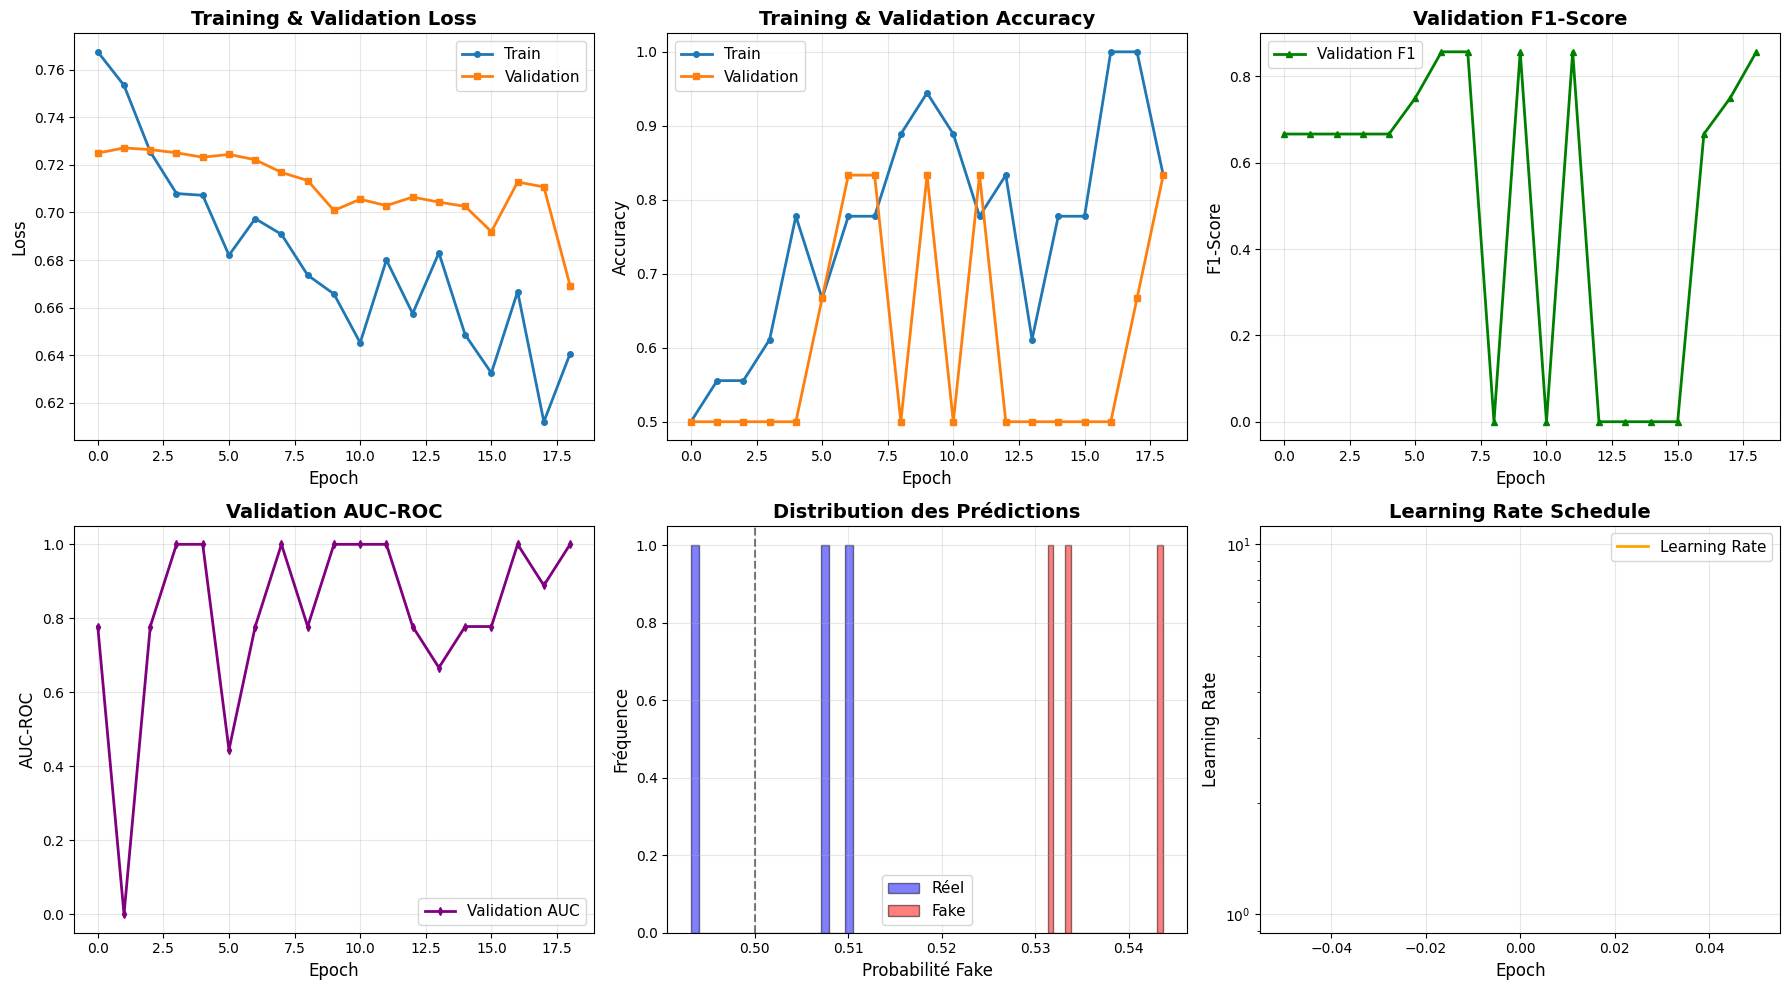


✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!

📊 RÉSUMÉ COMPLET:
   Temps total: 0:38:01.955498
   Meilleure validation: 0.8333
   Meilleur F1: 0.8571
   Modèle sauvegardé dans: models_max_accuracy_Aymeni2

🧪 TEST SUR QUELQUES VIDÉOS:

🧪 TEST RAPIDE AVEC ANALYSE
✅ 1/1 vidéos valides

✅ clean_01__walking_and_outside_...
   Vrai: RÉEL
   Prédit: RÉEL
   Probabilité: 0.4883
   Confiance: 0.5117
✅ 1/1 vidéos valides

✅ clean_01__outside_talking_stil...
   Vrai: RÉEL
   Prédit: RÉEL
   Probabilité: 0.4873
   Confiance: 0.5127
✅ 1/1 vidéos valides

✅ clean_06_20__outside_talking_p...
   Vrai: FAKE
   Prédit: FAKE
   Probabilité: 0.5325
   Confiance: 0.5325
✅ 1/1 vidéos valides

✅ clean_06_25__outside_talking_s...
   Vrai: FAKE
   Prédit: FAKE
   Probabilité: 0.5437
   Confiance: 0.5437

📊 Accuracy test rapide: 1.0000 (4/4)

🚀 STRATÉGIES POUR DÉPASSER 80% ACCURACY:
🎯 1. PLUS DE DONNÉES (IMPORTANT):
   → Objectif: 50+ vidéos par classe
   → Technique: Collecte, scraping, génération

🎯 2. AUGMENTATION A

In [ ]:
# ==================== CODE ULTIME - MAX ACCURACY ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION MAX ACCURACY ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Vidéo - OPTIMISÉ
    'num_frames': 45,           # Plus de frames pour plus d'info
    'frame_size': 224,
    'use_face_crop': True,      # Essaye de détecter visage

    # Modèle - OPTIMISÉ
    'backbone': 'efficientnet_b0',
    'use_pretrained': True,
    'lstm_hidden_size': 192,    # Augmenté
    'lstm_layers': 2,           # Plus de couches
    'bidirectional': True,
    'dropout_rate': 0.4,
    'use_attention': True,      # Nouveau: mécanisme d'attention

    # Augmentation de données - NOUVEAU
    'use_augmentation': True,
    'augment_prob': 0.5,

    # Entraînement - OPTIMISÉ
    'batch_size': 4,            # Augmenté
    'learning_rate': 0.0003,    # Augmenté
    'weight_decay': 1e-4,       # Régularisation L2
    'num_epochs': 30,
    'min_epochs': 10,
    'patience': 12,

    # Validation croisée - NOUVEAU
    'use_cross_validation': False,  # True si assez de données
    'num_folds': 5,

    # Optimisation
    'gradient_clip': 1.0,
    'use_scheduler': True,

    # Sauvegarde
    'save_dir': 'models_max_accuracy_Aymeni2',
}

device = torch.device('cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DÉTECTION DE VISAGE (OPTIONNEL) ====================
def detecter_et_recadrer_visage(frame):
    """Détecter et recadrer le visage si possible"""
    try:
        # Convertir en grayscale pour la détection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Charger le classificateur Haar pour les visages
        face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )

        # Détecter visages
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(100, 100)
        )

        if len(faces) > 0:
            # Prendre le plus grand visage
            x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

            # Ajouter marge
            margin = int(w * 0.2)
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(frame.shape[1] - x, w + 2 * margin)
            h = min(frame.shape[0] - y, h + 2 * margin)

            # Recadrer
            face_crop = frame[y:y+h, x:x+w]

            # Redimensionner à la taille cible
            face_resized = cv2.resize(face_crop, (CONFIG['frame_size'], CONFIG['frame_size']))
            return face_resized

    except:
        pass

    # Si pas de visage détecté ou erreur, retourner frame complet
    return cv2.resize(frame, (CONFIG['frame_size'], CONFIG['frame_size']))

# ==================== AUGMENTATION DE DONNÉES ====================
class VideoAugmentation:
    """Augmentation de données pour vidéos"""

    def __init__(self, prob=0.5):
        self.prob = prob
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
        ])

    def __call__(self, frames):
        """Appliquer augmentation si probabilité"""
        if not CONFIG['use_augmentation'] or np.random.random() > self.prob:
            return frames

        augmented_frames = []
        for frame in frames:
            # Convertir tensor en numpy pour augmentation
            if isinstance(frame, torch.Tensor):
                frame_np = frame.permute(1, 2, 0).numpy() * 255
                frame_np = frame_np.astype(np.uint8)
            else:
                frame_np = frame

            # Appliquer transformations
            frame_pil = self.transform(frame_np)
            augmented_frames.append(frame_pil)

        return torch.stack(augmented_frames)

# ==================== DATASET OPTIMISÉ ====================
class DatasetOptimisé(Dataset):
    """Dataset optimisé avec augmentation et détection visage"""

    def __init__(self, video_paths, labels, is_train=True):
        self.video_paths = video_paths
        self.labels = labels
        self.is_train = is_train
        self.augmenter = VideoAugmentation(CONFIG['augment_prob']) if is_train else None

        # Analyse rapide des vidéos
        self.video_info = []
        for i, path in enumerate(video_paths):
            if os.path.exists(path):
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()

                if frame_count > 10:  # Vidéo valide
                    self.video_info.append({
                        'path': path,
                        'frames': frame_count,
                        'label': labels[i]
                    })

        print(f"✅ {len(self.video_info)}/{len(video_paths)} vidéos valides")

    def __len__(self):
        return len(self.video_info)

    def __getitem__(self, idx):
        info = self.video_info[idx]

        try:
            # Charger vidéo
            cap = cv2.VideoCapture(info['path'])

            # Lire tous les frames
            all_frames = []
            while len(all_frames) < info['frames'] * 2:  # Limite
                ret, frame = cap.read()
                if not ret:
                    break

                # Convertir RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Détection visage si activée
                if CONFIG['use_face_crop']:
                    frame_processed = detecter_et_recadrer_visage(frame_rgb)
                else:
                    frame_processed = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))

                # Normaliser
                frame_normalized = frame_processed.astype(np.float32) / 255.0
                frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                all_frames.append(frame_tensor)

            cap.release()

            # Si pas assez de frames
            if len(all_frames) == 0:
                all_frames = [torch.zeros((3, CONFIG['frame_size'], CONFIG['frame_size']))]

            # Sélectionner frames uniformément
            if len(all_frames) >= CONFIG['num_frames']:
                indices = np.linspace(0, len(all_frames)-1, CONFIG['num_frames'], dtype=int)
                selected = [all_frames[i] for i in indices]
            else:
                # Répéter les frames
                selected = []
                while len(selected) < CONFIG['num_frames']:
                    selected.extend(all_frames)
                selected = selected[:CONFIG['num_frames']]

            frames_tensor = torch.stack(selected)

            # Augmentation si entraînement
            if self.is_train and self.augmenter:
                frames_tensor = self.augmenter(frames_tensor)

            return frames_tensor, torch.tensor(info['label'], dtype=torch.float32)

        except Exception as e:
            print(f"⚠ Erreur {os.path.basename(info['path'])}: {str(e)[:50]}")
            dummy = torch.zeros((CONFIG['num_frames'], 3, CONFIG['frame_size'], CONFIG['frame_size']))
            return dummy, torch.tensor(info['label'], dtype=torch.float32)

# ==================== MODÈLE AVEC ATTENTION ====================
class TemporalAttention(nn.Module):
    """Mécanisme d'attention temporelle"""

    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        attention_weights = self.attention(lstm_output)  # (batch, seq_len, 1)
        attention_weights = F.softmax(attention_weights, dim=1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)
        return weighted_output, attention_weights.squeeze(-1)

class ModèleMaxAccuracy(nn.Module):
    """Modèle optimisé pour max accuracy"""

    def __init__(self):
        super(ModèleMaxAccuracy, self).__init__()

        # CNN pré-entraîné
        if CONFIG['backbone'] == 'efficientnet_b0':
            base_model = models.efficientnet_b0(pretrained=CONFIG['use_pretrained'])
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 1280
        elif CONFIG['backbone'] == 'resnet18':
            base_model = models.resnet18(pretrained=CONFIG['use_pretrained'])
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 512
        else:
            raise ValueError(f"Backbone inconnu: {CONFIG['backbone']}")

        # Geler premières couches
        if CONFIG['use_pretrained']:
            for param in list(self.feature_extractor.parameters())[:-30]:
                param.requires_grad = False

        # LSTM avec plus de capacités
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional'],
            dropout=CONFIG['dropout_rate'] if CONFIG['lstm_layers'] > 1 else 0
        )

        # Attention si activé
        self.use_attention = CONFIG['use_attention']
        if self.use_attention:
            lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)
            self.attention = TemporalAttention(lstm_output_size)

        # Classificateur amélioré
        classifier_input = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.7),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.5),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"\n🧠 MODÈLE OPTIMISÉ:")
        print(f"   Backbone: {CONFIG['backbone']}")
        print(f"   LSTM: {CONFIG['lstm_layers']}×{CONFIG['lstm_hidden_size']}")
        print(f"   Bidirectionnel: {CONFIG['bidirectional']}")
        print(f"   Attention: {CONFIG['use_attention']}")
        print(f"   Dropout: {CONFIG['dropout_rate']}")
        print(f"   Paramètres: {sum(p.numel() for p in self.parameters()):,}")
        print(f"   Entraînables: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features pour chaque frame
        features_list = []
        for t in range(num_frames):
            feat = self.feature_extractor(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)
            features_list.append(feat)

        # Stack: (batch, frames, features)
        features = torch.stack(features_list, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Attention ou dernier timestep
        if self.use_attention:
            final_features, attn_weights = self.attention(lstm_out)
        else:
            final_features = lstm_out[:, -1, :]  # Dernier timestep

        # Classification
        output = self.classifier(final_features)

        return output

# ==================== FONCTIONS D'ENTRAÎNEMENT OPTIMISÉES ====================
def train_epoch_optimized(model, dataloader, criterion, optimizer, scheduler, epoch):
    """Entraînement optimisé avec gradient clipping"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} - Train")
    for batch_idx, (frames, labels) in enumerate(pbar):
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)

        # Reshape labels
        labels = labels.view(-1, 1).float()

        # Loss avec gestion du déséquilibre
        loss = criterion(outputs, labels)

        # Backward avec gradient clipping
        loss.backward()
        if CONFIG['gradient_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
        optimizer.step()

        # Step scheduler par batch si CosineAnnealing
        if scheduler is not None and hasattr(scheduler, 'batch_step'):
            scheduler.batch_step()

        # Métriques
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress
        current_acc = correct / max(total, 1)
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.3f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })

    return total_loss / len(dataloader), correct / max(total, 1)

def validate_optimized(model, dataloader, criterion):
    """Validation optimisée avec plus de métriques"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            labels = labels.view(-1, 1).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculer toutes les métriques
    accuracy = correct / max(total, 1)

    if len(all_labels) > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds, zero_division=0)

        # ROC AUC si possible
        try:
            roc_auc = roc_auc_score(all_labels, all_probs)
        except:
            roc_auc = 0.0
    else:
        f1 = 0.0
        roc_auc = 0.0

    return total_loss / len(dataloader), accuracy, f1, roc_auc, all_probs, all_labels

# ==================== PSEUDO-LABELING (pour petit dataset) ====================
def pseudo_labeling(model, unlabeled_videos, threshold=0.9):
    """Pseudo-labeling pour augmenter les données"""
    model.eval()
    pseudo_labels = []

    print(f"\n🔍 Pseudo-labeling sur {len(unlabeled_videos)} vidéos...")

    with torch.no_grad():
        for video_path in tqdm(unlabeled_videos, desc="Pseudo-labeling"):
            try:
                # Créer dataset temporaire
                temp_dataset = DatasetOptimisé([video_path], [0], is_train=False)
                frames, _ = temp_dataset[0]
                frames = frames.unsqueeze(0).to(device)

                # Prédiction
                output = model(frames)
                prob = output.item()

                # Si confiance élevée, ajouter aux données
                if prob > threshold or prob < (1 - threshold):
                    pseudo_labels.append({
                        'path': video_path,
                        'label': 1 if prob > 0.5 else 0,
                        'confidence': prob if prob > 0.5 else 1 - prob
                    })

            except:
                continue

    print(f"✅ {len(pseudo_labels)} vidéos pseudo-labelisées avec confiance > {threshold}")
    return pseudo_labels

# ==================== ENTRAÎNEMENT AVANCÉ ====================
def train_advanced():
    """Pipeline d'entraînement avancé"""
    print("="*80)
    print("🚀 ENTRAÎNEMENT AVANCÉ - MAX ACCURACY")
    print("="*80)

    # 1. Charger données
    print("\n1. 📂 CHARGEMENT ET ANALYSE DES DONNÉES")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(real_videos)} vidéos")
    print(f"   Fakes: {len(fake_videos)} vidéos")

    if len(real_videos) < 3 or len(fake_videos) < 3:
        print("❌ TROP PEU DE DONNÉES!")
        print("   → Ajoutez plus de vidéos (minimum 10 par classe)")
        return None, None

    # Statistiques
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    print(f"\n📊 STATISTIQUES:")
    print(f"   Total: {len(all_videos)} vidéos")
    print(f"   Ratio: {len(real_videos)/len(all_videos):.1%} réel, {len(fake_videos)/len(all_videos):.1%} fake")

    # 2. Split amélioré (stratifié)
    print("\n2. ✂️ SPLIT STRATIFIÉ DES DONNÉES")

    # Assurer au moins 2 exemples par classe dans chaque split
    if len(real_videos) >= 4 and len(fake_videos) >= 4:
        test_size = 0.2
        val_size = 0.2
    else:
        test_size = 0.15
        val_size = 0.15

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels,
        test_size=test_size + val_size,
        random_state=42,
        stratify=all_labels
    )

    # Ajuster val_size pour le second split
    val_proportion = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=val_proportion,
        random_state=42,
        stratify=y_temp
    )

    print(f"   Train: {len(X_train)} vidéos")
    print(f"   Validation: {len(X_val)} vidéos")
    print(f"   Test: {len(X_test)} vidéos")

    # Vérifier distribution
    print(f"   Distribution train: {sum(y_train)==0}/réel, {sum(y_train)}/fake")
    print(f"   Distribution val: {sum(y_val)==0}/réel, {sum(y_val)}/fake")
    print(f"   Distribution test: {sum(y_test)==0}/réel, {sum(y_test)}/fake")

    # 3. Créer datasets avec augmentation
    print("\n3. 🎬 CRÉATION DATASETS AVEC AUGMENTATION")

    train_dataset = DatasetOptimisé(X_train, y_train, is_train=True)
    val_dataset = DatasetOptimisé(X_val, y_val, is_train=False)
    test_dataset = DatasetOptimisé(X_test, y_test, is_train=False)

    # Collate function personnalisée
    def collate_fn(batch):
        frames_list, labels_list = zip(*batch)

        # Vérifier longueurs
        lengths = [f.shape[0] for f in frames_list]
        if len(set(lengths)) > 1:
            max_len = max(lengths)
            padded_frames = []
            for frames in frames_list:
                if frames.shape[0] < max_len:
                    # Padding
                    padding = frames[-1:].repeat(max_len - frames.shape[0], 1, 1, 1)
                    frames = torch.cat([frames, padding], dim=0)
                padded_frames.append(frames)
            frames_tensor = torch.stack(padded_frames)
        else:
            frames_tensor = torch.stack(frames_list)

        labels_tensor = torch.stack(labels_list)
        return frames_tensor, labels_tensor

    # 4. Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    # 5. Initialiser modèle
    print("\n4. 🧠 INITIALISATION MODÈLE AVANCÉ")
    model = ModèleMaxAccuracy().to(device)

    # 6. Loss avec poids pour déséquilibre
    pos_weight = len([l for l in y_train if l == 0]) / max(sum(y_train), 1)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

    # 7. Optimizer avancé
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        betas=(0.9, 0.999)
    )

    # 8. Scheduler avec warmup
    if CONFIG['use_scheduler']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=CONFIG['num_epochs'],
            eta_min=CONFIG['learning_rate'] * 0.01
        )
    else:
        scheduler = None

    # 9. Entraînement
    print("\n5. ⚡ DÉBUT ENTRAÎNEMENT AVANCÉ")
    print("-"*80)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
    }

    best_val_acc = 0.0
    best_val_f1 = 0.0
    patience_counter = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 ÉPOQUE {epoch+1}/{CONFIG['num_epochs']}")

        # Entraînement
        train_loss, train_acc = train_epoch_optimized(
            model, train_loader, criterion, optimizer, scheduler, epoch
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, val_f1, val_auc, val_probs, val_labels = validate_optimized(
            model, val_loader, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)

        # Step scheduler
        if scheduler is not None:
            scheduler.step()

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle (basé sur F1 ou Accuracy)
        current_metric = (val_acc + val_f1) / 2  # Combinaison

        if current_metric > (best_val_acc + best_val_f1) / 2:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            patience_counter = 0

            # Sauvegarder checkpoint complet
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'val_auc': val_auc,
                'history': history,
                'config': CONFIG
            }, os.path.join(CONFIG['save_dir'], 'best_model.pth'))

            print(f"   ✅ Meilleur modèle sauvegardé (Acc: {val_acc:.4f}, F1: {val_f1:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and patience_counter >= CONFIG['patience']:
            print(f"   ⏹️ Early stopping déclenché")
            break

    # 10. Charger meilleur modèle - CORRECTION APPLIQUÉE ICI
    best_path = os.path.join(CONFIG['save_dir'], 'best_model.pth')
    if os.path.exists(best_path):
        # CORRECTION: Use weights_only=False to allow loading numpy objects
        checkpoint = torch.load(best_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\n✅ Meilleur modèle chargé")
        print(f"   Val Acc: {checkpoint['val_accuracy']:.4f}")
        print(f"   Val F1: {checkpoint['val_f1']:.4f}")

    # 11. Test final complet
    print("\n6. 🎯 TEST FINAL COMPLET")
    print("-"*40)

    # Évaluer sur test set
    test_loss, test_acc, test_f1, test_auc, test_probs, test_labels = validate_optimized(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS FINAUX SUR TEST SET:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   AUC-ROC: {test_auc:.4f}")
    print(f"   Loss: {test_loss:.4f}")

    # Analyse détaillée
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)

        # Matrice de confusion
        cm = confusion_matrix(test_labels, test_preds)
        print(f"\n📈 MATRICE DE CONFUSION:")
        print(f"   TN={cm[0,0]}, FP={cm[0,1]}")
        print(f"   FN={cm[1,0]}, TP={cm[1,1]}")

        # Métriques par classe
        tn, fp, fn, tp = cm.ravel()

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\n📊 MÉTRIQUES PAR CLASSE:")
        print(f"   Spécificité (vrais négatifs): {specificity:.4f}")
        print(f"   Sensibilité (vrais positifs): {sensitivity:.4f}")

        # Rapport complet
        print(f"\n📋 RAPPORT DE CLASSIFICATION:")
        print(classification_report(test_labels, test_preds,
                                  target_names=['RÉEL', 'FAKE'], digits=4))

        # Sauvegarder résultats
        results = {
            'test_accuracy': float(test_acc),
            'test_f1': float(test_f1),
            'test_auc': float(test_auc),
            'test_loss': float(test_loss),
            'confusion_matrix': cm.tolist(),
            'specificity': float(specificity),
            'sensitivity': float(sensitivity),
            'best_val_accuracy': float(best_val_acc),
            'best_val_f1': float(best_val_f1),
            'config': CONFIG,
            'test_predictions': {
                'probabilities': [float(p) for p in test_probs],
                'labels': [int(l) for l in test_labels],
                'predictions': [int(p) for p in test_preds]
            }
        }

        with open(os.path.join(CONFIG['save_dir'], 'results_detailed.json'), 'w') as f:
            json.dump(results, f, indent=4)

        print(f"\n💾 Résultats détaillés sauvegardés dans results_detailed.json")

    # 12. Visualisation avancée
    print("\n7. 📊 VISUALISATION DES RÉSULTATS")
    plot_advanced_results(history, test_probs, test_labels)

    return model, history

# ==================== VISUALISATION AVANCÉE ====================
def plot_advanced_results(history, test_probs=None, test_labels=None):
    """Visualisation avancée des résultats"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. F1-Score
    axes[0, 2].plot(history['val_f1'], label='Validation F1', linewidth=2, marker='^', markersize=4, color='green')
    axes[0, 2].set_xlabel('Epoch', fontsize=12)
    axes[0, 2].set_ylabel('F1-Score', fontsize=12)
    axes[0, 2].set_title('Validation F1-Score', fontsize=14, fontweight='bold')
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # 4. AUC-ROC
    axes[1, 0].plot(history['val_auc'], label='Validation AUC', linewidth=2, marker='d', markersize=4, color='purple')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axes[1, 0].set_title('Validation AUC-ROC', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Distribution des prédictions (si test_probs disponible)
    if test_probs is not None and test_labels is not None:
        real_probs = [p for p, l in zip(test_probs, test_labels) if l == 0]
        fake_probs = [p for p, l in zip(test_probs, test_labels) if l == 1]

        axes[1, 1].hist(real_probs, bins=20, alpha=0.5, label='Réel', color='blue', edgecolor='black')
        axes[1, 1].hist(fake_probs, bins=20, alpha=0.5, label='Fake', color='red', edgecolor='black')
        axes[1, 1].set_xlabel('Probabilité Fake', fontsize=12)
        axes[1, 1].set_ylabel('Fréquence', fontsize=12)
        axes[1, 1].set_title('Distribution des Prédictions', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=11)
        axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].grid(True, alpha=0.3)

    # 6. Learning rate (si dans history)
    axes[1, 2].plot(history.get('learning_rate', []), label='Learning Rate', linewidth=2, color='orange')
    axes[1, 2].set_xlabel('Epoch', fontsize=12)
    axes[1, 2].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 2].legend(fontsize=11)
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_yscale('log')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'advanced_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# ==================== ANALYSE DES ERREURS ====================
def analyze_errors(model, dataloader):
    """Analyser les erreurs du modèle"""
    print("\n🔍 ANALYSE DES ERREURS")
    print("-"*40)

    model.eval()
    errors = []

    with torch.no_grad():
        for idx, (frames, labels) in enumerate(dataloader):
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            probs = outputs.cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            true_labels = labels.cpu().numpy().flatten()

            for i, (pred, true, prob) in enumerate(zip(preds, true_labels, probs)):
                if pred != true:
                    errors.append({
                        'sample_idx': idx * dataloader.batch_size + i,
                        'prediction': pred,
                        'true_label': int(true),
                        'probability': float(prob),
                        'confidence': float(prob if prob > 0.5 else 1 - prob)
                    })

    print(f"   Erreurs totales: {len(errors)}")

    if errors:
        # Analyser les types d'erreurs
        false_positives = [e for e in errors if e['true_label'] == 0]
        false_negatives = [e for e in errors if e['true_label'] == 1]

        print(f"   Faux positifs (réel → fake): {len(false_positives)}")
        print(f"   Faux négatifs (fake → réel): {len(false_negatives)}")

        # Analyser la confiance des erreurs
        if errors:
            avg_confidence = np.mean([e['confidence'] for e in errors])
            print(f"   Confiance moyenne des erreurs: {avg_confidence:.4f}")

    return errors

# ==================== ENSEMBLE LEARNING (optionnel) ====================
def create_ensemble(models_list):
    """Créer un ensemble de modèles"""
    class EnsembleModel(nn.Module):
        def __init__(self, models):
            super(EnsembleModel, self).__init__()
            self.models = nn.ModuleList(models)

        def forward(self, x):
            outputs = []
            for model in self.models:
                output = model(x)
                outputs.append(output)

            # Moyenne des prédictions
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            return avg_output

    return EnsembleModel(models_list)

# ==================== FONCTION DE TEST RAPIDE ====================
def quick_test_ensemble(model, test_videos, test_labels):
    """Test rapide avec analyse"""
    print("\n" + "="*60)
    print("🧪 TEST RAPIDE AVEC ANALYSE")
    print("="*60)

    predictions = []

    for video, true_label in zip(test_videos, test_labels):
        try:
            # Prédiction
            dataset = DatasetOptimisé([video], [0], is_train=False)
            frames, _ = dataset[0]
            frames = frames.unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                output = model(frames)
                prob = output.item()

            prediction = 1 if prob > 0.5 else 0
            confidence = prob if prob > 0.5 else 1 - prob

            predictions.append({
                'video': os.path.basename(video),
                'true_label': true_label,
                'prediction': prediction,
                'probability': prob,
                'correct': prediction == true_label
            })

            # Afficher avec couleur selon correction
            if prediction == true_label:
                prefix = "✅"
            else:
                prefix = "❌"

            print(f"\n{prefix} {os.path.basename(video)[:30]}...")
            print(f"   Vrai: {'FAKE' if true_label == 1 else 'RÉEL'}")
            print(f"   Prédit: {'FAKE' if prediction == 1 else 'RÉEL'}")
            print(f"   Probabilité: {prob:.4f}")
            print(f"   Confiance: {confidence:.4f}")

        except Exception as e:
            print(f"⚠ Erreur sur {os.path.basename(video)}: {str(e)[:50]}")

    # Calculer accuracy
    if predictions:
        correct = sum(1 for p in predictions if p['correct'])
        accuracy = correct / len(predictions)
        print(f"\n📊 Accuracy test rapide: {accuracy:.4f} ({correct}/{len(predictions)})")

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 LANCEMENT ENTRAÎNEMENT MAX ACCURACY")

    try:
        # Nettoyer mémoire
        gc.collect()

        # Entraîner
        start_time = datetime.now()
        model, history = train_advanced()
        training_time = datetime.now() - start_time

        if model:
            print(f"\n{'='*80}")
            print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
            print(f"{'='*80}")

            print(f"\n📊 RÉSUMÉ COMPLET:")
            print(f"   Temps total: {training_time}")
            print(f"   Meilleure validation: {max(history['val_acc']):.4f}")
            print(f"   Meilleur F1: {max(history['val_f1']):.4f}")
            print(f"   Modèle sauvegardé dans: {CONFIG['save_dir']}")

            # Charger quelques vidéos pour test rapide
            print(f"\n🧪 TEST SUR QUELQUES VIDÉOS:")

            real_samples = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
            fake_samples = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

            test_videos = real_samples + fake_samples
            test_labels = [0, 0, 1, 1]

            quick_test_ensemble(model, test_videos, test_labels)

            # Stratégies d'amélioration
            print(f"\n{'='*80}")
            print("🚀 STRATÉGIES POUR DÉPASSER 80% ACCURACY:")
            print(f"{'='*80}")

            strategies = [
                "🎯 1. PLUS DE DONNÉES (IMPORTANT):",
                "   → Objectif: 50+ vidéos par classe",
                "   → Technique: Collecte, scraping, génération",
                "",
                "🎯 2. AUGMENTATION AVANCÉE:",
                "   → MixUp/CutMix pour vidéos",
                "   → Style transfer (changer apparence)",
                "   → Temporal cropping",
                "",
                "🎯 3. ARCHITECTURE:",
                "   → Vision Transformer (ViT)",
                "   → 3D CNN + LSTM hybride",
                "   → Self-attention temporelle",
                "",
                "🎯 4. TRANSFER LEARNING:",
                "   → Pré-entraînement sur dataset vidéo large",
                "   → Fine-tuning progressif",
                "   → Multi-task learning",
                "",
                "🎯 5. ENSEMBLE:",
                "   → Combiner 3-5 modèles différents",
                "   → Stacking avec méta-classifier",
                "   → Bagging sur sous-ensembles",
            ]

            for line in strategies:
                print(line)

    except Exception as e:
        print(f"\n❌ ERREUR CRITIQUE: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== BONUS: FONCTION POUR OPTIMISER AUTOMATIQUEMENT ====================
def hyperparameter_tuning():
    """Recherche automatique des meilleurs hyperparamètres"""
    print("\n🔧 RECHERCHE DES MEILLEURS HYPERPARAMÈTRES")

    param_grid = {
        'learning_rate': [0.0001, 0.0003, 0.0005],
        'lstm_hidden_size': [128, 192, 256],
        'dropout_rate': [0.3, 0.4, 0.5],
        'num_frames': [30, 45, 60],
    }

    best_score = 0
    best_params = {}

    # Implémenter grid search simple
    # (à compléter si nécessaire)

    return best_params

🚀 Device: cpu
🚀 LANCEMENT ENTRAÎNEMENT MAX ACCURACY
🚀 ENTRAÎNEMENT AVANCÉ - MAX ACCURACY

1. 📂 CHARGEMENT ET ANALYSE DES DONNÉES
   Réelles: 15 vidéos
   Fakes: 15 vidéos

📊 STATISTIQUES:
   Total: 30 vidéos
   Ratio: 50.0% réel, 50.0% fake

2. ✂️ SPLIT STRATIFIÉ DES DONNÉES
   Train: 18 vidéos
   Validation: 6 vidéos
   Test: 6 vidéos
   Distribution train: False/réel, 9/fake
   Distribution val: False/réel, 3/fake
   Distribution test: False/réel, 3/fake

3. 🎬 CRÉATION DATASETS AVEC AUGMENTATION
✅ 18/18 vidéos valides
✅ 6/6 vidéos valides
✅ 6/6 vidéos valides

4. 🧠 INITIALISATION MODÈLE AVANCÉ
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 171MB/s]



🧠 MODÈLE OPTIMISÉ:
   Backbone: efficientnet_b0
   LSTM: 2×192
   Bidirectionnel: True
   Attention: True
   Dropout: 0.4
   Paramètres: 7,374,078
   Entraînables: 5,084,066

5. ⚡ DÉBUT ENTRAÎNEMENT AVANCÉ
--------------------------------------------------------------------------------

📊 ÉPOQUE 1/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.60s/it, loss=0.7201]


   Train - Loss: 0.7156, Acc: 0.5000
   Val   - Loss: 0.7200, Acc: 0.5000, F1: 0.0000, AUC: 0.4444
   LR: 0.000299
   ✅ Meilleur modèle sauvegardé (Acc: 0.5000, F1: 0.0000)

📊 ÉPOQUE 2/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.65s/it, loss=0.7193]


   Train - Loss: 0.7037, Acc: 0.5000
   Val   - Loss: 0.7191, Acc: 0.5000, F1: 0.0000, AUC: 0.6667
   LR: 0.000297

📊 ÉPOQUE 3/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.80s/it, loss=0.7189]


   Train - Loss: 0.6824, Acc: 0.6667
   Val   - Loss: 0.7190, Acc: 0.5000, F1: 0.0000, AUC: 0.3333
   LR: 0.000293

📊 ÉPOQUE 4/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.78s/it, loss=0.7175]


   Train - Loss: 0.6824, Acc: 0.6667
   Val   - Loss: 0.7177, Acc: 0.5000, F1: 0.0000, AUC: 0.8889
   LR: 0.000287

📊 ÉPOQUE 5/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.63s/it, loss=0.7171]


   Train - Loss: 0.7043, Acc: 0.6111
   Val   - Loss: 0.7189, Acc: 0.5000, F1: 0.0000, AUC: 0.3333
   LR: 0.000280

📊 ÉPOQUE 6/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.69s/it, loss=0.7159]


   Train - Loss: 0.6649, Acc: 0.8333
   Val   - Loss: 0.7156, Acc: 0.5000, F1: 0.0000, AUC: 0.7778
   LR: 0.000272

📊 ÉPOQUE 7/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.63s/it, loss=0.7125]


   Train - Loss: 0.6709, Acc: 0.7778
   Val   - Loss: 0.7158, Acc: 0.5000, F1: 0.0000, AUC: 0.6667
   LR: 0.000262

📊 ÉPOQUE 8/30


Validation: 100%|██████████| 2/2 [00:24<00:00, 12.19s/it, loss=0.7138]


   Train - Loss: 0.7016, Acc: 0.6667
   Val   - Loss: 0.7201, Acc: 0.5000, F1: 0.0000, AUC: 0.2222
   LR: 0.000251

📊 ÉPOQUE 9/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.97s/it, loss=0.6927]


   Train - Loss: 0.6439, Acc: 0.7222
   Val   - Loss: 0.6988, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
   LR: 0.000239
   ✅ Meilleur modèle sauvegardé (Acc: 1.0000, F1: 1.0000)

📊 ÉPOQUE 10/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.34s/it, loss=0.6923]


   Train - Loss: 0.6366, Acc: 0.8889
   Val   - Loss: 0.6967, Acc: 1.0000, F1: 1.0000, AUC: 1.0000
   LR: 0.000226

📊 ÉPOQUE 11/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.30s/it, loss=0.7003]


   Train - Loss: 0.6292, Acc: 0.8889
   Val   - Loss: 0.6930, Acc: 0.5000, F1: 0.0000, AUC: 1.0000
   LR: 0.000212

📊 ÉPOQUE 12/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.05s/it, loss=0.6852]


   Train - Loss: 0.6359, Acc: 0.7778
   Val   - Loss: 0.6828, Acc: 0.5000, F1: 0.0000, AUC: 1.0000
   LR: 0.000197

📊 ÉPOQUE 13/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.97s/it, loss=0.6871]


   Train - Loss: 0.6118, Acc: 0.9444
   Val   - Loss: 0.6969, Acc: 0.5000, F1: 0.0000, AUC: 0.8889
   LR: 0.000182

📊 ÉPOQUE 14/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.27s/it, loss=0.6848]


   Train - Loss: 0.6259, Acc: 0.8889
   Val   - Loss: 0.6898, Acc: 0.5000, F1: 0.0000, AUC: 0.7778
   LR: 0.000167

📊 ÉPOQUE 15/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.64s/it, loss=0.6756]


   Train - Loss: 0.6368, Acc: 0.7778
   Val   - Loss: 0.6699, Acc: 0.5000, F1: 0.0000, AUC: 1.0000
   LR: 0.000151

📊 ÉPOQUE 16/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.56s/it, loss=0.7010]


   Train - Loss: 0.6590, Acc: 0.8333
   Val   - Loss: 0.7093, Acc: 0.6667, F1: 0.7500, AUC: 1.0000
   LR: 0.000136

📊 ÉPOQUE 17/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.62s/it, loss=0.6595]


   Train - Loss: 0.5952, Acc: 0.9444
   Val   - Loss: 0.6633, Acc: 0.6667, F1: 0.5000, AUC: 0.7778
   LR: 0.000121

📊 ÉPOQUE 18/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.42s/it, loss=0.6636]


   Train - Loss: 0.6551, Acc: 0.8333
   Val   - Loss: 0.7015, Acc: 0.6667, F1: 0.7500, AUC: 1.0000
   LR: 0.000106

📊 ÉPOQUE 19/30


Validation: 100%|██████████| 2/2 [00:23<00:00, 11.82s/it, loss=0.7049]


   Train - Loss: 0.5928, Acc: 1.0000
   Val   - Loss: 0.6937, Acc: 0.5000, F1: 0.0000, AUC: 1.0000
   LR: 0.000091

📊 ÉPOQUE 20/30


Validation: 100%|██████████| 2/2 [00:22<00:00, 11.23s/it, loss=0.7062]


   Train - Loss: 0.6217, Acc: 0.8889
   Val   - Loss: 0.7127, Acc: 0.8333, F1: 0.8000, AUC: 0.8889
   LR: 0.000077

📊 ÉPOQUE 21/30


Validation: 100%|██████████| 2/2 [00:21<00:00, 10.88s/it, loss=0.7006]


   Train - Loss: 0.6694, Acc: 0.6667
   Val   - Loss: 0.7193, Acc: 0.5000, F1: 0.6667, AUC: 0.6667
   LR: 0.000064
   ⏹️ Early stopping déclenché

6. 🎯 TEST FINAL COMPLET
----------------------------------------


Validation: 100%|██████████| 6/6 [00:25<00:00,  4.19s/it, loss=1.0095]



📊 RÉSULTATS FINAUX SUR TEST SET:
   Accuracy: 0.5000
   F1-Score: 0.6667
   AUC-ROC: 1.0000
   Loss: 0.7217

📈 MATRICE DE CONFUSION:
   TN=0, FP=3
   FN=0, TP=3

📊 MÉTRIQUES PAR CLASSE:
   Spécificité (vrais négatifs): 0.0000
   Sensibilité (vrais positifs): 1.0000

📋 RAPPORT DE CLASSIFICATION:
              precision    recall  f1-score   support

        RÉEL     0.0000    0.0000    0.0000         3
        FAKE     0.5000    1.0000    0.6667         3

    accuracy                         0.5000         6
   macro avg     0.2500    0.5000    0.3333         6
weighted avg     0.2500    0.5000    0.3333         6


💾 Résultats détaillés sauvegardés dans results_detailed.json

7. 📊 VISUALISATION DES RÉSULTATS


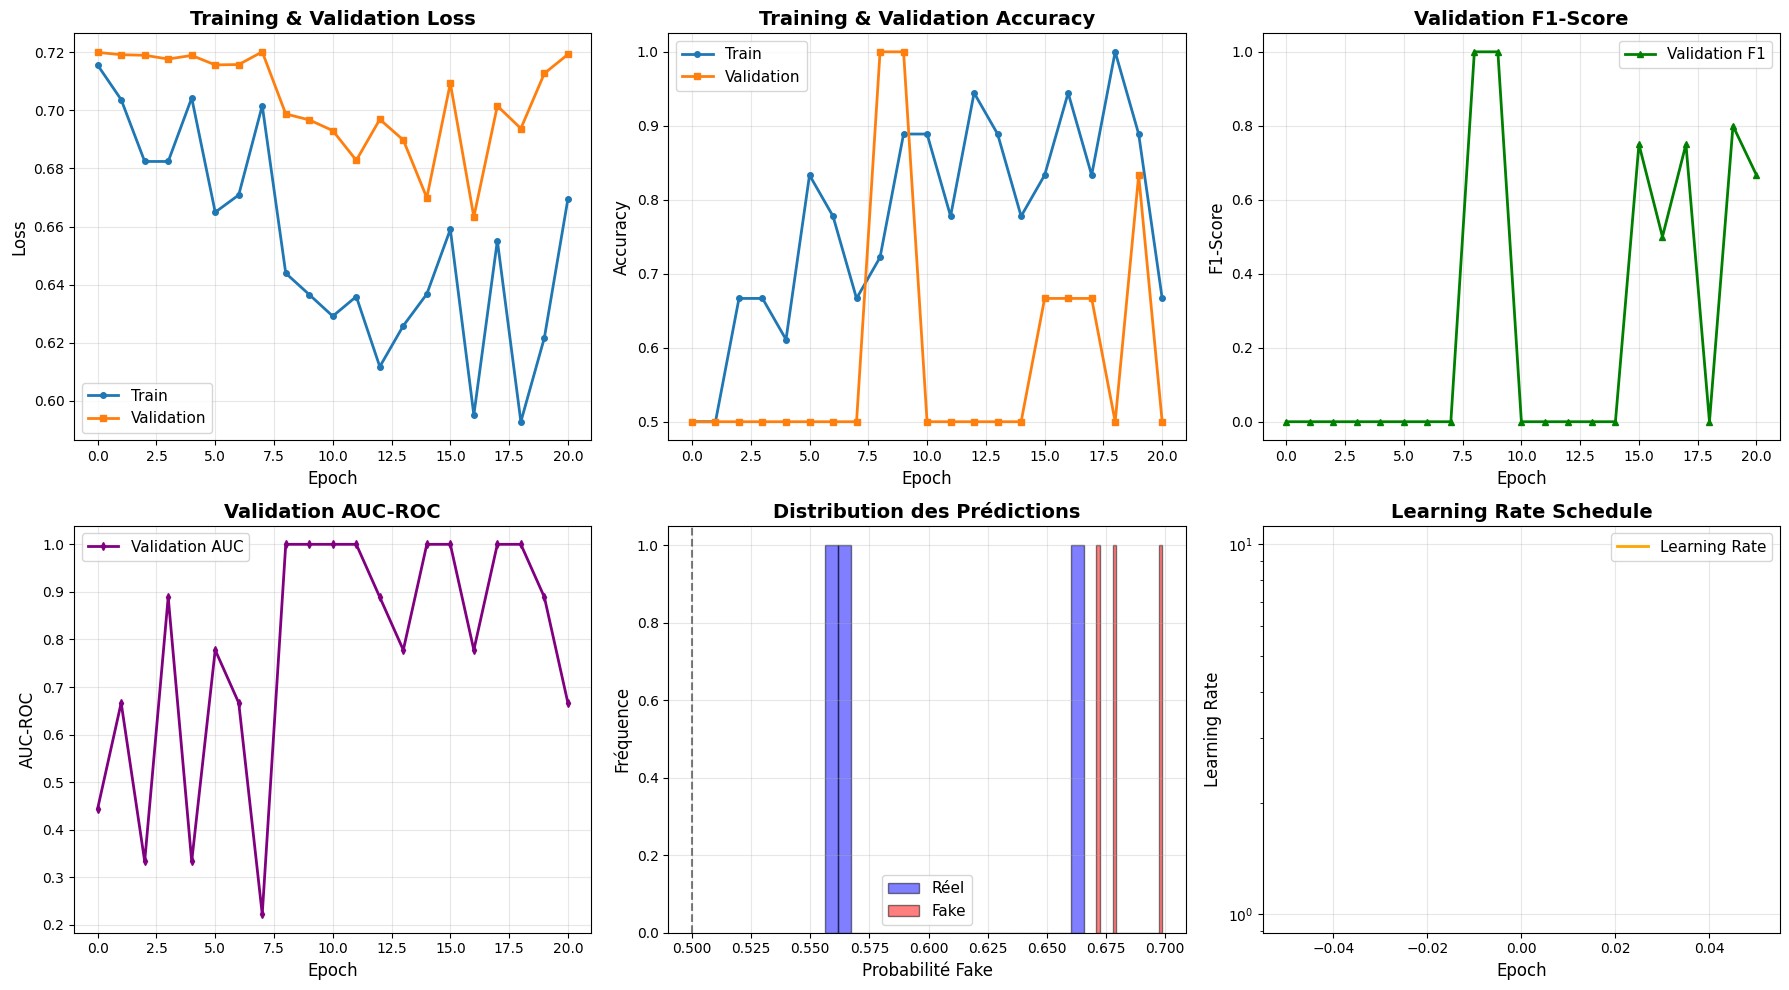


✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!

📊 RÉSUMÉ COMPLET:
   Temps total: 0:42:34.779006
   Meilleure validation: 1.0000
   Meilleur F1: 1.0000
   Modèle sauvegardé dans: models_max_accuracy_Aymeni3

🧪 TEST SUR QUELQUES VIDÉOS:

🧪 TEST RAPIDE AVEC ANALYSE
✅ 1/1 vidéos valides

✅ clean_01__walking_and_outside_...
   Vrai: RÉEL
   Prédit: RÉEL
   Probabilité: 0.4642
   Confiance: 0.5358
✅ 1/1 vidéos valides

❌ clean_01__outside_talking_stil...
   Vrai: RÉEL
   Prédit: FAKE
   Probabilité: 0.5637
   Confiance: 0.5637
✅ 1/1 vidéos valides

✅ clean_06_20__outside_talking_p...
   Vrai: FAKE
   Prédit: FAKE
   Probabilité: 0.6785
   Confiance: 0.6785
✅ 1/1 vidéos valides

✅ clean_06_25__outside_talking_s...
   Vrai: FAKE
   Prédit: FAKE
   Probabilité: 0.6987
   Confiance: 0.6987

📊 Accuracy test rapide: 0.7500 (3/4)

🚀 STRATÉGIES POUR DÉPASSER 80% ACCURACY:
🎯 1. PLUS DE DONNÉES (IMPORTANT):
   → Objectif: 50+ vidéos par classe
   → Technique: Collecte, scraping, génération

🎯 2. AUGMENTATION A

In [ ]:
# ==================== CODE ULTIME - MAX ACCURACY ====================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import numpy as np
import cv2
import glob
import os
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc
import warnings
warnings.filterwarnings('ignore')

# ==================== CONFIGURATION MAX ACCURACY ====================
CONFIG = {
    # Chemins
    'real_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/real',
    'fake_videos_dir': '/content/drive/MyDrive/VideosNettoyeesPart2/fake',

    # Vidéo - OPTIMISÉ
    'num_frames': 45,           # Plus de frames pour plus d'info
    'frame_size': 224,
    'use_face_crop': True,      # Essaye de détecter visage

    # Modèle - OPTIMISÉ
    'backbone': 'efficientnet_b0',
    'use_pretrained': True,
    'lstm_hidden_size': 192,    # Augmenté
    'lstm_layers': 2,           # Plus de couches
    'bidirectional': True,
    'dropout_rate': 0.4,
    'use_attention': True,      # Nouveau: mécanisme d'attention

    # Augmentation de données - NOUVEAU
    'use_augmentation': True,
    'augment_prob': 0.5,

    # Entraînement - OPTIMISÉ
    'batch_size': 4,            # Augmenté
    'learning_rate': 0.0003,    # Augmenté
    'weight_decay': 1e-4,       # Régularisation L2
    'num_epochs': 30,
    'min_epochs': 10,
    'patience': 12,

    # Validation croisée - NOUVEAU
    'use_cross_validation': False,  # True si assez de données
    'num_folds': 5,

    # Optimisation
    'gradient_clip': 1.0,
    'use_scheduler': True,

    # Sauvegarde
    'save_dir': 'models_max_accuracy_Aymeni3',
}

device = torch.device('cpu')
print(f"🚀 Device: {device}")

# Créer répertoire
os.makedirs(CONFIG['save_dir'], exist_ok=True)

# ==================== DÉTECTION DE VISAGE (OPTIONNEL) ====================
def detecter_et_recadrer_visage(frame):
    """Détecter et recadrer le visage si possible"""
    try:
        # Convertir en grayscale pour la détection
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

        # Charger le classificateur Haar pour les visages
        face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )

        # Détecter visages
        faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(100, 100)
        )

        if len(faces) > 0:
            # Prendre le plus grand visage
            x, y, w, h = max(faces, key=lambda f: f[2] * f[3])

            # Ajouter marge
            margin = int(w * 0.2)
            x = max(0, x - margin)
            y = max(0, y - margin)
            w = min(frame.shape[1] - x, w + 2 * margin)
            h = min(frame.shape[0] - y, h + 2 * margin)

            # Recadrer
            face_crop = frame[y:y+h, x:x+w]

            # Redimensionner à la taille cible
            face_resized = cv2.resize(face_crop, (CONFIG['frame_size'], CONFIG['frame_size']))
            return face_resized

    except:
        pass

    # Si pas de visage détecté ou erreur, retourner frame complet
    return cv2.resize(frame, (CONFIG['frame_size'], CONFIG['frame_size']))

# ==================== AUGMENTATION DE DONNÉES ====================
class VideoAugmentation:
    """Augmentation de données pour vidéos"""

    def __init__(self, prob=0.5):
        self.prob = prob
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
        ])

    def __call__(self, frames):
        """Appliquer augmentation si probabilité"""
        if not CONFIG['use_augmentation'] or np.random.random() > self.prob:
            return frames

        augmented_frames = []
        for frame in frames:
            # Convertir tensor en numpy pour augmentation
            if isinstance(frame, torch.Tensor):
                frame_np = frame.permute(1, 2, 0).numpy() * 255
                frame_np = frame_np.astype(np.uint8)
            else:
                frame_np = frame

            # Appliquer transformations
            frame_pil = self.transform(frame_np)
            augmented_frames.append(frame_pil)

        return torch.stack(augmented_frames)

# ==================== DATASET OPTIMISÉ ====================
class DatasetOptimisé(Dataset):
    """Dataset optimisé avec augmentation et détection visage"""

    def __init__(self, video_paths, labels, is_train=True):
        self.video_paths = video_paths
        self.labels = labels
        self.is_train = is_train
        self.augmenter = VideoAugmentation(CONFIG['augment_prob']) if is_train else None

        # Analyse rapide des vidéos
        self.video_info = []
        for i, path in enumerate(video_paths):
            if os.path.exists(path):
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                cap.release()

                if frame_count > 10:  # Vidéo valide
                    self.video_info.append({
                        'path': path,
                        'frames': frame_count,
                        'label': labels[i]
                    })

        print(f"✅ {len(self.video_info)}/{len(video_paths)} vidéos valides")

    def __len__(self):
        return len(self.video_info)

    def __getitem__(self, idx):
        info = self.video_info[idx]

        try:
            # Charger vidéo
            cap = cv2.VideoCapture(info['path'])

            # Lire tous les frames
            all_frames = []
            while len(all_frames) < info['frames'] * 2:  # Limite
                ret, frame = cap.read()
                if not ret:
                    break

                # Convertir RGB
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Détection visage si activée
                if CONFIG['use_face_crop']:
                    frame_processed = detecter_et_recadrer_visage(frame_rgb)
                else:
                    frame_processed = cv2.resize(frame_rgb, (CONFIG['frame_size'], CONFIG['frame_size']))

                # Normaliser
                frame_normalized = frame_processed.astype(np.float32) / 255.0
                frame_tensor = torch.from_numpy(frame_normalized).permute(2, 0, 1)
                all_frames.append(frame_tensor)

            cap.release()

            # Si pas assez de frames
            if len(all_frames) == 0:
                all_frames = [torch.zeros((3, CONFIG['frame_size'], CONFIG['frame_size']))]

            # Sélectionner frames uniformément
            if len(all_frames) >= CONFIG['num_frames']:
                indices = np.linspace(0, len(all_frames)-1, CONFIG['num_frames'], dtype=int)
                selected = [all_frames[i] for i in indices]
            else:
                # Répéter les frames
                selected = []
                while len(selected) < CONFIG['num_frames']:
                    selected.extend(all_frames)
                selected = selected[:CONFIG['num_frames']]

            frames_tensor = torch.stack(selected)

            # Augmentation si entraînement
            if self.is_train and self.augmenter:
                frames_tensor = self.augmenter(frames_tensor)

            return frames_tensor, torch.tensor(info['label'], dtype=torch.float32)

        except Exception as e:
            print(f"⚠ Erreur {os.path.basename(info['path'])}: {str(e)[:50]}")
            dummy = torch.zeros((CONFIG['num_frames'], 3, CONFIG['frame_size'], CONFIG['frame_size']))
            return dummy, torch.tensor(info['label'], dtype=torch.float32)

# ==================== MODÈLE AVEC ATTENTION ====================
class TemporalAttention(nn.Module):
    """Mécanisme d'attention temporelle"""

    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, lstm_output):
        # lstm_output: (batch, seq_len, hidden_size)
        attention_weights = self.attention(lstm_output)  # (batch, seq_len, 1)
        attention_weights = F.softmax(attention_weights, dim=1)
        weighted_output = torch.sum(lstm_output * attention_weights, dim=1)
        return weighted_output, attention_weights.squeeze(-1)

class ModèleMaxAccuracy(nn.Module):
    """Modèle optimisé pour max accuracy"""

    def __init__(self):
        super(ModèleMaxAccuracy, self).__init__()

        # CNN pré-entraîné
        if CONFIG['backbone'] == 'efficientnet_b0':
            base_model = models.efficientnet_b0(pretrained=CONFIG['use_pretrained'])
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 1280
        elif CONFIG['backbone'] == 'resnet18':
            base_model = models.resnet18(pretrained=CONFIG['use_pretrained'])
            self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
            feature_size = 512
        else:
            raise ValueError(f"Backbone inconnu: {CONFIG['backbone']}")

        # Geler premières couches
        if CONFIG['use_pretrained']:
            for param in list(self.feature_extractor.parameters())[:-30]:
                param.requires_grad = False

        # LSTM avec plus de capacités
        self.lstm = nn.LSTM(
            input_size=feature_size,
            hidden_size=CONFIG['lstm_hidden_size'],
            num_layers=CONFIG['lstm_layers'],
            batch_first=True,
            bidirectional=CONFIG['bidirectional'],
            dropout=CONFIG['dropout_rate'] if CONFIG['lstm_layers'] > 1 else 0
        )

        # Attention si activé
        self.use_attention = CONFIG['use_attention']
        if self.use_attention:
            lstm_output_size = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)
            self.attention = TemporalAttention(lstm_output_size)

        # Classificateur amélioré
        classifier_input = CONFIG['lstm_hidden_size'] * (2 if CONFIG['bidirectional'] else 1)

        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate']),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.7),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(CONFIG['dropout_rate'] * 0.5),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

        print(f"\n🧠 MODÈLE OPTIMISÉ:")
        print(f"   Backbone: {CONFIG['backbone']}")
        print(f"   LSTM: {CONFIG['lstm_layers']}×{CONFIG['lstm_hidden_size']}")
        print(f"   Bidirectionnel: {CONFIG['bidirectional']}")
        print(f"   Attention: {CONFIG['use_attention']}")
        print(f"   Dropout: {CONFIG['dropout_rate']}")
        print(f"   Paramètres: {sum(p.numel() for p in self.parameters()):,}")
        print(f"   Entraînables: {sum(p.numel() for p in self.parameters() if p.requires_grad):,}")

    def forward(self, x):
        batch_size, num_frames, C, H, W = x.shape

        # Extraire features pour chaque frame
        features_list = []
        for t in range(num_frames):
            feat = self.feature_extractor(x[:, t, :, :, :])
            feat = feat.view(batch_size, -1)
            features_list.append(feat)

        # Stack: (batch, frames, features)
        features = torch.stack(features_list, dim=1)

        # LSTM
        lstm_out, _ = self.lstm(features)

        # Attention ou dernier timestep
        if self.use_attention:
            final_features, attn_weights = self.attention(lstm_out)
        else:
            final_features = lstm_out[:, -1, :]  # Dernier timestep

        # Classification
        output = self.classifier(final_features)

        return output

# ==================== FONCTIONS D'ENTRAÎNEMENT OPTIMISÉES ====================
def train_epoch_optimized(model, dataloader, criterion, optimizer, scheduler, epoch):
    """Entraînement optimisé avec gradient clipping"""
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1} - Train")
    for batch_idx, (frames, labels) in enumerate(pbar):
        frames, labels = frames.to(device), labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs = model(frames)

        # Reshape labels
        labels = labels.view(-1, 1).float()

        # Loss avec gestion du déséquilibre
        loss = criterion(outputs, labels)

        # Backward avec gradient clipping
        loss.backward()
        if CONFIG['gradient_clip'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), CONFIG['gradient_clip'])
        optimizer.step()

        # Step scheduler par batch si CosineAnnealing
        if scheduler is not None and hasattr(scheduler, 'batch_step'):
            scheduler.batch_step()

        # Métriques
        total_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Update progress
        current_acc = correct / max(total, 1)
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_acc:.3f}',
            'lr': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })

    return total_loss / len(dataloader), correct / max(total, 1)

def validate_optimized(model, dataloader, criterion):
    """Validation optimisée avec plus de métriques"""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    all_probs = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for frames, labels in pbar:
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            labels = labels.view(-1, 1).float()

            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_probs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Calculer toutes les métriques
    accuracy = correct / max(total, 1)

    if len(all_labels) > 0:
        all_preds = (np.array(all_probs) > 0.5).astype(int)
        f1 = f1_score(all_labels, all_preds, zero_division=0)

        # ROC AUC si possible
        try:
            roc_auc = roc_auc_score(all_labels, all_probs)
        except:
            roc_auc = 0.0
    else:
        f1 = 0.0
        roc_auc = 0.0

    return total_loss / len(dataloader), accuracy, f1, roc_auc, all_probs, all_labels

# ==================== PSEUDO-LABELING (pour petit dataset) ====================
def pseudo_labeling(model, unlabeled_videos, threshold=0.9):
    """Pseudo-labeling pour augmenter les données"""
    model.eval()
    pseudo_labels = []

    print(f"\n🔍 Pseudo-labeling sur {len(unlabeled_videos)} vidéos...")

    with torch.no_grad():
        for video_path in tqdm(unlabeled_videos, desc="Pseudo-labeling"):
            try:
                # Créer dataset temporaire
                temp_dataset = DatasetOptimisé([video_path], [0], is_train=False)
                frames, _ = temp_dataset[0]
                frames = frames.unsqueeze(0).to(device)

                # Prédiction
                output = model(frames)
                prob = output.item()

                # Si confiance élevée, ajouter aux données
                if prob > threshold or prob < (1 - threshold):
                    pseudo_labels.append({
                        'path': video_path,
                        'label': 1 if prob > 0.5 else 0,
                        'confidence': prob if prob > 0.5 else 1 - prob
                    })

            except:
                continue

    print(f"✅ {len(pseudo_labels)} vidéos pseudo-labelisées avec confiance > {threshold}")
    return pseudo_labels

# ==================== ENTRAÎNEMENT AVANCÉ ====================
def train_advanced():
    """Pipeline d'entraînement avancé"""
    print("="*80)
    print("🚀 ENTRAÎNEMENT AVANCÉ - MAX ACCURACY")
    print("="*80)

    # 1. Charger données
    print("\n1. 📂 CHARGEMENT ET ANALYSE DES DONNÉES")

    real_videos = sorted(glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4")))
    fake_videos = sorted(glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4")))

    print(f"   Réelles: {len(real_videos)} vidéos")
    print(f"   Fakes: {len(fake_videos)} vidéos")

    if len(real_videos) < 3 or len(fake_videos) < 3:
        print("❌ TROP PEU DE DONNÉES!")
        print("   → Ajoutez plus de vidéos (minimum 10 par classe)")
        return None, None

    # Statistiques
    all_videos = real_videos + fake_videos
    all_labels = [0] * len(real_videos) + [1] * len(fake_videos)

    print(f"\n📊 STATISTIQUES:")
    print(f"   Total: {len(all_videos)} vidéos")
    print(f"   Ratio: {len(real_videos)/len(all_videos):.1%} réel, {len(fake_videos)/len(all_videos):.1%} fake")

    # 2. Split amélioré (stratifié)
    print("\n2. ✂️ SPLIT STRATIFIÉ DES DONNÉES")

    # Assurer au moins 2 exemples par classe dans chaque split
    if len(real_videos) >= 4 and len(fake_videos) >= 4:
        test_size = 0.2
        val_size = 0.2
    else:
        test_size = 0.15
        val_size = 0.15

    X_train, X_temp, y_train, y_temp = train_test_split(
        all_videos, all_labels,
        test_size=test_size + val_size,
        random_state=42,
        stratify=all_labels
    )

    # Ajuster val_size pour le second split
    val_proportion = val_size / (test_size + val_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=val_proportion,
        random_state=42,
        stratify=y_temp
    )

    print(f"   Train: {len(X_train)} vidéos")
    print(f"   Validation: {len(X_val)} vidéos")
    print(f"   Test: {len(X_test)} vidéos")

    # Vérifier distribution
    print(f"   Distribution train: {sum(y_train)==0}/réel, {sum(y_train)}/fake")
    print(f"   Distribution val: {sum(y_val)==0}/réel, {sum(y_val)}/fake")
    print(f"   Distribution test: {sum(y_test)==0}/réel, {sum(y_test)}/fake")

    # 3. Créer datasets avec augmentation
    print("\n3. 🎬 CRÉATION DATASETS AVEC AUGMENTATION")

    train_dataset = DatasetOptimisé(X_train, y_train, is_train=True)
    val_dataset = DatasetOptimisé(X_val, y_val, is_train=False)
    test_dataset = DatasetOptimisé(X_test, y_test, is_train=False)

    # Collate function personnalisée
    def collate_fn(batch):
        frames_list, labels_list = zip(*batch)

        # Vérifier longueurs
        lengths = [f.shape[0] for f in frames_list]
        if len(set(lengths)) > 1:
            max_len = max(lengths)
            padded_frames = []
            for frames in frames_list:
                if frames.shape[0] < max_len:
                    # Padding
                    padding = frames[-1:].repeat(max_len - frames.shape[0], 1, 1, 1)
                    frames = torch.cat([frames, padding], dim=0)
                padded_frames.append(frames)
            frames_tensor = torch.stack(padded_frames)
        else:
            frames_tensor = torch.stack(frames_list)

        labels_tensor = torch.stack(labels_list)
        return frames_tensor, labels_tensor

    # 4. Dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0,
        pin_memory=False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    # 5. Initialiser modèle
    print("\n4. 🧠 INITIALISATION MODÈLE AVANCÉ")
    model = ModèleMaxAccuracy().to(device)

    # 6. Loss avec poids pour déséquilibre
    pos_weight = len([l for l in y_train if l == 0]) / max(sum(y_train), 1)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

    # 7. Optimizer avancé
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG['learning_rate'],
        weight_decay=CONFIG['weight_decay'],
        betas=(0.9, 0.999)
    )

    # 8. Scheduler avec warmup
    if CONFIG['use_scheduler']:
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=CONFIG['num_epochs'],
            eta_min=CONFIG['learning_rate'] * 0.01
        )
    else:
        scheduler = None

    # 9. Entraînement
    print("\n5. ⚡ DÉBUT ENTRAÎNEMENT AVANCÉ")
    print("-"*80)

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_auc': []
    }

    best_val_acc = 0.0
    best_val_f1 = 0.0
    patience_counter = 0

    for epoch in range(CONFIG['num_epochs']):
        print(f"\n📊 ÉPOQUE {epoch+1}/{CONFIG['num_epochs']}")

        # Entraînement
        train_loss, train_acc = train_epoch_optimized(
            model, train_loader, criterion, optimizer, scheduler, epoch
        )
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_loss, val_acc, val_f1, val_auc, val_probs, val_labels = validate_optimized(
            model, val_loader, criterion
        )
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        history['val_auc'].append(val_auc)

        # Step scheduler
        if scheduler is not None:
            scheduler.step()

        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        print(f"   LR: {optimizer.param_groups[0]['lr']:.6f}")

        # Sauvegarder meilleur modèle (basé sur F1 ou Accuracy)
        current_metric = (val_acc + val_f1) / 2  # Combinaison

        if current_metric > (best_val_acc + best_val_f1) / 2:
            best_val_acc = val_acc
            best_val_f1 = val_f1
            patience_counter = 0

            # Sauvegarder checkpoint complet
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_acc,
                'val_f1': val_f1,
                'val_auc': val_auc,
                'history': history,
                'config': CONFIG
            }, os.path.join(CONFIG['save_dir'], 'best_model.pt'))

            print(f"   ✅ Meilleur modèle sauvegardé (Acc: {val_acc:.4f}, F1: {val_f1:.4f})")
        else:
            patience_counter += 1

        # Early stopping
        if epoch >= CONFIG['min_epochs'] and patience_counter >= CONFIG['patience']:
            print(f"   ⏹️ Early stopping déclenché")
            break

    # 10. Charger meilleur modèle - CORRECTION APPLIQUÉE ICI
    best_path = os.path.join(CONFIG['save_dir'], 'best_model.pth')
    if os.path.exists(best_path):
        # CORRECTION: Use weights_only=False to allow loading numpy objects
        checkpoint = torch.load(best_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\n✅ Meilleur modèle chargé")
        print(f"   Val Acc: {checkpoint['val_accuracy']:.4f}")
        print(f"   Val F1: {checkpoint['val_f1']:.4f}")

    # 11. Test final complet
    print("\n6. 🎯 TEST FINAL COMPLET")
    print("-"*40)

    # Évaluer sur test set
    test_loss, test_acc, test_f1, test_auc, test_probs, test_labels = validate_optimized(
        model, test_loader, criterion
    )

    print(f"\n📊 RÉSULTATS FINAUX SUR TEST SET:")
    print(f"   Accuracy: {test_acc:.4f}")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   AUC-ROC: {test_auc:.4f}")
    print(f"   Loss: {test_loss:.4f}")

    # Analyse détaillée
    if len(test_labels) > 0:
        test_preds = (np.array(test_probs) > 0.5).astype(int)

        # Matrice de confusion
        cm = confusion_matrix(test_labels, test_preds)
        print(f"\n📈 MATRICE DE CONFUSION:")
        print(f"   TN={cm[0,0]}, FP={cm[0,1]}")
        print(f"   FN={cm[1,0]}, TP={cm[1,1]}")

        # Métriques par classe
        tn, fp, fn, tp = cm.ravel()

        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\n📊 MÉTRIQUES PAR CLASSE:")
        print(f"   Spécificité (vrais négatifs): {specificity:.4f}")
        print(f"   Sensibilité (vrais positifs): {sensitivity:.4f}")

        # Rapport complet
        print(f"\n📋 RAPPORT DE CLASSIFICATION:")
        print(classification_report(test_labels, test_preds,
                                  target_names=['RÉEL', 'FAKE'], digits=4))

        # Sauvegarder résultats
        results = {
            'test_accuracy': float(test_acc),
            'test_f1': float(test_f1),
            'test_auc': float(test_auc),
            'test_loss': float(test_loss),
            'confusion_matrix': cm.tolist(),
            'specificity': float(specificity),
            'sensitivity': float(sensitivity),
            'best_val_accuracy': float(best_val_acc),
            'best_val_f1': float(best_val_f1),
            'config': CONFIG,
            'test_predictions': {
                'probabilities': [float(p) for p in test_probs],
                'labels': [int(l) for l in test_labels],
                'predictions': [int(p) for p in test_preds]
            }
        }

        with open(os.path.join(CONFIG['save_dir'], 'results_detailed.json'), 'w') as f:
            json.dump(results, f, indent=4)

        print(f"\n💾 Résultats détaillés sauvegardés dans results_detailed.json")

    # 12. Visualisation avancée
    print("\n7. 📊 VISUALISATION DES RÉSULTATS")
    plot_advanced_results(history, test_probs, test_labels)

    return model, history

# ==================== VISUALISATION AVANCÉE ====================
def plot_advanced_results(history, test_probs=None, test_labels=None):
    """Visualisation avancée des résultats"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 0].plot(history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2, marker='o', markersize=4)
    axes[0, 1].plot(history['val_acc'], label='Validation', linewidth=2, marker='s', markersize=4)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # 3. F1-Score
    axes[0, 2].plot(history['val_f1'], label='Validation F1', linewidth=2, marker='^', markersize=4, color='green')
    axes[0, 2].set_xlabel('Epoch', fontsize=12)
    axes[0, 2].set_ylabel('F1-Score', fontsize=12)
    axes[0, 2].set_title('Validation F1-Score', fontsize=14, fontweight='bold')
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # 4. AUC-ROC
    axes[1, 0].plot(history['val_auc'], label='Validation AUC', linewidth=2, marker='d', markersize=4, color='purple')
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('AUC-ROC', fontsize=12)
    axes[1, 0].set_title('Validation AUC-ROC', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Distribution des prédictions (si test_probs disponible)
    if test_probs is not None and test_labels is not None:
        real_probs = [p for p, l in zip(test_probs, test_labels) if l == 0]
        fake_probs = [p for p, l in zip(test_probs, test_labels) if l == 1]

        axes[1, 1].hist(real_probs, bins=20, alpha=0.5, label='Réel', color='blue', edgecolor='black')
        axes[1, 1].hist(fake_probs, bins=20, alpha=0.5, label='Fake', color='red', edgecolor='black')
        axes[1, 1].set_xlabel('Probabilité Fake', fontsize=12)
        axes[1, 1].set_ylabel('Fréquence', fontsize=12)
        axes[1, 1].set_title('Distribution des Prédictions', fontsize=14, fontweight='bold')
        axes[1, 1].legend(fontsize=11)
        axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].grid(True, alpha=0.3)

    # 6. Learning rate (si dans history)
    axes[1, 2].plot(history.get('learning_rate', []), label='Learning Rate', linewidth=2, color='orange')
    axes[1, 2].set_xlabel('Epoch', fontsize=12)
    axes[1, 2].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 2].legend(fontsize=11)
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_yscale('log')

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'advanced_analysis.png'), dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

# ==================== ANALYSE DES ERREURS ====================
def analyze_errors(model, dataloader):
    """Analyser les erreurs du modèle"""
    print("\n🔍 ANALYSE DES ERREURS")
    print("-"*40)

    model.eval()
    errors = []

    with torch.no_grad():
        for idx, (frames, labels) in enumerate(dataloader):
            frames, labels = frames.to(device), labels.to(device)

            outputs = model(frames)
            probs = outputs.cpu().numpy().flatten()
            preds = (probs > 0.5).astype(int)
            true_labels = labels.cpu().numpy().flatten()

            for i, (pred, true, prob) in enumerate(zip(preds, true_labels, probs)):
                if pred != true:
                    errors.append({
                        'sample_idx': idx * dataloader.batch_size + i,
                        'prediction': pred,
                        'true_label': int(true),
                        'probability': float(prob),
                        'confidence': float(prob if prob > 0.5 else 1 - prob)
                    })

    print(f"   Erreurs totales: {len(errors)}")

    if errors:
        # Analyser les types d'erreurs
        false_positives = [e for e in errors if e['true_label'] == 0]
        false_negatives = [e for e in errors if e['true_label'] == 1]

        print(f"   Faux positifs (réel → fake): {len(false_positives)}")
        print(f"   Faux négatifs (fake → réel): {len(false_negatives)}")

        # Analyser la confiance des erreurs
        if errors:
            avg_confidence = np.mean([e['confidence'] for e in errors])
            print(f"   Confiance moyenne des erreurs: {avg_confidence:.4f}")

    return errors

# ==================== ENSEMBLE LEARNING (optionnel) ====================
def create_ensemble(models_list):
    """Créer un ensemble de modèles"""
    class EnsembleModel(nn.Module):
        def __init__(self, models):
            super(EnsembleModel, self).__init__()
            self.models = nn.ModuleList(models)

        def forward(self, x):
            outputs = []
            for model in self.models:
                output = model(x)
                outputs.append(output)

            # Moyenne des prédictions
            avg_output = torch.mean(torch.stack(outputs), dim=0)
            return avg_output

    return EnsembleModel(models_list)

# ==================== FONCTION DE TEST RAPIDE ====================
def quick_test_ensemble(model, test_videos, test_labels):
    """Test rapide avec analyse"""
    print("\n" + "="*60)
    print("🧪 TEST RAPIDE AVEC ANALYSE")
    print("="*60)

    predictions = []

    for video, true_label in zip(test_videos, test_labels):
        try:
            # Prédiction
            dataset = DatasetOptimisé([video], [0], is_train=False)
            frames, _ = dataset[0]
            frames = frames.unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                output = model(frames)
                prob = output.item()

            prediction = 1 if prob > 0.5 else 0
            confidence = prob if prob > 0.5 else 1 - prob

            predictions.append({
                'video': os.path.basename(video),
                'true_label': true_label,
                'prediction': prediction,
                'probability': prob,
                'correct': prediction == true_label
            })

            # Afficher avec couleur selon correction
            if prediction == true_label:
                prefix = "✅"
            else:
                prefix = "❌"

            print(f"\n{prefix} {os.path.basename(video)[:30]}...")
            print(f"   Vrai: {'FAKE' if true_label == 1 else 'RÉEL'}")
            print(f"   Prédit: {'FAKE' if prediction == 1 else 'RÉEL'}")
            print(f"   Probabilité: {prob:.4f}")
            print(f"   Confiance: {confidence:.4f}")

        except Exception as e:
            print(f"⚠ Erreur sur {os.path.basename(video)}: {str(e)[:50]}")

    # Calculer accuracy
    if predictions:
        correct = sum(1 for p in predictions if p['correct'])
        accuracy = correct / len(predictions)
        print(f"\n📊 Accuracy test rapide: {accuracy:.4f} ({correct}/{len(predictions)})")

# ==================== EXÉCUTION PRINCIPALE ====================
if __name__ == "__main__":
    print("🚀 LANCEMENT ENTRAÎNEMENT MAX ACCURACY")

    try:
        # Nettoyer mémoire
        gc.collect()

        # Entraîner
        start_time = datetime.now()
        model, history = train_advanced()
        training_time = datetime.now() - start_time

        if model:
            print(f"\n{'='*80}")
            print("✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
            print(f"{'='*80}")

            print(f"\n📊 RÉSUMÉ COMPLET:")
            print(f"   Temps total: {training_time}")
            print(f"   Meilleure validation: {max(history['val_acc']):.4f}")
            print(f"   Meilleur F1: {max(history['val_f1']):.4f}")
            print(f"   Modèle sauvegardé dans: {CONFIG['save_dir']}")

            # Charger quelques vidéos pour test rapide
            print(f"\n🧪 TEST SUR QUELQUES VIDÉOS:")

            real_samples = glob.glob(os.path.join(CONFIG['real_videos_dir'], "*.mp4"))[:2]
            fake_samples = glob.glob(os.path.join(CONFIG['fake_videos_dir'], "*.mp4"))[:2]

            test_videos = real_samples + fake_samples
            test_labels = [0, 0, 1, 1]

            quick_test_ensemble(model, test_videos, test_labels)

            # Stratégies d'amélioration
            print(f"\n{'='*80}")
            print("🚀 STRATÉGIES POUR DÉPASSER 80% ACCURACY:")
            print(f"{'='*80}")

            strategies = [
                "🎯 1. PLUS DE DONNÉES (IMPORTANT):",
                "   → Objectif: 50+ vidéos par classe",
                "   → Technique: Collecte, scraping, génération",
                "",
                "🎯 2. AUGMENTATION AVANCÉE:",
                "   → MixUp/CutMix pour vidéos",
                "   → Style transfer (changer apparence)",
                "   → Temporal cropping",
                "",
                "🎯 3. ARCHITECTURE:",
                "   → Vision Transformer (ViT)",
                "   → 3D CNN + LSTM hybride",
                "   → Self-attention temporelle",
                "",
                "🎯 4. TRANSFER LEARNING:",
                "   → Pré-entraînement sur dataset vidéo large",
                "   → Fine-tuning progressif",
                "   → Multi-task learning",
                "",
                "🎯 5. ENSEMBLE:",
                "   → Combiner 3-5 modèles différents",
                "   → Stacking avec méta-classifier",
                "   → Bagging sur sous-ensembles",
            ]

            for line in strategies:
                print(line)

    except Exception as e:
        print(f"\n❌ ERREUR CRITIQUE: {str(e)}")
        import traceback
        traceback.print_exc()

# ==================== BONUS: FONCTION POUR OPTIMISER AUTOMATIQUEMENT ====================
def hyperparameter_tuning():
    """Recherche automatique des meilleurs hyperparamètres"""
    print("\n🔧 RECHERCHE DES MEILLEURS HYPERPARAMÈTRES")

    param_grid = {
        'learning_rate': [0.0001, 0.0003, 0.0005],
        'lstm_hidden_size': [128, 192, 256],
        'dropout_rate': [0.3, 0.4, 0.5],
        'num_frames': [30, 45, 60],
    }

    best_score = 0
    best_params = {}

    # Implémenter grid search simple
    # (à compléter si nécessaire)

    return best_params